# P4-Advanced-Lane-Lines

## import

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import glob
import pickle

# everything needed to edit/save/watch video clips
#import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
import matplotlib.image as mpimg

## Parameters to tune

In [4]:
#camera calibration
nx= 9 #number of corners in x axis
ny= 6 #number of corners in y axis

#gradient Sobel x 
thresh_min = 35#35
thresh_max = 255
# S_Channel HLS #shown in blue
s_thresh_min = 200#200 #170
s_thresh_max = 255 #allow max gradient (255)

#Finding lane lines
margin = 60 # Set the width of the windows +/- margin
minpix = 50 # Set minimum number of pixels found to recenter window
nwindows = 9 #number of sliding windows (defines the height of windows)

#Mesuring Curvature
ym_per_pix = 4*12/720 #number of dashed lines * dashed lines are every 12m #30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/845 #3.7/700 # meters per pixel in x dimension

# Define y-value where we want radius of curvature I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = 720


## Camera calibration

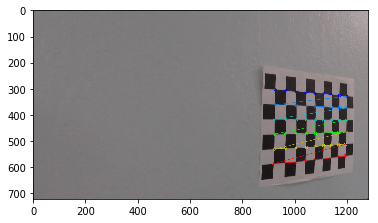

In [5]:
datapath= ('home/Udacity/P4-Advanced-Lane-Lines/P4-Advanced-Lane-Lines/v1')
cal_img_path= glob.glob('/home/chr/Udacity/P4-Advanced-Lane-Lines/P4-Advanced-Lane-Lines/camera_cal/calibration*.jpg')

objpoints= [] #3D real world
imgpoints= [] #2D image plane

objp= np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #mashgrid reshaped back into 2 columns: the x,y coordinates

for fname in cal_img_path:
    cal_img= cv2.imread(fname)
    gray= cv2.cvtColor(cal_img,cv2.COLOR_BGR2GRAY) #convert to gray because originally they are b/w images
    ret, corners= cv2.findChessboardCorners(gray, (nx, ny), None) #find chess corners
    if ret== True: # If corners are found: add image points, object points to their arrays
        imgpoints.append(corners)
        objpoints.append(objp)
        cal_img= cv2.drawChessboardCorners(cal_img, (nx, ny), corners, ret)
        plt.imshow(cal_img)

## Undistort test

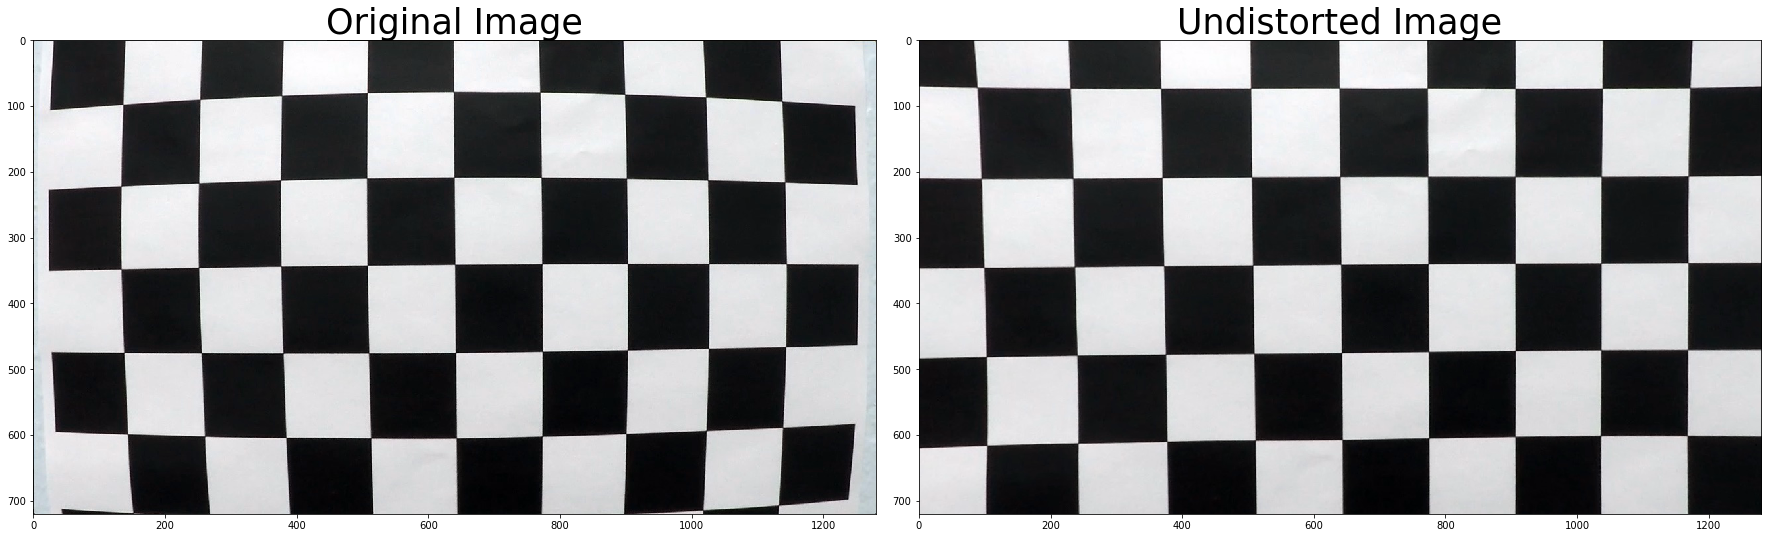

In [175]:
#takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
img=gray
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs= cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)    
    return undist

calibration5= cv2.imread('/home/chr/Udacity/P4-Advanced-Lane-Lines/P4-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
undistorted = cal_undistort(calibration5, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(calibration5)
ax1.set_title('Original Image', fontsize=35)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Undistort image

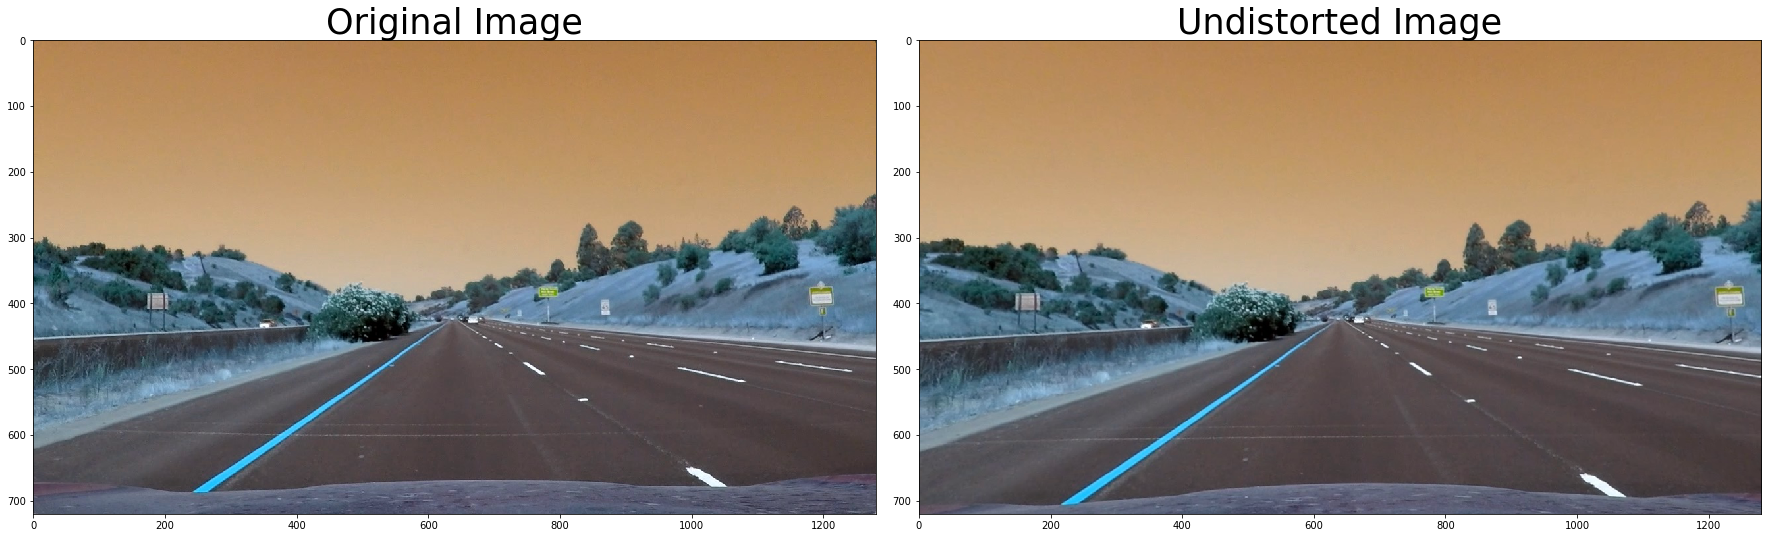

In [8]:
straight_lines1= cv2.imread('/home/chr/Udacity/P4-Advanced-Lane-Lines/P4-Advanced-Lane-Lines/test_images/straight_lines1.jpg')
undistorted = cal_undistort(straight_lines1, objpoints, imgpoints)

#visualization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(straight_lines1)
ax1.set_title('Original Image', fontsize=35)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Manipulate the image to see the lines
here the S Channel of the HSL color space and the xGradient are combined and with thresholds partly supressed.
On the left image below the green pixels are from the gradient and the blue pixels are from the S channel of HSV

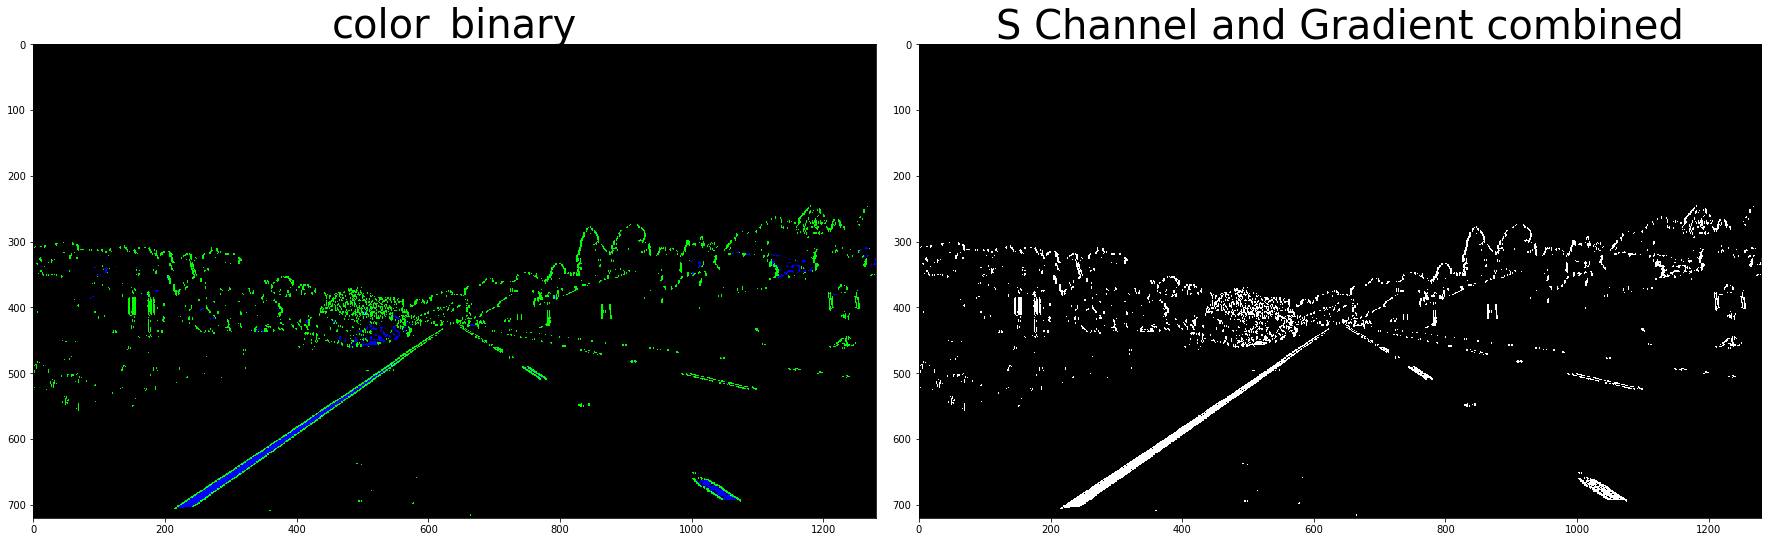

In [173]:
#returns the combined image of S Channel and Gradient
def combSChGrad(img, s_thresh=(s_thresh_min, s_thresh_max), sx_thresh=(thresh_min, thresh_max)):
    img = np.copy(img)
    # Convert to HSL color space and separate the V channel
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsl[:,:,1]
    s_channel = hsl[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary,color_binary

combined_binary,color_binary = combSChGrad(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(color_binary)
ax1.set_title('color_binary', fontsize=40)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('S Channel and Gradient combined', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Choose four points for the perspective transformation

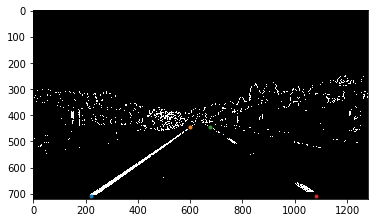

In [162]:
#find the corners of the road that are shaped like a Trapezoid
plt.imshow(combined_binary, cmap='gray')
plt.plot(220,710,'.') #bottom left
plt.plot(600, 445,'.') #top left
plt.plot(675,445,'.') #top right
plt.plot(1080,710,'.') #bottom right

## Transformation / Warp

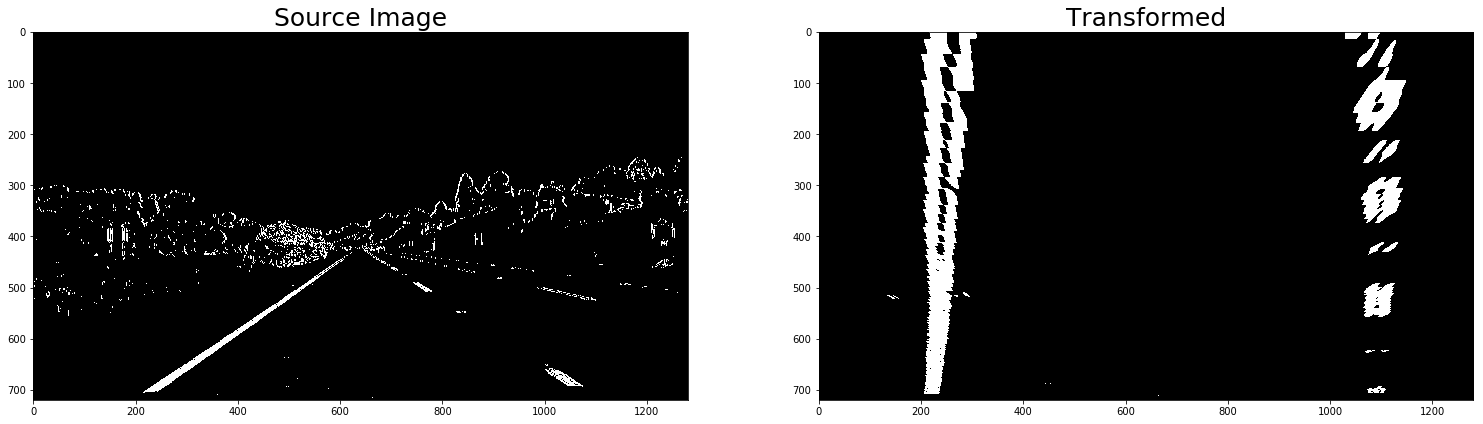

In [163]:
#define perspective transform function
def warp(img):
    #define calibration box coordinates in original
    img_size= (img.shape[1],img.shape[0])
    src = np.float32( 
        [[220, 710],   #left bottom 
        [600, 445],    #top left
        [675, 445],    #top right
        [1080, 710]])  #bottom right
    dst = np.float32(
        [[220, 710],
        [220, 0],
        [1080, 0],
        [1080, 710]])
    
    #Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)
    #Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

#define perspective invers transform function
#after the lane lines in the transformed img are found we need to reverse the transformation 
#to draw to found lines onto the original image
def unwarp(img):
    #define calibration box coordinates in original
    img_size= (img.shape[1],img.shape[0])
    src = np.float32( 
        [[220, 710],   #left bottom 
        [600, 445],    #top left
        [675, 445],    #top right
        [1080, 710]])  #bottom right
    dst = np.float32(
        [[220, 710],
        [220, 0],
        [1080, 0],
        [1080, 710]])
    
    #Compute the perspective transform, M, given source and destination points:
    Minv = cv2.getPerspectiveTransform(dst, src)
    #Warp an image using the perspective transform, M:
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarped

warped_im = warp(combined_binary)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('binary', fontsize=25)
ax1.imshow(combined_binary, cmap='gray')

ax2.set_title('Transformed', fontsize=25)
ax2.imshow(warped_im, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Peaks in histogram show were lane lines are

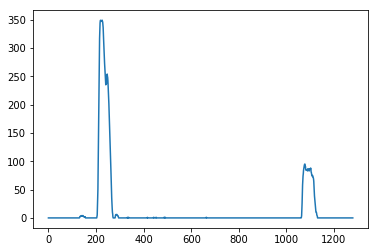

In [165]:
binary_warped= warped_im
# Take a histogram of the bottom half of the image
histogram = np.sum(warped_im[int(warped_im.shape[0]/2):,:], axis=0) #int(img.shape[0]/2)= number of rows
plt.plot(histogram)


## Finding lane lines without information from previous images
### using a histogram
#### Highlighting and and fitting with polynom (order: 2)

In [44]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2) #midpoint of histogram
leftx_base = np.argmax(histogram[:midpoint]) #here is the highest point in the left half of the histogram
rightx_base = np.argmax(histogram[midpoint:]) + midpoint #here is the highest point in the right half of the histogram
window_height = np.int(binary_warped.shape[0]/nwindows) #window height = image hight / nwindows
nonzero = binary_warped.nonzero() # Identify the x and y positions of all nonzero pixels in the image
nonzeroy = np.array(nonzero[0]) #y positions 
nonzerox = np.array(nonzero[1]) #x positions 
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height  # bottom window border 
    win_y_high = binary_warped.shape[0] - window*window_height     #top window border 
    win_xleft_low = leftx_current - margin   # left window border of left line
    win_xleft_high = leftx_current + margin   # right window border of left line
    win_xright_low = rightx_current - margin   # left window border of right line
    win_xright_high = rightx_current + margin   # right window border of right line
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If there are > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


(720, 0)

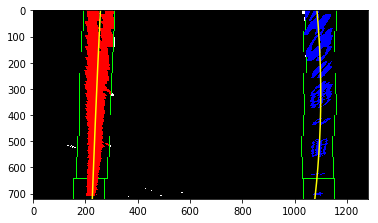

In [45]:
#Visualization

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Finding lane lines with information from previous images
### searching in area close to the lines in the previous image
#### Highlighting and and fitting with polynom (order: 2)

In [46]:
#Skip the sliding windows step once you know where the lines are
#Now we know where the lines are we have a fit! In the next frame of video we don't need to do a blind search again,
#but instead we can just search in a margin around the previous line position like this:

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


(720, 0)

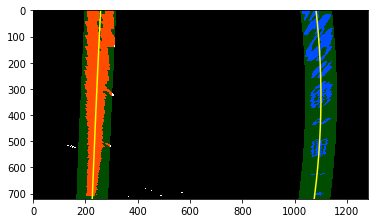

In [47]:
#Visualization
#Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Measuring curvature

In [176]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image

# Define conversions in x and y from pixels space to meters
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
curvature=(left_curverad+right_curverad)/2
print(curvature)

140439.26453 m 6695.87395371 m
73567.5692419


## Vehicles distance from road center

In [178]:
#distance from center of the lane
def offset_center(leftx_base, rightx_base, midpoint):
        offset_value= ((leftx_base+rightx_base)/2-midpoint)*xm_per_pix
        return offset_value

offset_value= offset_center(leftx_base, rightx_base, midpoint)
print(offset_value)


if offset_value > 0:
        offset_center_text=str(round(offset_value, 3)),'meters right of center'
else:
        offset_center_text=str(round(abs(offset_value), 3)),'meters left of center'
print(offset_center_text)

0.0569230769231
('0.057', 'meters right of center')


## Draw the detected lane back onto the original image

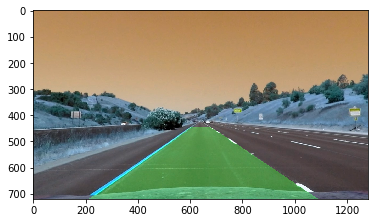

In [118]:
#project the measurement back down the original image/the road
# Create an image to draw the lines on
warped=combined_binary
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp= unwarp(color_warp)

# Combine the result with the original image
#the original image has a weight of one while the marked lane has a weight of 0.3 in order to be transperant
lane_on_original = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0) 

plt.imshow(lane_on_original)

## Write the curvature & offset to center onto image

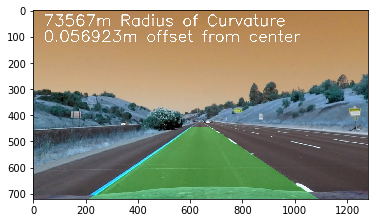

In [179]:
font = cv2.FONT_HERSHEY_SIMPLEX
new= cv2.putText(lane_on_original,'%dm Radius of Curvature' % curvature,(40,60), font, 2,(255,255,255),2,cv2.LINE_AA)

if offset_value > 0:
    offset_center_text=str(round(offset_value, 3)),'meters right of center'
else:
    offset_center_text=str(round(abs(offset_value), 3)),'meters left of center'
new= cv2.putText(lane_on_original,'%fm offset from center' % offset_value,(40,120), font, 2,(255,255,255),2,cv2.LINE_AA)
plt.imshow(new)


# Reduced pipline for the video

## Define functions needed for the pipeline

In [180]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs= cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)    
    return undist

#def hls_select(img, thresh=(thresh_min, thresh_max)):
#    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)  # Convert to HLS color space
#    s_channel = hls[:,:,2]     # Apply a threshold to the S channel
#    binary_output = np.zeros_like(s_channel)
#    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1  # Return a binary image of threshold result
#    return binary_output
def combSChGrad(img, s_thresh=(s_thresh_min, s_thresh_max), sx_thresh=(thresh_min, thresh_max)):
    img = np.copy(img)
    # Convert to hls color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    # Combine the two binary thresholds
    SCh_Grad_Binary = np.zeros_like(sxbinary)
    SCh_Grad_Binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return SCh_Grad_Binary

def warp(img):
    #define calibration box coordinates in original
    img_size= (img.shape[1],img.shape[0])
    src = np.float32( 
        [[220, 710],   #left bottom 
        [600, 445],    #top left
        [675, 445],    #top right
        [1080, 710]])  #bottom right
    dst = np.float32(
        [[220, 710],
        [220, 0],
        [1080, 0],
        [1080, 710]])
    
    #Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)
    #Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def unwarp(img):
    #define calibration box coordinates in original
    img_size= (img.shape[1],img.shape[0])
    src = np.float32( 
        [[220, 710],   #left bottom 
        [600, 445],    #top left
        [675, 445],    #top right
        [1080, 710]])  #bottom right
    dst = np.float32(
        [[220, 710],
        [220, 0],
        [1080, 0],
        [1080, 710]])
    
    #Compute the perspective transform, M, given source and destination points:
    Minv = cv2.getPerspectiveTransform(dst, src)
    #Warp an image using the perspective transform, M:
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarped

#distance from center of the lane
def offset_center(leftx_base, rightx_base, midpoint):
        offset_value= ((leftx_base+rightx_base)/2-midpoint)*xm_per_pix
        return offset_value

## Camera calibration

In [181]:
cal_img_path= glob.glob('/home/chr/Udacity/P4-Advanced-Lane-Lines/P4-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
objpoints= [] #3D real world
imgpoints= [] #2D image plane

objp= np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #mashgrid reshaped back into 2 columns: the x,y coordinates

for fname in cal_img_path:
    cal_img= cv2.imread(fname)
    gray= cv2.cvtColor(cal_img,cv2.COLOR_BGR2GRAY) #convert to gray because originally they are b/w images
    ret, corners= cv2.findChessboardCorners(gray, (nx, ny), None) #find chess corners
    if ret== True: # If corners are found: add image points, object points to their arrays
        imgpoints.append(corners)
        objpoints.append(objp)

## Imageprocessing

In [182]:
def pipeline(image):
    undistorted = cal_undistort(image, objpoints, imgpoints) 
    SCh_Grad_Binary= combSChGrad(undistorted, s_thresh=(s_thresh_min, s_thresh_max), sx_thresh=(thresh_min, thresh_max))
    warped_im = warp(SCh_Grad_Binary)
    #----------
    histogram = np.sum(warped_im[int(warped_im.shape[0]/2):,:], axis=0) #int(img.shape[0]/2)= number of rows
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped_im, warped_im, warped_im))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2) #midpoint of histogram
    leftx_base = np.argmax(histogram[:midpoint]) #here is the highest point in the left half of the histogram
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint #here is the highest point in the right half of the histogram
    window_height = np.int(warped_im.shape[0]/nwindows) #window height = image hight / nwindows
    nonzero = warped_im.nonzero() # Identify the x and y positions of all nonzero pixels in the image
    nonzeroy = np.array(nonzero[0]) #y positions 
    nonzerox = np.array(nonzero[1]) #x positions 
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_im.shape[0] - (window+1)*window_height  # bottom window border 
        win_y_high = warped_im.shape[0] - window*window_height     #top window border 
        win_xleft_low = leftx_current - margin   # left window border of left line
        win_xleft_high = leftx_current + margin   # right window border of left line
        win_xright_low = rightx_current - margin   # left window border of right line
        win_xright_high = rightx_current + margin   # right window border of right line
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If there are > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    print(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #-------------------
    #Measuring curvature
    # Define conversions in x and y from pixels space to meters
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    curvature=(left_curverad+right_curverad)/2
    #----------------
    offset_value= offset_center(leftx_base, rightx_base, midpoint)
    #-----------
    #Draw the detected lane back onto the original image
    #project the measurement back down the original image/the road
    # Create an image to draw the lines on
    warped=SCh_Grad_Binary
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp= unwarp(color_warp)

    # Combine the result with the original image
    #the original image has a weight of one while the marked lane has a weight of 0.3 in order to be transperant
    lane_on_original = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0) 
    #--------------------
    #Write the curvature, offset to center onto image
    font = cv2.FONT_HERSHEY_SIMPLEX
    im_text= cv2.putText(lane_on_original,'%dm Radius of Curvature' % curvature,(40,60), font, 2,(255,255,255),2,cv2.LINE_AA)

    if offset_value > 0.0:
        offset_center_text=str(round(offset_value, 3)),'meters right of center'
    else:
        offset_center_text=str(round(abs(offset_value), 3)),'meters left of center'
    img_with_stats= cv2.putText(lane_on_original,'%fm offset from center' % offset_value,(40,120), font, 2,(255,255,255),2,cv2.LINE_AA)
  
    return img_with_stats

## Create Video

In [185]:
#video code from P1
project_output = 'project_output.mp4' 
clip1 = VideoFileClip("/home/chr/Udacity/P4-Advanced-Lane-Lines/from udacity github CarND-Advanced-Lane-Lines-master/harder_challenge_video.mp4")#.subclip(1,2) #load video
project_output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_output_clip.write_videofile(project_output, audio=False)

[59827 59828 59829 ..., 15316 15317 15318]
[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


  0%|          | 1/1200 [00:01<20:50,  1.04s/it]

[59827 59828 59829 ..., 15316 15317 15318]


  0%|          | 2/1200 [00:02<20:58,  1.05s/it]

[60527 60528 60529 ..., 10304 10305 10306]


  0%|          | 3/1200 [00:03<20:37,  1.03s/it]

[56568 56569 56570 ...,  3673  3674  3675]


  0%|          | 4/1200 [00:04<20:08,  1.01s/it]

[61390 61391 61392 ...,  2802  2803  2991]


  0%|          | 5/1200 [00:05<19:52,  1.00it/s]

[61398 61399 61400 ...,  2842  3039  3229]


  0%|          | 6/1200 [00:06<19:41,  1.01it/s]

[55876 55877 55878 ..., 27109 27110     0]


  1%|          | 7/1200 [00:06<19:17,  1.03it/s]

[53588 53589 53590 ...,  3881  3882  4057]


  1%|          | 8/1200 [00:07<18:59,  1.05it/s]

[61415 61416 61417 ..., 18638 18639 18640]


  1%|          | 9/1200 [00:08<18:53,  1.05it/s]

[65027 65028 65029 ..., 15190 15191 15192]


  1%|          | 10/1200 [00:09<19:22,  1.02it/s]

[61182 61183 61184 ..., 12934 12935 12936]


  1%|          | 11/1200 [00:10<19:19,  1.03it/s]

[53735 53736 53737 ..., 10634 10635 10636]


  1%|          | 12/1200 [00:11<19:12,  1.03it/s]

[55558 55559 55560 ..., 11102 11103 11104]


  1%|          | 13/1200 [00:12<19:08,  1.03it/s]

[54464 54465 54466 ..., 12322 12323 12324]


  1%|          | 14/1200 [00:13<19:07,  1.03it/s]

[56857 56858 56859 ..., 10133 10134 10135]


  1%|▏         | 15/1200 [00:14<19:01,  1.04it/s]

[64837 64838 64839 ..., 11261 11262 11263]


  1%|▏         | 16/1200 [00:15<18:55,  1.04it/s]

[54545 54546 54547 ..., 10474 10475 10476]


  1%|▏         | 17/1200 [00:16<19:07,  1.03it/s]

[62267 62268 62269 ..., 15061 15062 15063]


  2%|▏         | 18/1200 [00:17<19:16,  1.02it/s]

[69655 69656 69657 ..., 17499 17500 17501]


  2%|▏         | 19/1200 [00:18<19:18,  1.02it/s]

[68210 68211 68212 ..., 13813 13814 13815]


  2%|▏         | 20/1200 [00:19<19:11,  1.02it/s]

[73167 73168 73169 ..., 15617 15618 15619]


  2%|▏         | 21/1200 [00:20<18:56,  1.04it/s]

[68046 68047 68048 ..., 14422 14423 14424]


  2%|▏         | 22/1200 [00:21<18:58,  1.03it/s]

[53855 53856 53857 ..., 11935 11936 11937]


  2%|▏         | 23/1200 [00:22<18:48,  1.04it/s]

[53061 53062 53063 ..., 11177 11178 11179]


  2%|▏         | 24/1200 [00:23<18:48,  1.04it/s]

[50274 50275 50276 ..., 12222 12223 12224]


  2%|▏         | 25/1200 [00:24<18:53,  1.04it/s]

[58103 58104 58105 ..., 15851 15852 15853]


  2%|▏         | 26/1200 [00:25<18:45,  1.04it/s]

[57391 57392 57393 ..., 16482 16483 16484]


  2%|▏         | 27/1200 [00:26<18:47,  1.04it/s]

[59359 59360 59361 ..., 15323 15324 15325]


  2%|▏         | 28/1200 [00:27<18:53,  1.03it/s]

[58277 58278 58279 ...,  9263  9264  9265]


  2%|▏         | 29/1200 [00:28<18:48,  1.04it/s]

[57147 57148 57149 ...,  9943  9944  9945]


  2%|▎         | 30/1200 [00:29<18:56,  1.03it/s]

[59948 59949 59950 ..., 13260 13261 13262]


  3%|▎         | 31/1200 [00:30<19:04,  1.02it/s]

[53936 53937 53938 ...,  9101  9102  9103]


  3%|▎         | 32/1200 [00:31<19:10,  1.02it/s]

[85454 85455 85456 ..., 17584 17585 17586]


  3%|▎         | 33/1200 [00:32<18:50,  1.03it/s]

[73536 73537 73538 ..., 12840 12841 12842]


  3%|▎         | 34/1200 [00:33<18:44,  1.04it/s]

[52924 52925 52926 ...,  8441  8442  8443]


  3%|▎         | 35/1200 [00:33<18:40,  1.04it/s]

[56592 56593 56594 ..., 12394 12395 12396]


  3%|▎         | 36/1200 [00:34<18:42,  1.04it/s]

[83579 83580 83581 ..., 21670 21671 21672]


  3%|▎         | 37/1200 [00:35<18:35,  1.04it/s]

[84996 84997 84998 ..., 12068 12069 12070]


  3%|▎         | 38/1200 [00:36<18:38,  1.04it/s]

[84124 84125 84126 ..., 18082 18083 18084]


  3%|▎         | 39/1200 [00:37<18:25,  1.05it/s]

[82685 82686 82687 ..., 15581 15582 15583]


  3%|▎         | 40/1200 [00:38<18:21,  1.05it/s]

[105992 105993 105994 ...,  15087  15088  15089]


  3%|▎         | 41/1200 [00:39<18:19,  1.05it/s]

[103875 103876 103971 ...,  40981  40982  40983]


  4%|▎         | 42/1200 [00:40<18:12,  1.06it/s]

[112715 112716 112717 ...,  44753  44754  44755]


  4%|▎         | 43/1200 [00:41<18:59,  1.02it/s]

[110492 110493 110494 ...,  24726  24727  24728]


  4%|▎         | 44/1200 [00:42<19:15,  1.00it/s]

[101737 101738 101739 ...,  23899  23900  23901]


  4%|▍         | 45/1200 [00:43<19:01,  1.01it/s]

[107490 107491 107492 ...,  26601  26602  26603]


  4%|▍         | 46/1200 [00:44<19:04,  1.01it/s]

[113839 113840 113841 ...,  27757  27758  27759]


  4%|▍         | 47/1200 [00:45<18:53,  1.02it/s]

[115801 115802 115803 ...,  28936  28937  28938]


  4%|▍         | 48/1200 [00:46<19:06,  1.01it/s]

[107125 107126 107127 ...,  18055  18056  18057]


  4%|▍         | 49/1200 [00:47<18:57,  1.01it/s]

[112810 112811 112812 ...,  18578  18579  18580]


  4%|▍         | 50/1200 [00:48<19:02,  1.01it/s]

[103769 103770 103771 ...,   6637   6638   6639]


  4%|▍         | 51/1200 [00:49<19:03,  1.00it/s]

[96323 96324 96325 ..., 20366 20367 20368]


  4%|▍         | 52/1200 [00:50<18:49,  1.02it/s]

[101193 101194 101195 ...,  22721  22722  22723]


  4%|▍         | 53/1200 [00:51<18:44,  1.02it/s]

[101622 101623 101624 ...,  23902  23903  23904]


  4%|▍         | 54/1200 [00:52<18:47,  1.02it/s]

[104904 104905 104906 ...,  54058  54059  54060]


  5%|▍         | 55/1200 [00:53<18:42,  1.02it/s]

[91044 91045 91046 ...,  4753  4754  4755]


  5%|▍         | 56/1200 [00:54<18:49,  1.01it/s]

[88942 88943 88944 ...,  1199  1200  1438]


  5%|▍         | 57/1200 [00:55<18:36,  1.02it/s]

[83181 83182 83183 ..., 37441 37569 37692]


  5%|▍         | 58/1200 [00:56<18:23,  1.04it/s]

[78722 78723 78724 ..., 49845 49846 49847]


  5%|▍         | 59/1200 [00:57<18:26,  1.03it/s]

[73680 73681 73682 ..., 20999 21000 21001]


  5%|▌         | 60/1200 [00:58<18:23,  1.03it/s]

[72433 72434 72435 ..., 19844 19845 19941]


  5%|▌         | 61/1200 [00:59<18:36,  1.02it/s]

[81224 81225 81226 ...,  3647  3648  3649]


  5%|▌         | 62/1200 [01:00<18:37,  1.02it/s]

[84660 84661 84662 ...,  2531  2532  2824]


  5%|▌         | 63/1200 [01:01<18:34,  1.02it/s]

[72437 72438 72439 ..., 14314 14315 14316]


  5%|▌         | 64/1200 [01:02<19:03,  1.01s/it]

[82164 82165 82166 ..., 17781 17782 17783]


  5%|▌         | 65/1200 [01:03<19:07,  1.01s/it]

[75890 75891 75892 ..., 15787 15788 15789]


  6%|▌         | 66/1200 [01:04<18:45,  1.01it/s]

[68191 68192 68193 ..., 15873 15874 15875]


  6%|▌         | 67/1200 [01:05<18:30,  1.02it/s]

[64241 64242 64243 ..., 14630 14631 14632]


  6%|▌         | 68/1200 [01:06<18:35,  1.01it/s]

[62365 62366 62367 ..., 13425 13426 13427]


  6%|▌         | 69/1200 [01:07<18:32,  1.02it/s]

[70430 70431 70432 ..., 15228 15229 15230]


  6%|▌         | 70/1200 [01:08<18:18,  1.03it/s]

[68960 68961 68962 ..., 15545 15546 15547]


  6%|▌         | 71/1200 [01:09<18:10,  1.04it/s]

[54830 54831 54832 ..., 12867 12868 12869]


  6%|▌         | 72/1200 [01:10<18:02,  1.04it/s]

[67928 67929 67930 ..., 14794 14795 14796]


  6%|▌         | 73/1200 [01:11<17:54,  1.05it/s]

[58381 58382 47652 ..., 12314 12315 12316]


  6%|▌         | 74/1200 [01:12<18:02,  1.04it/s]

[65341 65342 65352 ..., 13064 13065 13066]


  6%|▋         | 75/1200 [01:13<17:51,  1.05it/s]

[73304 73407 73408 ..., 12869 12870 12871]


  6%|▋         | 76/1200 [01:14<18:01,  1.04it/s]

[66061 66190 66191 ...,  6750  6953  7157]


  6%|▋         | 77/1200 [01:14<17:49,  1.05it/s]

[63876 63997 63998 ..., 14870 14871 14872]


  6%|▋         | 78/1200 [01:15<17:40,  1.06it/s]

[60779 60780 47311 ..., 13413 13414 13415]


  7%|▋         | 79/1200 [01:16<17:38,  1.06it/s]

[60907 60908 47812 ..., 13023 13024 13025]


  7%|▋         | 80/1200 [01:17<18:07,  1.03it/s]

[60689 60690 50035 ..., 24392 24393 24394]


  7%|▋         | 81/1200 [01:18<18:04,  1.03it/s]

[52263 52264 42354 ..., 17651 17652 17653]


  7%|▋         | 82/1200 [01:19<18:05,  1.03it/s]

[54267 54268 41899 ..., 18829 18830 19000]


  7%|▋         | 83/1200 [01:20<17:58,  1.04it/s]

[49587 38042 38043 ..., 16676 16677 16678]


  7%|▋         | 84/1200 [01:21<17:57,  1.04it/s]

[48210 48211 48212 ..., 30624 30625 30626]


  7%|▋         | 85/1200 [01:22<17:53,  1.04it/s]

[43100 43101 43102 ..., 47662 43001 43002]


  7%|▋         | 86/1200 [01:23<18:02,  1.03it/s]

[41042 41043 41044 ..., 18469 18470 18471]


  7%|▋         | 87/1200 [01:24<17:52,  1.04it/s]

[38645 38646 38647 ..., 15898 15899 15900]


  7%|▋         | 88/1200 [01:25<17:43,  1.05it/s]

[41689 41690 41691 ...,  5940  5941  5942]


  7%|▋         | 89/1200 [01:26<17:41,  1.05it/s]

[40218 40219 40220 ...,  4184  4185  4186]


  8%|▊         | 90/1200 [01:27<17:39,  1.05it/s]

[39784 39785 39786 ...,  4876  4877  4878]


  8%|▊         | 91/1200 [01:28<17:30,  1.06it/s]

[36021 36022 36023 ...,  3857  3858  3859]


  8%|▊         | 92/1200 [01:29<17:57,  1.03it/s]

[29795 29796 29797 ...,  6855  6856  6857]


  8%|▊         | 93/1200 [01:30<17:51,  1.03it/s]

[32275 32276 32277 ...,  8182  8183  8184]


  8%|▊         | 94/1200 [01:31<17:47,  1.04it/s]

[22260 22261 22262 ...,  1218  1219  1220]


  8%|▊         | 95/1200 [01:32<17:37,  1.05it/s]

[26729 26730 26731 ...,  9931  9932  9933]


  8%|▊         | 96/1200 [01:33<17:41,  1.04it/s]

[25034 25114 25115 ...,  8730  8731  8732]


  8%|▊         | 97/1200 [01:34<17:38,  1.04it/s]

[26543 26544 26619 ...,  8297  8298  8299]


  8%|▊         | 98/1200 [01:35<17:30,  1.05it/s]

[29877 29878 29945 ...,  9738  9739  9740]


  8%|▊         | 99/1200 [01:36<17:23,  1.05it/s]

[29938 29939 29940 ...,  9945  9946  9947]


  8%|▊         | 100/1200 [01:37<17:26,  1.05it/s]

[30448 30449 30450 ...,  9995  9996  9997]


  8%|▊         | 101/1200 [01:37<17:25,  1.05it/s]

[31196 31197 31198 ..., 10104 10116 10117]


  8%|▊         | 102/1200 [01:38<17:19,  1.06it/s]

[34573 34574 34575 ..., 14702 14703 14704]


  9%|▊         | 103/1200 [01:39<17:13,  1.06it/s]

[31040 31041 31042 ..., 13144 13145 13146]


  9%|▊         | 104/1200 [01:40<17:12,  1.06it/s]

[34898 34899 34900 ..., 10401 10421 10422]


  9%|▉         | 105/1200 [01:41<17:07,  1.07it/s]

[34538 34539 34540 ..., 16330 10157 10158]


  9%|▉         | 106/1200 [01:42<17:05,  1.07it/s]

[36130 36131 36132 ..., 12929 12930 12931]


  9%|▉         | 107/1200 [01:43<17:04,  1.07it/s]

[32549 32550 32551 ...,  8680  8681  8682]


  9%|▉         | 108/1200 [01:44<17:13,  1.06it/s]

[32863 32864 32865 ...,  9575  9576  9577]


  9%|▉         | 109/1200 [01:45<17:14,  1.05it/s]

[34616 34617 34618 ...,  9665  9666  9667]


  9%|▉         | 110/1200 [01:46<17:13,  1.06it/s]

[37055 37056 37057 ..., 10807 10808 10809]


  9%|▉         | 111/1200 [01:47<17:12,  1.05it/s]

[43279 43385 43386 ...,  6448  6449  6450]


  9%|▉         | 112/1200 [01:48<17:14,  1.05it/s]

[51442 51443 51444 ...,  4923  4924  4925]


  9%|▉         | 113/1200 [01:49<17:08,  1.06it/s]

[57249 57250 57251 ...,  3487  3488  3489]


 10%|▉         | 114/1200 [01:50<17:07,  1.06it/s]

[63662 63663 63664 ...,  4687  4688  4689]


 10%|▉         | 115/1200 [01:51<17:10,  1.05it/s]

[79126 79127 79128 ..., 10925 10926 10927]


 10%|▉         | 116/1200 [01:52<17:32,  1.03it/s]

[83112 83113 83114 ..., 16364 16365 16366]


 10%|▉         | 117/1200 [01:53<17:26,  1.04it/s]

[82589 82590 82591 ..., 17176 17177 17178]


 10%|▉         | 118/1200 [01:54<17:24,  1.04it/s]

[81944 81945 81946 ..., 16984 16985 16986]


 10%|▉         | 119/1200 [01:55<17:17,  1.04it/s]

[85827 85828 85829 ..., 17667 17668 17669]


 10%|█         | 120/1200 [01:56<17:23,  1.04it/s]

[94817 94818 94819 ..., 19611 19612 19613]


 10%|█         | 121/1200 [01:57<17:15,  1.04it/s]

[82672 82673 82674 ..., 64162 64163 64164]


 10%|█         | 122/1200 [01:57<17:06,  1.05it/s]

[71631 71632 71633 ..., 54392 54393 54394]


 10%|█         | 123/1200 [01:58<17:04,  1.05it/s]

[58157 58158 58159 ..., 42068 42069 42070]


 10%|█         | 124/1200 [01:59<17:52,  1.00it/s]

[55664 55665 55666 ..., 39410 39411 39412]


 10%|█         | 125/1200 [02:00<17:41,  1.01it/s]

[51363 51408 51409 ..., 35004 35005 35006]


 10%|█         | 126/1200 [02:01<17:21,  1.03it/s]

[41965 41966 41967 ..., 26111 26112 26113]


 11%|█         | 127/1200 [02:02<17:11,  1.04it/s]

[33066 33067 33068 ...,   175   191   192]


 11%|█         | 128/1200 [02:03<17:11,  1.04it/s]

[30263 30264 30265 ..., 22603 22604 22605]


 11%|█         | 129/1200 [02:04<17:04,  1.05it/s]

[23923 23924 23925 ...,    77    78    79]


 11%|█         | 130/1200 [02:05<16:53,  1.06it/s]

[19056 19057 19058 ...,   277   278   289]


 11%|█         | 131/1200 [02:06<16:47,  1.06it/s]

[17283 17284 17285 ...,   115   116   139]


 11%|█         | 132/1200 [02:07<16:58,  1.05it/s]

[15457 15458 15459 ...,  7774  7775  7776]


 11%|█         | 133/1200 [02:08<16:54,  1.05it/s]

[13630 13631 13632 ...,  5857  5858  5859]


 11%|█         | 134/1200 [02:09<16:49,  1.06it/s]

[12490 12491 12492 ...,  5140  5141  5142]


 11%|█▏        | 135/1200 [02:10<16:53,  1.05it/s]

[12209 12210 12211 ...,  5004  5005  5006]


 11%|█▏        | 136/1200 [02:11<17:06,  1.04it/s]

[9511 9512 9513 ..., 3133 3134 3135]


 11%|█▏        | 137/1200 [02:12<16:56,  1.05it/s]

[8939 8940 8941 ..., 3051 3052 3053]


 12%|█▏        | 138/1200 [02:13<16:51,  1.05it/s]

[9533 9534 9535 ..., 3256 3257 3258]


 12%|█▏        | 139/1200 [02:14<16:50,  1.05it/s]

[9822 9823 9824 ..., 3786 3787 3788]


 12%|█▏        | 140/1200 [02:15<16:46,  1.05it/s]

[9197 9198 9199 ..., 3379 3380 3381]


 12%|█▏        | 141/1200 [02:16<16:39,  1.06it/s]

[9328 9329 9330 ..., 9292 9293 9294]


 12%|█▏        | 142/1200 [02:17<16:36,  1.06it/s]

[9855 9856 9857 ..., 9818 9819 9820]


 12%|█▏        | 143/1200 [02:18<16:46,  1.05it/s]

[9357 9358 9359 ..., 9319 9320 9321]


 12%|█▏        | 144/1200 [02:18<16:45,  1.05it/s]

[9221 9222 9223 ..., 9185 9186 9187]


 12%|█▏        | 145/1200 [02:19<16:35,  1.06it/s]

[8553 8554 8555 ..., 8516 8517 8518]


 12%|█▏        | 146/1200 [02:20<16:33,  1.06it/s]

[8642 8643 8644 ..., 8602 8603 8604]


 12%|█▏        | 147/1200 [02:21<16:42,  1.05it/s]

[11728 11729 11730 ...,  1017  1018  1021]


 12%|█▏        | 148/1200 [02:22<16:46,  1.05it/s]

[12743 12744 12745 ...,  1596  1597  1598]


 12%|█▏        | 149/1200 [02:23<16:49,  1.04it/s]

[11515 11516 11517 ...,   748   749   750]


 12%|█▎        | 150/1200 [02:24<16:49,  1.04it/s]

[12708 12709 12710 ...,  1442  1443  1444]


 13%|█▎        | 151/1200 [02:25<16:56,  1.03it/s]

[14238 14239 14240 ...,  1167  1168  1169]


 13%|█▎        | 152/1200 [02:26<16:56,  1.03it/s]

[13063 13064 13065 ...,  1346  1347  1348]


 13%|█▎        | 153/1200 [02:27<16:49,  1.04it/s]

[10871 10872 10873 ...,   413   414   445]


 13%|█▎        | 154/1200 [02:28<16:56,  1.03it/s]

[12267 12268 12269 ...,   240   241   242]


 13%|█▎        | 155/1200 [02:29<16:49,  1.04it/s]

[13577 13578 13579 ...,   519   520   521]


 13%|█▎        | 156/1200 [02:30<16:47,  1.04it/s]

[13447 13448 13449 ...,   735   736   737]


 13%|█▎        | 157/1200 [02:31<16:53,  1.03it/s]

[11303 11304 11305 ...,   317   318   319]


 13%|█▎        | 158/1200 [02:32<16:43,  1.04it/s]

[11674 11675 11676 ..., 11627 11628 11629]


 13%|█▎        | 159/1200 [02:33<16:30,  1.05it/s]

[11044 11045 11046 ..., 10984 10985 10986]


 13%|█▎        | 160/1200 [02:34<16:24,  1.06it/s]

[9934 9935 9936 ..., 9879 9880 9881]


 13%|█▎        | 161/1200 [02:35<16:40,  1.04it/s]

[6814 6815 6816 ..., 6648 6649 6650]


 14%|█▎        | 162/1200 [02:36<16:40,  1.04it/s]

[5730 5731 5732 ..., 5685 5686 5687]


 14%|█▎        | 163/1200 [02:37<16:24,  1.05it/s]

[5175 5176 5177 ..., 5133 5134 5135]


 14%|█▎        | 164/1200 [02:38<16:40,  1.04it/s]

[5322 5323 5324 ..., 9702 9714 9715]


 14%|█▍        | 165/1200 [02:39<16:30,  1.04it/s]

[4971 4972 4973 ..., 9032 9033 9034]


 14%|█▍        | 166/1200 [02:40<16:29,  1.04it/s]

[5945 6003 6004 ..., 5026 5876 5877]


 14%|█▍        | 167/1200 [02:41<16:18,  1.06it/s]

[5682 5683 5684 ..., 4379 4380 4381]


 14%|█▍        | 168/1200 [02:42<16:34,  1.04it/s]

[4857 4858 4879 ..., 9977 3929 3930]


 14%|█▍        | 169/1200 [02:43<17:04,  1.01it/s]

[4872 4921 4984 ..., 9844 3657 3658]


 14%|█▍        | 170/1200 [02:44<16:55,  1.01it/s]

[4101 4102 4103 ..., 4089 4090 4091]


 14%|█▍        | 171/1200 [02:45<16:53,  1.02it/s]

[3155 3156 3157 ..., 3152 3153 3154]


 14%|█▍        | 172/1200 [02:45<16:40,  1.03it/s]

[1819 1820 1821 ..., 1760 1761 1762]


 14%|█▍        | 173/1200 [02:46<16:25,  1.04it/s]

[1830 1855 1856 ..., 1733 1787 1788]


 14%|█▍        | 174/1200 [02:47<16:31,  1.03it/s]

[1427 1428 1429 ..., 1372 1373 1374]


 15%|█▍        | 175/1200 [02:48<16:17,  1.05it/s]

[1384 1385 1386 ..., 1373 1374 1375]


 15%|█▍        | 176/1200 [02:49<16:36,  1.03it/s]

[1474 1475 1476 ..., 1453 1454 1455]


 15%|█▍        | 177/1200 [02:50<16:24,  1.04it/s]

[2739 2740 2741 ..., 2001 2002 2003]


 15%|█▍        | 178/1200 [02:51<16:22,  1.04it/s]

[7089 7141 7142 ..., 6824 6825 6826]


 15%|█▍        | 179/1200 [02:52<16:17,  1.04it/s]

[5982 5983 5984 ..., 5947 5948 5949]


 15%|█▌        | 180/1200 [02:53<16:36,  1.02it/s]

[6964 6965 6966 ..., 6916 6917 6918]


 15%|█▌        | 181/1200 [02:54<16:23,  1.04it/s]

[9971 9972 9973 ..., 9894 9895 9896]


 15%|█▌        | 182/1200 [02:55<16:13,  1.05it/s]

[7959 7960 7961 ..., 7914 7915 7916]


 15%|█▌        | 183/1200 [02:56<16:05,  1.05it/s]

[ 9399  9400  9401  9402  9403  9463  9464  9465  9466  9467  9468  9469
  9545  9546  9547  9548  9549  9550  9604  9605  9606  9607  9644  9645
  9646  9647  9648  9649  9650  9694  9695  9696  9697  9698  9699  9700
  9701  9702  9703  9704  9749  9750  9751  9752  9753  9754  9755  9790
  9791  9792  9933  9953  9954  9973  9974 10057 10058 10059 10060 10061
 10062 10063 10064 10065 10066 10067 10068 10069 10070 10071 10072 10073
 10074 10075 10076 10077 10078 10079 10080 10081 10082 10083 10084 10085
 10086 10087 10088 10089 10090 10091 10092 10093 10094 10095 10096 10097
 10098 10244 10245 10246 10264 10265 10314 10315 10341 10342 10343 10344
 10345 10346 10347 10348 10349 10410 10411 10412 10413 10414 10415 10416
 10417 10418 10419 10420 10421 10422 10423 10424 10425 10426 10427 10428
 10429 10430 10431 10432 10467 10468 10469 10470 10471 10472 10473 10502
 10503 10504 10505 10506 10507 10508 10509 10510 10547 10548 10549 10550
 10551 10552 10553 10554 10555 10556 10557 10558 10

 15%|█▌        | 184/1200 [02:57<16:10,  1.05it/s]

[16036 16037 16038 ..., 10542  7976  7977]


 15%|█▌        | 185/1200 [02:58<16:00,  1.06it/s]

[24324 24325 24326 ..., 14848 14849 14850]


 16%|█▌        | 186/1200 [02:59<16:00,  1.06it/s]

[22417 22418 22419 ...,  2370  2371  2387]


 16%|█▌        | 187/1200 [03:00<15:55,  1.06it/s]

[20391 20392 20393 ...,  2646  2647  2689]


 16%|█▌        | 188/1200 [03:01<16:07,  1.05it/s]

[13426 13427 13452 ..., 10291 10292 10293]


 16%|█▌        | 189/1200 [03:02<16:08,  1.04it/s]

[12194 12195 12227 12228 12229 12230 12231 12232 12261 12262 12263 12264
 12265 12266 12292 12293 12294 12321 12322 12323 12324 12351 12352 12372
 12382 12383 12384 12385 12386 12387 12388 12389 12392 12393 12394 12395
 12396 12403 12404 12420 12421 12422 12423 12424 12448 12449 12450 12467
 12468 12469 12470 12525 12526 12527 12528 12529 12530 12531 12532 12533
 12534 12535 12536 12537 12538 12539 12540 12541 12684 12685 12686 12687
 12688 12689 12690 12691 12692 12693 12694 12695 12696 12697 12698 12699
 12700 12701 12702 12703 12704 12705 12706 12707 12796 12797 12798 12799
 12800 12801 12847 12848 12849 12850 12851 12852 12895 12905 12906 12907
 12908 12909 12910 12911 12912 12913 12925 12926 12927 12928 12929 12930
 12931 13116 13128 13142 10099 10100 10101 10102 10103 10104 10105 10106
 10107 10108 10112 10113 10114 10115 10116 10134 10142 10143 10154 10155
 10156 10160 10243 10244 10245 10246 10247 10248 10249 10250 10251 10285
 10286 10287 10288 10289 10290 10291 10292 10293 10

 16%|█▌        | 190/1200 [03:03<16:02,  1.05it/s]

[12249 12250 12251 ...,  3460  3461  3462]


 16%|█▌        | 191/1200 [03:04<15:57,  1.05it/s]

[13688 13689 13690 ...,  1201  1202  1203]


 16%|█▌        | 192/1200 [03:05<15:58,  1.05it/s]

[22069 22070 22071 ...,  7189  7190  7191]


 16%|█▌        | 193/1200 [03:06<15:55,  1.05it/s]

[25841 25842 25843 ..., 11661 11662 11663]


 16%|█▌        | 194/1200 [03:07<16:12,  1.03it/s]

[35506 35507 35508 ..., 19380 19381 19382]


 16%|█▋        | 195/1200 [03:07<16:06,  1.04it/s]

[42418 42466 42467 ..., 33933 33934 33935]


 16%|█▋        | 196/1200 [03:09<16:23,  1.02it/s]

[58001 58002 58003 ..., 12072 12073 12074]


 16%|█▋        | 197/1200 [03:09<16:14,  1.03it/s]

[71621 71622 71623 ..., 21560 21561 21562]


 16%|█▋        | 198/1200 [03:10<16:08,  1.03it/s]

[74809 74810 74811 ..., 20978 20979 20980]


 17%|█▋        | 199/1200 [03:11<16:10,  1.03it/s]

[87283 87284 81319 ..., 23910 23911 23912]


 17%|█▋        | 200/1200 [03:12<16:11,  1.03it/s]

[93118 93119 93120 ..., 27601 27602 27603]


 17%|█▋        | 201/1200 [03:13<16:08,  1.03it/s]

[94426 94427 94428 ..., 68178 68179 68180]


 17%|█▋        | 202/1200 [03:14<15:59,  1.04it/s]

[107730 107731 107732 ...,  27331  27332  27333]


 17%|█▋        | 203/1200 [03:15<15:50,  1.05it/s]

[97755 97756 97757 ..., 22568 22569 22570]


 17%|█▋        | 204/1200 [03:16<16:01,  1.04it/s]

[91544 91545 91546 ..., 12982 12983 12984]


 17%|█▋        | 205/1200 [03:17<16:07,  1.03it/s]

[89509 89510 89511 ...,  9071  9072  9073]


 17%|█▋        | 206/1200 [03:18<16:05,  1.03it/s]

[77955 77956 78386 ..., 12888 12889 12890]


 17%|█▋        | 207/1200 [03:19<15:56,  1.04it/s]

[91623 89597 89598 ..., 12323 12324 12325]


 17%|█▋        | 208/1200 [03:20<16:03,  1.03it/s]

[104208 104209 104210 ...,  26168  26169  26170]


 17%|█▋        | 209/1200 [03:21<16:08,  1.02it/s]

[125263 125264 125265 ...,   4293   4294   4295]


 18%|█▊        | 210/1200 [03:22<16:06,  1.02it/s]

[135716 135717 135718 ...,  19472  19473  19474]


 18%|█▊        | 211/1200 [03:23<16:13,  1.02it/s]

[117208 117209 117210 ...,  23059  23060  23061]


 18%|█▊        | 212/1200 [03:24<16:20,  1.01it/s]

[159513 159514 159515 ...,  27917  27918  27919]


 18%|█▊        | 213/1200 [03:25<16:16,  1.01it/s]

[131135 131136 131137 ...,  26749  26750  26751]


 18%|█▊        | 214/1200 [03:26<16:31,  1.01s/it]

[160162 160163 160164 ...,  29987  29988  29989]


 18%|█▊        | 215/1200 [03:27<16:24,  1.00it/s]

[151003 151004 151005 ...,  27381  27382  27383]


 18%|█▊        | 216/1200 [03:28<16:44,  1.02s/it]

[202442 156412 156413 ...,  28517  28518  28519]


 18%|█▊        | 217/1200 [03:29<16:32,  1.01s/it]

[214793 214794 214845 ...,  30210  30211  30212]


 18%|█▊        | 218/1200 [03:30<16:23,  1.00s/it]

[192335 188397 188398 ...,  26367  26368  26369]


 18%|█▊        | 219/1200 [03:31<16:21,  1.00s/it]

[195010 148093 148094 ...,  30484  30485  30486]


 18%|█▊        | 220/1200 [03:32<16:17,  1.00it/s]

[230182 230255 230256 ...,  35395  35396  35397]


 18%|█▊        | 221/1200 [03:33<16:28,  1.01s/it]

[224648 224649 224650 ...,  36680  36681  36682]


 18%|█▊        | 222/1200 [03:34<16:18,  1.00s/it]

[197008 199022 199023 ...,  30170  30171  30172]


 19%|█▊        | 223/1200 [03:35<16:11,  1.01it/s]

[200906 201568 201569 ...,  28884  28885  28886]


 19%|█▊        | 224/1200 [03:36<16:07,  1.01it/s]

[199756 199757 199949 ...,  24668  24669  24670]


 19%|█▉        | 225/1200 [03:37<15:55,  1.02it/s]

[203387 205797 205798 ...,  25885  25886  25887]


 19%|█▉        | 226/1200 [03:38<15:46,  1.03it/s]

[194591 194592 196735 ...,  22337  22338  22339]


 19%|█▉        | 227/1200 [03:39<15:39,  1.04it/s]

[206708 206709 206710 ...,  27623  27624  27625]


 19%|█▉        | 228/1200 [03:40<15:51,  1.02it/s]

[207894 207895 207896 ...,  30769  30770  30771]


 19%|█▉        | 229/1200 [03:41<15:40,  1.03it/s]

[170278 142774 142775 ...,  24172  24173  24513]


 19%|█▉        | 230/1200 [03:42<15:32,  1.04it/s]

[126722 126723 126724 ...,   4568   4569   4892]


 19%|█▉        | 231/1200 [03:43<15:40,  1.03it/s]

[145420 146893 146894 ...,  22031  22032  22033]


 19%|█▉        | 232/1200 [03:44<15:48,  1.02it/s]

[115806 115807 115808 ...,   1035   1276   1516]


 19%|█▉        | 233/1200 [03:45<15:35,  1.03it/s]

[57870 57871 57872 ..., 12873 12874 12875]


 20%|█▉        | 234/1200 [03:46<15:23,  1.05it/s]

[52490 52491 52492 ...,   879   941  1005]


 20%|█▉        | 235/1200 [03:47<15:14,  1.05it/s]

[55943 55944 55945 ..., 10986 10987 10988]


 20%|█▉        | 236/1200 [03:48<15:15,  1.05it/s]

[104223 104224  60385 ...,   8232   8233   8234]


 20%|█▉        | 237/1200 [03:49<15:11,  1.06it/s]

[107741 107742  62286 ...,   8421   8422   8423]


 20%|█▉        | 238/1200 [03:49<15:06,  1.06it/s]

[53585 53586 53587 ...,  6536  6537  6538]


 20%|█▉        | 239/1200 [03:50<15:06,  1.06it/s]

[54605 54606 54607 ..., 14213 14214 14215]


 20%|██        | 240/1200 [03:51<15:14,  1.05it/s]

[58879 58880 58881 ..., 14508 14509 14510]


 20%|██        | 241/1200 [03:52<15:17,  1.05it/s]

[72757 72758 72759 ..., 11082 11083 11084]


 20%|██        | 242/1200 [03:53<15:16,  1.05it/s]

[68121 68122 68123 ..., 10123 10124 10125]


 20%|██        | 243/1200 [03:54<15:23,  1.04it/s]

[108972  68191  68192 ...,   9788   9789   9790]


 20%|██        | 244/1200 [03:55<15:41,  1.01it/s]

[81579 81580 81581 ..., 11149 11150 11151]


 20%|██        | 245/1200 [03:56<15:50,  1.00it/s]

[102636 102637 102638 ...,  20147  20148  20149]


 20%|██        | 246/1200 [03:57<15:37,  1.02it/s]

[138249 138250 138251 ...,  15499  15500  15501]


 21%|██        | 247/1200 [03:58<15:30,  1.02it/s]

[82238 82239 82240 ..., 12831 12832 12833]


 21%|██        | 248/1200 [03:59<15:32,  1.02it/s]

[78559 78560 78561 ..., 12798 12799 12800]


 21%|██        | 249/1200 [04:00<15:23,  1.03it/s]

[81028 81029 81030 ..., 13888 13889 13890]


 21%|██        | 250/1200 [04:01<15:13,  1.04it/s]

[83048 83049 83050 ..., 16416 16417 16418]


 21%|██        | 251/1200 [04:02<15:09,  1.04it/s]

[115998  73281  73282 ...,  12186  12187  12188]


 21%|██        | 252/1200 [04:03<15:22,  1.03it/s]

[59936 60170 60403 ...,  7274  7275  7276]


 21%|██        | 253/1200 [04:04<15:20,  1.03it/s]

[84505 84506 84507 ...,  7742  7743  7744]


 21%|██        | 254/1200 [04:05<15:20,  1.03it/s]

[36561 36562 36563 ...,  9280  9281  9282]


 21%|██▏       | 255/1200 [04:06<15:29,  1.02it/s]

[87441 87596 87750 ..., 11602 11603 11604]


 21%|██▏       | 256/1200 [04:07<15:40,  1.00it/s]

[74217 74218 77043 ..., 28029 28030 28031]


 21%|██▏       | 257/1200 [04:08<15:25,  1.02it/s]

[79039 79040 79041 ...,  1959  2091  2219]


 22%|██▏       | 258/1200 [04:09<15:18,  1.03it/s]

[77571 77572 77573 ...,  9744  9745  9746]


 22%|██▏       | 259/1200 [04:10<15:15,  1.03it/s]

[73682 73683 73684 ...,  7157  7158  7284]


 22%|██▏       | 260/1200 [04:11<15:09,  1.03it/s]

[73278 73279 73280 ...,  6234  6235  6236]


 22%|██▏       | 261/1200 [04:12<15:07,  1.03it/s]

[73760 73761 73762 ...,  9814  9815  9816]


 22%|██▏       | 262/1200 [04:13<15:12,  1.03it/s]

[79441 79442 79443 ...,  8595  8596  8597]


 22%|██▏       | 263/1200 [04:14<15:23,  1.01it/s]

[65191 65192 65193 ..., 65033 65034 65035]


 22%|██▏       | 264/1200 [04:15<15:15,  1.02it/s]

[47829 47830 47831 ..., 47701 47702 47703]


 22%|██▏       | 265/1200 [04:16<15:09,  1.03it/s]

[68853 68854 68855 ..., 16695 16827 16956]


 22%|██▏       | 266/1200 [04:17<14:56,  1.04it/s]

[58071 58072 44972 ...,  4618  4619  4645]


 22%|██▏       | 267/1200 [04:18<15:03,  1.03it/s]

[38491 38492 38493 ..., 19368 19369 19370]


 22%|██▏       | 268/1200 [04:19<15:03,  1.03it/s]

[56420 56421 56422 ...,  6431  6432  6433]


 22%|██▏       | 269/1200 [04:20<14:58,  1.04it/s]

[54905 54906 54907 ..., 13903 13904 13905]


 22%|██▎       | 270/1200 [04:21<15:05,  1.03it/s]

[47372 47373 47374 ..., 11653 11654 11655]


 23%|██▎       | 271/1200 [04:22<14:57,  1.03it/s]

[55810 55811 55812 ..., 14317 14318 14319]


 23%|██▎       | 272/1200 [04:23<15:04,  1.03it/s]

[48201 48202 48203 ...,  9137  9208  9280]


 23%|██▎       | 273/1200 [04:24<14:59,  1.03it/s]

[42229 42230 42231 ...,  9028  9029  9030]


 23%|██▎       | 274/1200 [04:24<14:51,  1.04it/s]

[33070 33071 33072 ...,  6478  6479  6480]


 23%|██▎       | 275/1200 [04:25<14:49,  1.04it/s]

[43527 43528 43597 ..., 10306 10307 10308]


 23%|██▎       | 276/1200 [04:26<14:52,  1.04it/s]

[52624 52625 52626 ..., 13900 13901 13902]


 23%|██▎       | 277/1200 [04:27<14:53,  1.03it/s]

[56668 56669 56670 ..., 16294 16295 16296]


 23%|██▎       | 278/1200 [04:28<14:47,  1.04it/s]

[56637 56638 56639 ..., 15748 15749 15750]


 23%|██▎       | 279/1200 [04:29<14:54,  1.03it/s]

[62665 62666 62667 ..., 15250 15251 15252]


 23%|██▎       | 280/1200 [04:30<15:13,  1.01it/s]

[62545 62546 62547 ..., 46425 46426 46427]


 23%|██▎       | 281/1200 [04:31<15:06,  1.01it/s]

[69451 69452 69453 ..., 50991 50992 50993]


 24%|██▎       | 282/1200 [04:32<14:49,  1.03it/s]

[68281 68282 68283 ..., 49000 49001 49002]


 24%|██▎       | 283/1200 [04:33<14:39,  1.04it/s]

[58110 58111 58112 ..., 42288 42289 42290]


 24%|██▎       | 284/1200 [04:34<14:34,  1.05it/s]

[56791 56792 56793 ..., 39167 39168 39169]


 24%|██▍       | 285/1200 [04:35<14:47,  1.03it/s]

[53977 53978 53979 ..., 36341 36342 36343]


 24%|██▍       | 286/1200 [04:36<14:38,  1.04it/s]

[57047 57048 57049 ..., 38119 38158 38159]


 24%|██▍       | 287/1200 [04:37<14:36,  1.04it/s]

[56654 56655 56656 ..., 40428 40473 40474]


 24%|██▍       | 288/1200 [04:38<15:20,  1.01s/it]

[59763 59764 59765 ..., 50851 50852 50853]


 24%|██▍       | 289/1200 [04:39<15:01,  1.01it/s]

[57285 57286 57287 ..., 51571 51572 51573]


 24%|██▍       | 290/1200 [04:40<15:06,  1.00it/s]

[46402 46403 46404 ..., 46246 46247 46248]


 24%|██▍       | 291/1200 [04:41<14:56,  1.01it/s]

[36983 36984 36985 ..., 36896 32808 32809]


 24%|██▍       | 292/1200 [04:42<15:12,  1.00s/it]

[25790 25791 25792 ..., 21571 21572 21573]


 24%|██▍       | 293/1200 [04:43<15:00,  1.01it/s]

[21533 21534 21535 ..., 16817 16818 16819]


 24%|██▍       | 294/1200 [04:44<15:03,  1.00it/s]

[19936 19977 19978 ..., 15404 15405 15406]


 25%|██▍       | 295/1200 [04:45<15:11,  1.01s/it]

[25242 25243 25244 ..., 20268 20269 20270]


 25%|██▍       | 296/1200 [04:46<14:58,  1.01it/s]

[26161 26314 26315 ..., 17399 17438 17439]


 25%|██▍       | 297/1200 [04:47<14:55,  1.01it/s]

[19990 19991 19992 ..., 16104 13084 13126]


 25%|██▍       | 298/1200 [04:48<14:37,  1.03it/s]

[22897 22898 22899 ..., 15689 15690 15691]


 25%|██▍       | 299/1200 [04:49<14:54,  1.01it/s]

[25731 25732 25733 ..., 18384 18385 18386]


 25%|██▌       | 300/1200 [04:50<14:36,  1.03it/s]

[23896 23897 23898 ..., 17683 17684 17685]


 25%|██▌       | 301/1200 [04:51<14:28,  1.04it/s]

[29200 29201 29202 ..., 18548 18549 18550]


 25%|██▌       | 302/1200 [04:52<14:25,  1.04it/s]

[26123 26124 26125 ..., 15407 15408 15409]


 25%|██▌       | 303/1200 [04:53<14:28,  1.03it/s]

[18975 18976 18977 ...,  9440  9441  9442]


 25%|██▌       | 304/1200 [04:54<14:36,  1.02it/s]

[20143 20162 20163 ...,  9840  9841  9842]


 25%|██▌       | 305/1200 [04:55<14:38,  1.02it/s]

[22618 22619 22620 ..., 15744 15745 15746]


 26%|██▌       | 306/1200 [04:56<14:26,  1.03it/s]

[23975 23976 23977 ..., 17794 17795 17796]


 26%|██▌       | 307/1200 [04:57<14:38,  1.02it/s]

[20328 20329 20330 ..., 14173 14174 14175]


 26%|██▌       | 308/1200 [04:58<14:22,  1.03it/s]

[18393 18394 18395 ..., 12646 12647 12648]


 26%|██▌       | 309/1200 [04:59<14:29,  1.02it/s]

[13936 13937 13938 ...,  8931  8932  8933]


 26%|██▌       | 310/1200 [05:00<14:13,  1.04it/s]

[15863 15864 15865 ..., 10219 10220 10221]


 26%|██▌       | 311/1200 [05:01<14:10,  1.05it/s]

[14207 14208 14227 ..., 11482 11483 11484]


 26%|██▌       | 312/1200 [05:02<14:11,  1.04it/s]

[11746 11747 11763 ...,  9522  9523  9611]


 26%|██▌       | 313/1200 [05:03<14:02,  1.05it/s]

[13163 13164 13165 ..., 10740 10741 10742]


 26%|██▌       | 314/1200 [05:03<14:06,  1.05it/s]

[23980 23981 23982 ..., 12728 12729 12730]


 26%|██▋       | 315/1200 [05:04<14:08,  1.04it/s]

[14795 14796 14797 ..., 11758 11759 11760]


 26%|██▋       | 316/1200 [05:05<14:13,  1.04it/s]

[17282 17283 17284 ..., 13447 13448 13449]


 26%|██▋       | 317/1200 [05:06<14:16,  1.03it/s]

[14920 14938 14939 ..., 12247 12248 12249]


 26%|██▋       | 318/1200 [05:07<14:08,  1.04it/s]

[12763 12764 12818 12819 12820 12839 12840 12841 12842 12843 12844 12959
 12960 12977 12978 12999 13000 13001 13017 13051 13052 13053 13054 13071
 13072 13073 13074 13075 13076 13077 13078 13079 13095 13096 13097 13111
 13112 13113 13114 13142 13143 13158 13172 13173 13185 13186 13212 13213
 13214 13215 13229 13230 13231 13232 13233 13234 13249 13250 13251 13252
 13253 13254 13255 13256 13257 13274 13275 13276 13290 13291 13292 13293
 13294 13312 13313 13314 13315 13316 13341 13342 13343 13359 13360 13361
 13390 13405 13406 13407 13445 13446 13447 13448 13449 13462 13463 13464
 13465 13466 13488 13489 13527 13528 13578 13615 13616 13617 13618 13631
 13632 13633 13634 13635 13636 13637 13638 13652 13653 13654 13655 13656
 13657 13670 13671 13672 13673 13674 13675 13676 13677 13678 13679 13680
 13681 13682 13683 13684 13695 13696 13697 13698 13699 13700 13701 13702
 13703 13704 13705 13706 13707 13708 13709 13710 13711 13712 13713 13714
 13715 13716 13717 13719 13720 13721 13722 13723 13

 27%|██▋       | 319/1200 [05:08<14:20,  1.02it/s]

[11547 11548 11549 11567 11568 11569 11570 11571 11572 11593 11594 11595
 11596 11597 11598 11615 11616 11617 11618 11619 11620 11621 11622 11623
 11624 11625 11626 11627 11628 11645 11646 11647 11648 11649 11650 11651
 11652 11653 11670 11671 11672 11673 11674 11675 11676 11677 11678 11679
 11680 11681 11682 11683 11684 11685 11686 11687 11702 11703 11704 11705
 11706 11707 11708 11709 11710 11711 11712 11713 11714 11715 11716 11717
 11718 11719 11720 11721 11722 11739 11740 11741 11742 11743 11744 11745
 11746 11843 11858 11859 11876 11877 11878 11940 11941 11942 11943 11944
 11960 11978 11979 12012 12013 12028 12057 12058 12059 12102 12103 12120
 12121 12122 12123 12138 12139 12140 12183 12184 12185 12186 12187 12188
 12201 12202 12203 12204 12205 12206 12207 12223 12224 12225 12238 12250
 12251 12252 12264 12280 12281 12282 12283 12284 12310 12311 12312 12313
 12326 12327 12328 12329 12330 12331 12332 12333 12345 12346 12347 12348
 12349 12350 12366 12367 12368 12369 12392 12393 12

 27%|██▋       | 320/1200 [05:09<14:12,  1.03it/s]

[11409 11410 11411 11436 11437 11523 11524 11672 11673 11674 11700 11701
 11702 11703 11729 11730 11731 11732 12164 12165 12184 12185 12241 12253
 12264 12265 12266 12295 12296 12297 12298 12333 12334 12335 12364 12365
 12378 12379 12392 12393 12394 12395 12444  8985  8986  8987  8988  8989
  8990  8991  8992  8993  8994  9018  9019  9020  9021  9022  9023  9024
  9025  9049  9050  9051  9052  9053  9054  9077  9078  9079  9080  9081
  9297  9298  9299  9300  9301  9324  9325  9326  9327  9328  9351  9352
  9353  9354  9355  9356  9357  9358  9359  9360  9361  9385  9386  9387
  9388  9389  9390  9391  9392  9393  9394  9395  9396  9397  9421  9422
  9423  9424  9425  9426  9427  9428  9429  9430  9431  9432  9433  9434
  9435  9436  9437  9438  9439  9440  9441  9464  9465  9466  9467  9468
  9469  9470  9471  9472  9473  9474  9475  9476  9477  9478  9479  9480
  9481  9482  9483  9484  9485  9486  9507  9508  9509  9510  9511  9512
  9513  9514  9515  9516  9517  9518  9519  9520  9

 27%|██▋       | 321/1200 [05:10<13:59,  1.05it/s]

[10989 10990 11010 11011 11012 11013 11014 11015 11034 11035 11036 11037
 11038 11039 11228 11229 11230 11309 11331 11332 11333 11334 11353 11406
 11407 11517 11518 11541 11542 11638 11696 11745 11746 11761 11762 11763
 11940 11941 12009 12010 12022 12080 12107 12125 12126 12127 12146 12147
 12148 12149 12156 12157  8515  8516  8517  8518  8519  8520  8521  8545
  8546  8547  8548  8549  8550  8551  8552  8553  8554  8555  8556  8557
  8581  8582  8583  8584  8585  8586  8587  8588  8589  8590  8591  8592
  8593  8594  8595  8618  8619  8620  8621  8622  8623  8624  8625  8626
  8627  8628  8629  8630  8631  8632  8633  8656  8657  8658  8659  8660
  8661  8662  8663  8664  8665  8666  8667  8668  8669  8670  8671  8672
  8673  8674  8675  8707  8708  8709  8710  8711  8712  8713  8714  8715
  8716  8717  8718  8719  8720  8721  8722  8723  8755  8756  8757  8758
  8759  8760  8761  8762  8763  8797  8798  8799  8800  8801  8802  8803
  8804  8805  8806  8839  8840  8841  8842  8843  8

 27%|██▋       | 322/1200 [05:11<13:56,  1.05it/s]

[10643 10644 10645 10646 10663 10664 10665 10666 10684 10685 10705 10763
 10764 10765 10766 10767 10768 10791 10792 10793 10794 10795 10796 10797
 10798 10970 10971 10972 10973 11002 11003 11004 11050 11075 11076 11077
 11176 11177 11201 11202 11229 11253 11254 11255 11275 11276 11448 11476
 11477 11478 11562 11655 11656 11685 11686 11687 11688 11718 11719 11736
 11737 11738  8363  8364  8365  8384  8385  8386  8387  8407  8408  8409
  8410  8411  8412  8413  8414  8415  8416  8417  8418  8419  8420  8442
  8443  8444  8445  8446  8447  8448  8449  8450  8451  8452  8453  8454
  8455  8456  8457  8479  8480  8481  8482  8483  8484  8485  8486  8487
  8488  8489  8490  8491  8492  8493  8494  8495  8496  8497  8498  8525
  8526  8527  8528  8529  8530  8531  8532  8533  8534  8535  8536  8537
  8538  8539  8540  8541  8542  8543  8544  8571  8572  8573  8574  8575
  8576  8577  8578  8579  8580  8581  8582  8607  8608  8609  8610  8611
  8612  8613  8614  8615  8616  8617  8641  8642  8

 27%|██▋       | 323/1200 [05:12<14:01,  1.04it/s]

[ 9057  9058  9059  9078  9079  9080  9081  9114  9115  9116  9117  9118
  9119  9120  9121  9122  9123  9124  9125  9167  9168  9169  9170  9171
  9172  9173  9174  9175  9221  9222  9223  9224  9225  9226  9227  9228
  9229  9230  9258  9259  9260  9261  9262  9263  9288  9289  9290  9291
  9311  9312  9313  9314  9378  9379  9380  9381  9396  9397  9467  9468
  9483  9484  9485  9501  9664  9796  9817  9818  9842  9881  9882  9883
  9970 10117 10118 10173 10174  7440  7462  7463  7520  7521  7522  7523
  7524  7525  7526  7527  7528  7529  7550  7551  7552  7553  7554  7555
  7556  7557  7558  7559  7560  7561  7582  7583  7584  7585  7586  7587
  7588  7589  7590  7591  7592  7593  7594  7595  7616  7617  7618  7619
  7620  7621  7622  7623  7624  7625  7626  7627  7647  7648  7649  7650
  7651  7652  7675  7676  7677  7678  7679  7680  7703  7704  7705  7706
  7707  7708  7709  7710  7711  7731  7732  7733  7734  7735  7736  7737
  7738  7756  7757  7758  7759  7760  7761  7762  7

 27%|██▋       | 324/1200 [05:13<14:11,  1.03it/s]

[ 9328  9329  9367  9368  9395  9429  9430  9431  9432  9433  9434  9435
  9436  9437  9484  9485  9486  9487  9488  9489  9490  9491  9534  9535
  9536  9537  9538  9539  9540  9541  9542  9543  9575  9576  9577  9578
  9579  9580  9581  9582  9610  9611  9612  9636  9637  9638  9639  9669
  9670  9700  9701  9702  9703  9722  9774  9788  9817  9832  9833  9834
  9848  9849  9850  9908  9909  9910  9926  9927  9968  9969  9970  9993
 10017 10018 10019 10020 10021 10022 10023 10060 10061 10080 10081 10161
 10186 10187 10188 10189 10213 10214 10236 10237 10238 10316 10329 10364
 10365 10377 10424 10425 10452  7717  7718  7719  7778  7779  7780  7781
  7782  7783  7784  7785  7786  7787  7788  7813  7814  7815  7816  7817
  7818  7819  7820  7821  7822  7823  7824  7825  7826  7852  7853  7854
  7855  7856  7857  7858  7859  7860  7861  7862  7863  7864  7865  7866
  7867  7868  7869  7870  7871  7895  7896  7897  7898  7899  7900  7901
  7902  7903  7904  7905  7906  7907  7908  7909  7

 27%|██▋       | 325/1200 [05:14<14:17,  1.02it/s]

[8649 8650 8651 8683 8684 8685 8686 8724 8725 8726 8727 8754 8793 8794 8795
 8796 8797 8798 8827 8828 8829 8830 8831 8832 8833 8861 8862 8863 8864 8865
 8866 8898 8899 8900 8901 8927 8928 8929 8930 8973 8994 8995 8996 8997 9052
 9053 9054 9074 9075 9076 9092 9093 9120 9121 9122 9135 9136 9137 9152 9153
 9169 9212 9213 9214 9238 9300 9301 9302 9303 9316 9317 9318 9319 9337 9338
 9339 9359 9360 9462 9480 9559 9560 7003 7004 7005 7006 7007 7027 7028 7029
 7030 7031 7032 7053 7054 7055 7056 7057 7077 7078 7079 7080 7099 7100 7101
 7102 7180 7200 7201 7220 7221 7243 7283 7305 7326 7327 7328 7329 7330 7331
 7332 7333 7334 7335 7336 7337 7338 7339 7340 7341 7342 7362 7363 7364 7365
 7366 7367 7368 7369 7370 7371 7372 7373 7374 7375 7376 7377 7378 7379 7380
 7381 7382 7383 7402 7403 7404 7405 7406 7407 7408 7409 7410 7411 7412 7413
 7414 7415 7416 7417 7418 7419 7420 7421 7422 7423 7424 7445 7446 7447 7448
 7449 7450 7451 7452 7453 7454 7455 7456 7457 7458 7459 7460 7461 7462 7463
 7464 7491 7

 27%|██▋       | 326/1200 [05:15<14:21,  1.02it/s]

[7625 7626 7627 7628 7629 7648 7649 7650 7651 7652 7653 7654 7655 7656 7657
 7658 7659 7660 7679 7680 7681 7682 7683 7684 7685 7686 7687 7688 7689 7705
 7706 7707 7708 7709 7710 7711 7712 7713 7714 7715 7716 7717 7737 7738 7739
 7740 7741 7742 7743 7744 7745 7746 7747 7748 7767 7768 7769 7770 7771 7772
 7773 7774 7792 7793 7794 7795 7813 7814 7815 7858 8081 8082 8083 8099 8195
 8196 8215 8216 8217 8239 8240 8241 8242 8243 8279 8280 8281 8303 8304 8305
 8306 8307 8329 8330 8331 8332 8333 8429 8442 8443 8455 8456 8457 8482 8483
 8484 8497 8498 8499 8564 8565 8566 8622 8623 8624 8639 8652 8653 8708 8721
 8722 6561 6562 6563 6581 6582 6599 6600 6706 6707 6727 6746 6747 6820 6838
 6839 6858 6859 6912 6913 6914 6915 6916 6917 6918 6919 6940 6941 6942 6943
 6944 6945 6946 6947 6948 6949 6950 6951 6970 6971 6972 6973 6974 6975 6976
 6977 6978 6979 6980 6981 7001 7002 7003 7004 7005 7006 7007 7008 7009 7010
 7011 7012 7035 7036 7037 7038 7039 7040 7041 7042 7043 7044 7045 7046 7047
 7048 7049 7

 27%|██▋       | 327/1200 [05:16<14:12,  1.02it/s]

[7936 7937 7938 7939 7940 7941 7942 7943 7944 7945 7946 7947 7948 7949 7950
 7951 7952 7953 7954 7971 7972 7973 7974 7975 7976 7977 7978 7979 7980 7981
 7982 7983 7984 8002 8019 8020 8021 8022 8023 8024 8025 8026 8027 8028 8045
 8046 8047 8048 8049 8050 8051 8052 8053 8054 8055 8056 8076 8077 8078 8079
 8080 8081 8138 8139 8140 8141 8142 8143 8144 8145 8167 8168 8169 8170 8171
 8172 8173 8174 8175 8176 8177 8193 8194 8195 8196 8197 8198 8199 8200 8201
 8202 8203 8204 8223 8224 8225 8226 8227 8228 8229 8230 8231 8251 8252 8253
 8254 8255 8256 8257 8258 8259 8260 8261 8282 8283 8284 8285 8286 8287 8288
 8289 8290 8291 8292 8312 8313 8314 8315 8316 8317 8318 8319 8591 8592 8639
 8640 8641 8710 8711 8712 8729 8730 8731 8732 8733 8734 8735 8736 8737 8738
 8739 8759 8792 8793 8794 8795 8796 8797 8816 8817 8818 8907 8908 8932 8933
 8965 8966 8967 8968 8969 8984 8985 8986 9012 9013 9014 9047 9048 9085 9086
 9087 9104 9105 9106 9107 9141 9142 9143 9144 9145 9146 9147 9162 9163 9164
 9165 9175 9

 27%|██▋       | 328/1200 [05:17<14:13,  1.02it/s]

[8165 8166 8167 8184 8185 8186 8187 8188 8189 8190 8191 8206 8207 8208 8209
 8210 8211 8212 8213 8214 8215 8216 8217 8218 8219 8220 8221 8222 8223 8224
 8238 8239 8240 8241 8242 8243 8244 8245 8246 8247 8248 8249 8250 8251 8252
 8253 8254 8255 8256 8257 8273 8274 8275 8276 8277 8278 8279 8280 8281 8282
 8283 8284 8285 8286 8287 8320 8321 8339 8340 8341 8342 8343 8344 8361 8404
 8405 8406 8407 8408 8409 8410 8411 8429 8430 8431 8432 8433 8434 8435 8436
 8437 8438 8454 8455 8456 8457 8458 8459 8460 8461 8480 8481 8482 8483 8484
 8485 8486 8487 8502 8503 8504 8505 8506 8507 8508 8525 8526 8527 8528 8529
 8530 8531 8532 8533 8534 8550 8551 8552 8553 8554 8555 8556 8557 8558 8559
 8560 8611 8790 8802 8803 8854 8912 8913 8926 8927 8928 8929 8930 8931 8932
 8933 8947 8948 8949 8950 8964 8965 8966 8967 8968 8969 8970 8971 8972 8973
 8974 8975 8976 8977 8978 8979 8993 8994 8995 8996 8997 8998 8999 9000 9027
 9028 9029 9040 9041 9042 9117 9126 9127 9149 9160 9208 9209 9210 9223 9224
 9225 9226 9

 27%|██▋       | 329/1200 [05:18<14:02,  1.03it/s]

[10003 10004 10005 10006 10025 10026 10027 10028 10029 10030 10031 10032
 10055 10056 10057 10058 10059 10060 10061 10082 10083 10084 10085 10112
 10113 10114 10115 10194 10220 10221 10294 10295 10310 10311 10312 10327
 10328 10329 10330 10331 10332 10333 10334 10335 10336 10337 10338 10339
 10340 10341 10342 10358 10359 10360 10361 10362 10363 10364 10365 10366
 10367 10368 10369 10370 10371 10372 10373 10374 10375 10376 10392 10393
 10394 10395 10396 10397 10398 10399 10400 10401 10402 10403 10404 10405
 10406 10407 10408 10409 10410 10411 10426 10427 10428 10429 10430 10449
 10450 10451 10468 10469 10470 10471 10472 10473 10474 10475 10476 10477
 10499 10500 10501 10502 10503 10504 10505 10532 10533 10534 10560 10561
 10562 10563 10564 10565 10592 10593 10594 10595 10596 10597 10598 10599
 10600 10601 10602 10603 10604 10605 10625 10626 10627 10628 10629 10630
 10631 10632 10633 10634 10650 10651 10652 10653 10654 10655 10656 10657
 10658 10674 10675 10676 10677 10678 10679 10680 10

 28%|██▊       | 330/1200 [05:19<14:06,  1.03it/s]

[8539 8572 8573 ..., 6447 6448 6480]


 28%|██▊       | 331/1200 [05:20<14:04,  1.03it/s]

[11418 11434 11435 11478 11479 11496 11497 11498 11499 11533 11534 11548
 11549 11550 11551 11552 11553 11554 11569 11570 11598 11599 11600 11601
 11602 11616 11617 11618 11619 11620 11621 11622 11623 11624 11625 11626
 11641 11642 11643 11644 11645 11646 11647 11648 11649 11650 11664 11677
 11678 11679 11692 11693 11694 11695 11721 11722 11723 11851 11852 11853
 11866 11867 11868 11869 11870 11871 11872 11873 11874 11875 11876 11891
 11892 11893 11894 11895 11896 11897 11898 11899 11900 11901 11902 11903
 11904 11905 11906 11907 11908 11924 11925 11926 11927 11928 11929 11944
 11945 11946 11976 11977 11978 11979 11980 11997 11998 11999 12015 12054
 12055 12080 12081 12082 12083 12100 12101 12102 12103 12104 12105 12125
 12126 12127 12128 12148 12149 12150 12151 12152 12153 12154 12182 12183
 12184 12185 12221 12222 12283 12293 12294 12381 10238 10239 10240 10260
 10450 10451 10452 10453 10454 10474 10475 10476 10477 10478 10479 10480
 10499 10500 10501 10647 10684 10851 10852 10870 10

 28%|██▊       | 332/1200 [05:21<14:15,  1.01it/s]

[10056 10057 10058 ..., 10053 10054 10055]


 28%|██▊       | 333/1200 [05:22<15:00,  1.04s/it]

[9935 9936 9937 ..., 9881 9882 9883]


 28%|██▊       | 334/1200 [05:23<14:35,  1.01s/it]

[9910 9911 9912 ..., 9680 9681 9682]


 28%|██▊       | 335/1200 [05:24<14:21,  1.00it/s]

[9840 9841 9842 ..., 9638 9639 9640]


 28%|██▊       | 336/1200 [05:25<14:07,  1.02it/s]

[7942 7943 7944 ..., 7860 7861 7862]


 28%|██▊       | 337/1200 [05:26<14:31,  1.01s/it]

[7410 7411 7412 ...,  109  110  111]


 28%|██▊       | 338/1200 [05:27<14:46,  1.03s/it]

[4708 4709 4710 ...,  107  108  109]


 28%|██▊       | 339/1200 [05:28<14:41,  1.02s/it]

[1805 1806 1807 ..., 1662 1663 1664]


 28%|██▊       | 340/1200 [05:29<14:37,  1.02s/it]

[874 875 876 ..., 798 799 800]


 28%|██▊       | 341/1200 [05:30<14:20,  1.00s/it]

[  572   573   574 ..., 14186 14187 14188]


 28%|██▊       | 342/1200 [05:31<14:05,  1.01it/s]

[  784   785   786 ..., 16151 16152 16153]


 29%|██▊       | 343/1200 [05:32<14:07,  1.01it/s]

[19544 19545 19546 ..., 19370 19371 19372]


 29%|██▊       | 344/1200 [05:33<14:06,  1.01it/s]

[19220 19221 19222 ..., 19039 19040 19041]


 29%|██▉       | 345/1200 [05:34<14:13,  1.00it/s]

[13410 13411 13412 ..., 13159 13160 13161]


 29%|██▉       | 346/1200 [05:35<14:11,  1.00it/s]

[8875 8876 8877 ..., 8676 8677 8678]


 29%|██▉       | 347/1200 [05:36<14:14,  1.00s/it]

[16676 16677 17241 ...,  4422  4423  4424]


 29%|██▉       | 348/1200 [05:37<14:33,  1.03s/it]

[16104 16311 16312 ...,  1762  1763  1764]


 29%|██▉       | 349/1200 [05:38<14:20,  1.01s/it]

[17290 17291 17292 ..., 17119 17120 17121]


 29%|██▉       | 350/1200 [05:39<14:24,  1.02s/it]

[17754 17755 17756 ..., 17691 17692 17693]


 29%|██▉       | 351/1200 [05:40<14:14,  1.01s/it]

[16061 16062 16063 ..., 15994 15995 15996]


 29%|██▉       | 352/1200 [05:41<14:18,  1.01s/it]

[13174 13175 13176 ..., 12961 12962 12963]


 29%|██▉       | 353/1200 [05:42<14:08,  1.00s/it]

[9978 9979 9980 ..., 9960 9961 9962]


 30%|██▉       | 354/1200 [05:43<13:59,  1.01it/s]

[12054 12055 12056 ..., 11976 11977 11978]


 30%|██▉       | 355/1200 [05:44<13:48,  1.02it/s]

[13181 13182 13183 ..., 13147 13148 13149]


 30%|██▉       | 356/1200 [05:45<13:33,  1.04it/s]

[13084 13085 13086 ..., 13081 13082 13083]


 30%|██▉       | 357/1200 [05:46<13:40,  1.03it/s]

[15632 15633 15634 ..., 15596 15597 15598]


 30%|██▉       | 358/1200 [05:47<13:41,  1.03it/s]

[26399 26400 26401 ...,  5919  5920  5921]


 30%|██▉       | 359/1200 [05:48<13:31,  1.04it/s]

[39936 39937 39938 ..., 17027 17028 17029]


 30%|███       | 360/1200 [05:49<13:23,  1.05it/s]

[68704 68705 68706 ..., 34393 34394 34395]


 30%|███       | 361/1200 [05:50<13:27,  1.04it/s]

[111331 111332 111333 ..., 101085 101086 101087]


 30%|███       | 362/1200 [05:51<13:23,  1.04it/s]

[124840 124864 124865 ...,  43459  43460  43461]


 30%|███       | 363/1200 [05:52<13:25,  1.04it/s]

[117478 117479 117480 ...,  40450  40451  40452]


 30%|███       | 364/1200 [05:53<13:41,  1.02it/s]

[128088 128089 128090 ...,  69142  69143  69144]


 30%|███       | 365/1200 [05:54<13:41,  1.02it/s]

[140060 140061 140062 ...,  48253  48254  48255]


 30%|███       | 366/1200 [05:55<13:36,  1.02it/s]

[175745 175746 175747 ...,  56212  56213  56214]


 31%|███       | 367/1200 [05:56<13:41,  1.01it/s]

[222035 222036 222037 ...,  73991  73992  73993]


 31%|███       | 368/1200 [05:57<14:04,  1.02s/it]

[278977 278978 278979 ...,  86846  86847  86848]


 31%|███       | 369/1200 [05:58<14:07,  1.02s/it]

[332837 332838 332839 ...,  89025  89026  89027]


 31%|███       | 370/1200 [05:59<14:07,  1.02s/it]

[362498 362499 362500 ...,  74744  74745  74746]


 31%|███       | 371/1200 [06:00<14:08,  1.02s/it]

[358353 358354 358355 ...,  52093  52094  52095]


 31%|███       | 372/1200 [06:01<14:04,  1.02s/it]

[362363 362364 362588 ...,  43576  43577  43578]


 31%|███       | 373/1200 [06:02<14:02,  1.02s/it]

[333370 333461 333462 ...,  38037  38038  38039]


 31%|███       | 374/1200 [06:03<13:50,  1.01s/it]

[333329 333330 333331 ...,  49506  49507  49508]


 31%|███▏      | 375/1200 [06:04<13:43,  1.00it/s]

[337982 337983 337984 ...,  53699  53700  54469]


 31%|███▏      | 376/1200 [06:05<13:53,  1.01s/it]

[341384 341385 341386 ...,  61350  61351  61352]


 31%|███▏      | 377/1200 [06:06<14:14,  1.04s/it]

[319105 319106 319446 ...,  54365  54366  54367]


 32%|███▏      | 378/1200 [06:07<14:12,  1.04s/it]

[320473 308375 308376 ...,  24782  25476  53670]


 32%|███▏      | 379/1200 [06:08<14:05,  1.03s/it]

[317011 317012 317013 ...,  56346  56347  56348]


 32%|███▏      | 380/1200 [06:09<14:07,  1.03s/it]

[332206 332207 332208 ...,  51420  51421  51422]


 32%|███▏      | 381/1200 [06:10<13:59,  1.03s/it]

[321432 321433 321434 ...,  43314  43315  43316]


 32%|███▏      | 382/1200 [06:11<14:07,  1.04s/it]

[327786 327787 327788 ...,  63432  63433  63434]


 32%|███▏      | 383/1200 [06:12<13:59,  1.03s/it]

[323636 323637 323638 ...,  49320  49321  49322]


 32%|███▏      | 384/1200 [06:13<14:09,  1.04s/it]

[302541 302542 302543 ...,  35090  35091  35092]


 32%|███▏      | 385/1200 [06:14<14:04,  1.04s/it]

[319969 319970 319971 ...,  42665  42666  42667]


 32%|███▏      | 386/1200 [06:15<14:09,  1.04s/it]

[320881 320882 320883 ...,  46464  46465  46466]


 32%|███▏      | 387/1200 [06:16<13:55,  1.03s/it]

[333946 333947 333948 ...,  55392  55393  55394]


 32%|███▏      | 388/1200 [06:17<14:00,  1.03s/it]

[332818 332819 332820 ...,  45097  45098  45099]


 32%|███▏      | 389/1200 [06:18<13:52,  1.03s/it]

[323629 323630 323631 ...,  46431  46432  46433]


 32%|███▎      | 390/1200 [06:19<13:41,  1.01s/it]

[305073 305074 305075 ...,  39087  39088  39089]


 33%|███▎      | 391/1200 [06:20<13:43,  1.02s/it]

[317611 317612 317613 ...,  33943  33944  33945]


 33%|███▎      | 392/1200 [06:21<13:42,  1.02s/it]

[291074 291075 291311 ...,  21170  21171  21172]


 33%|███▎      | 393/1200 [06:23<13:48,  1.03s/it]

[290206 290207 290208 ...,  20423  20424  20425]


 33%|███▎      | 394/1200 [06:24<13:44,  1.02s/it]

[253922 253923 253924 ...,   9589   9590   9591]


 33%|███▎      | 395/1200 [06:25<13:43,  1.02s/it]

[282502 282503 282504 ...,  20940  20941  21189]


 33%|███▎      | 396/1200 [06:26<13:40,  1.02s/it]

[274879 274880 274881 ...,  12934  12935  12936]


 33%|███▎      | 397/1200 [06:27<13:31,  1.01s/it]

[279723 279724 279725 ...,  20086  20087  20088]


 33%|███▎      | 398/1200 [06:28<13:25,  1.00s/it]

[294660 294822 294823 ...,  28611  28612  28613]


 33%|███▎      | 399/1200 [06:29<13:18,  1.00it/s]

[287032 288396 288397 ...,  38274  38275  38276]


 33%|███▎      | 400/1200 [06:30<13:23,  1.00s/it]

[308000 260668 260669 ...,  35841  35842  35843]


 33%|███▎      | 401/1200 [06:31<13:26,  1.01s/it]

[230233 230234 230235 ...,  49628  49629  49630]


 34%|███▎      | 402/1200 [06:32<13:32,  1.02s/it]

[225112 225113 225114 ...,  42769  42770  42771]


 34%|███▎      | 403/1200 [06:33<13:24,  1.01s/it]

[282476 282477 282478 ...,  38988  38989  38990]


 34%|███▎      | 404/1200 [06:34<13:21,  1.01s/it]

[283904 283905 283906 ...,  37932  38340  38341]


 34%|███▍      | 405/1200 [06:35<13:14,  1.00it/s]

[283534 283535 284901 ...,  34052  34053  34054]


 34%|███▍      | 406/1200 [06:36<13:05,  1.01it/s]

[296698 296699 296791 ...,  36711  36712  36713]


 34%|███▍      | 407/1200 [06:37<13:01,  1.01it/s]

[304395 304396 304397 ...,  34132  34133  34134]


 34%|███▍      | 408/1200 [06:38<13:10,  1.00it/s]

[287685 287686 287687 ...,  31555  31556  31557]


 34%|███▍      | 409/1200 [06:39<13:08,  1.00it/s]

[287900 287901 287902 ...,  41834  41835  41836]


 34%|███▍      | 410/1200 [06:40<13:06,  1.00it/s]

[261914 261915 261916 ...,  45714  45715  45716]


 34%|███▍      | 411/1200 [06:41<13:06,  1.00it/s]

[254206 254207 254208 ...,  48286  48287  48288]


 34%|███▍      | 412/1200 [06:42<13:17,  1.01s/it]

[235794 235795 235796 ...,  45674  45675  45676]


 34%|███▍      | 413/1200 [06:43<13:47,  1.05s/it]

[197252 197253 197254 ...,  38450  38451  38452]


 34%|███▍      | 414/1200 [06:44<13:43,  1.05s/it]

[172296 172297 172298 ...,  78172  78173  78577]


 35%|███▍      | 415/1200 [06:45<13:22,  1.02s/it]

[148832 148833 148834 ...,  55517  55767  56018]


 35%|███▍      | 416/1200 [06:46<13:16,  1.02s/it]

[157499 157500 157501 ...,  61825  61826  61827]


 35%|███▍      | 417/1200 [06:47<13:19,  1.02s/it]

[161606 161607 161608 ...,  65647  65648  65649]


 35%|███▍      | 418/1200 [06:48<13:01,  1.00it/s]

[156447 156448 156449 ...,  65761  65762  65763]


 35%|███▍      | 419/1200 [06:49<13:11,  1.01s/it]

[170356 170357 170358 ...,  23229  23230  23231]


 35%|███▌      | 420/1200 [06:50<13:05,  1.01s/it]

[171625 171626 171627 ...,  92838  92839  92840]


 35%|███▌      | 421/1200 [06:51<13:00,  1.00s/it]

[202641 202642 202643 ...,  31466  31467  31468]


 35%|███▌      | 422/1200 [06:52<12:57,  1.00it/s]

[188951 188952 188953 ...,  22462  22463  22464]


 35%|███▌      | 423/1200 [06:53<12:53,  1.00it/s]

[174898 174899 174900 ...,  20444  20445  20446]


 35%|███▌      | 424/1200 [06:54<12:48,  1.01it/s]

[168855 168856 168857 ...,  25420  25421  25422]


 35%|███▌      | 425/1200 [06:55<12:38,  1.02it/s]

[153057 153058 153059 ...,  24772  24773  24774]


 36%|███▌      | 426/1200 [06:56<12:39,  1.02it/s]

[141916 141917 141918 ...,  22765  22766  22767]


 36%|███▌      | 427/1200 [06:57<12:46,  1.01it/s]

[121452 121453 121454 ...,  23178  23179  23180]


 36%|███▌      | 428/1200 [06:58<12:35,  1.02it/s]

[118376 118377 118378 ...,   6767   6768   6769]


 36%|███▌      | 429/1200 [06:59<12:29,  1.03it/s]

[133753 133754 133755 ...,  16746  16747  17267]


 36%|███▌      | 430/1200 [07:00<12:24,  1.03it/s]

[136143 136144 136145 ...,  38042  38043  38044]


 36%|███▌      | 431/1200 [07:01<12:32,  1.02it/s]

[134273 134274 134275 ...,  40277  40278  40279]


 36%|███▌      | 432/1200 [07:01<12:27,  1.03it/s]

[141826 141827 141828 ...,  36898  36899  36900]


 36%|███▌      | 433/1200 [07:02<12:24,  1.03it/s]

[137398 137399 137400 ...,  38325  38326  38327]


 36%|███▌      | 434/1200 [07:03<12:27,  1.02it/s]

[125026 125027 125229 ...,  32382  32383  32384]


 36%|███▋      | 435/1200 [07:04<12:32,  1.02it/s]

[114436 114437 114438 ...,  29091  29092  29093]


 36%|███▋      | 436/1200 [07:05<12:28,  1.02it/s]

[101962 101963 101964 ...,  18914  18915  18916]


 36%|███▋      | 437/1200 [07:06<12:22,  1.03it/s]

[89989 89990 89991 ..., 80933 80934 80935]


 36%|███▋      | 438/1200 [07:07<12:27,  1.02it/s]

[88733 88840 88841 ...,  8287  8288  8289]


 37%|███▋      | 439/1200 [07:08<12:21,  1.03it/s]

[66003 66004 66087 ..., 12623 12624 12625]


 37%|███▋      | 440/1200 [07:09<12:11,  1.04it/s]

[70484 70485 70486 ..., 64482 64483 64491]


 37%|███▋      | 441/1200 [07:10<12:03,  1.05it/s]

[92456 92457 92458 ..., 23423 23424 23425]


 37%|███▋      | 442/1200 [07:11<12:25,  1.02it/s]

[90862 90863 91046 ..., 24898 24899 24900]


 37%|███▋      | 443/1200 [07:12<12:25,  1.02it/s]

[83940 83941 84033 ..., 21691 21692 21693]


 37%|███▋      | 444/1200 [07:13<12:13,  1.03it/s]

[88749 88840 88841 ..., 19965 19966 19967]


 37%|███▋      | 445/1200 [07:14<12:07,  1.04it/s]

[77384 77385 77386 ..., 16790 16791 16792]


 37%|███▋      | 446/1200 [07:15<12:09,  1.03it/s]

[62855 62932 62933 ..., 11755 11756 11757]


 37%|███▋      | 447/1200 [07:16<12:02,  1.04it/s]

[62090 62091 62179 ..., 11924 11925 11926]


 37%|███▋      | 448/1200 [07:17<11:56,  1.05it/s]

[66137 66138 66139 ..., 15021 15022 15023]


 37%|███▋      | 449/1200 [07:18<12:00,  1.04it/s]

[87970 87971 87972 ..., 20624 20625 20626]


 38%|███▊      | 450/1200 [07:19<12:03,  1.04it/s]

[90049 90050 90051 ..., 22649 22650 22651]


 38%|███▊      | 451/1200 [07:20<12:02,  1.04it/s]

[77118 77205 77206 ..., 16672 16673 16674]


 38%|███▊      | 452/1200 [07:21<12:10,  1.02it/s]

[81816 81885 81886 ..., 17127 17128 17129]


 38%|███▊      | 453/1200 [07:22<12:04,  1.03it/s]

[75587 75588 75589 ..., 12427 12428 12429]


 38%|███▊      | 454/1200 [07:23<11:59,  1.04it/s]

[70489 70490 70491 ..., 22975 22976 22977]


 38%|███▊      | 455/1200 [07:24<12:11,  1.02it/s]

[84381 84382 84484 ..., 12289 12290 12291]


 38%|███▊      | 456/1200 [07:25<12:05,  1.03it/s]

[85663 85664 85665 ..., 14002 14003 14004]


 38%|███▊      | 457/1200 [07:26<12:08,  1.02it/s]

[87160 87283 90110 ..., 36824 36825 36826]


 38%|███▊      | 458/1200 [07:27<12:24,  1.00s/it]

[96746 96837 96838 ..., 19126 19127 19128]


 38%|███▊      | 459/1200 [07:28<12:14,  1.01it/s]

[111224 111225 111226 ...,  43470  43471  43472]


 38%|███▊      | 460/1200 [07:29<12:16,  1.00it/s]

[117395 117396 117397 ...,  41740  41741  41742]


 38%|███▊      | 461/1200 [07:30<12:08,  1.01it/s]

[116675 116676 116758 ...,  43755  43756  43757]


 38%|███▊      | 462/1200 [07:31<11:59,  1.03it/s]

[127041 127129 127130 ...,  14061  14062  14063]


 39%|███▊      | 463/1200 [07:32<12:02,  1.02it/s]

[144355 144356 144357 ...,  17670  17671  17672]


 39%|███▊      | 464/1200 [07:33<12:18,  1.00s/it]

[134147 134148 134149 ...,  16774  16775  16776]


 39%|███▉      | 465/1200 [07:34<12:05,  1.01it/s]

[146355 146356 146444 ...,  21960  21961  21962]


 39%|███▉      | 466/1200 [07:35<11:56,  1.03it/s]

[140366 140367 140437 ...,  24291  24292  24293]


 39%|███▉      | 467/1200 [07:36<11:49,  1.03it/s]

[142290 142355 142356 ...,  28012  28013  28014]


 39%|███▉      | 468/1200 [07:37<11:46,  1.04it/s]

[124332 124418 124490 ...,  20303  20304  20305]


 39%|███▉      | 469/1200 [07:38<11:42,  1.04it/s]

[127019 127104 127105 ...,  83236  83237  83238]


 39%|███▉      | 470/1200 [07:38<11:39,  1.04it/s]

[122610 122697 122698 ...,  15335  15336  15546]


 39%|███▉      | 471/1200 [07:39<11:37,  1.04it/s]

[118104 118182 118183 ...,   3694   3695   3696]


 39%|███▉      | 472/1200 [07:40<11:49,  1.03it/s]

[113723 113724 113725 ...,  42283  42284  42285]


 39%|███▉      | 473/1200 [07:41<11:46,  1.03it/s]

[116342 116343 116344 ...,  20034  20035  20036]


 40%|███▉      | 474/1200 [07:42<11:50,  1.02it/s]

[107383 107474 107475 ...,  21000  21001  21002]


 40%|███▉      | 475/1200 [07:43<12:04,  1.00it/s]

[87777 87848 87904 ..., 21281 21282 21283]


 40%|███▉      | 476/1200 [07:44<12:02,  1.00it/s]

[75766 75767 75832 ..., 11196 11197 11198]


 40%|███▉      | 477/1200 [07:45<12:02,  1.00it/s]

[68987 69071 69072 ..., 10281 10282 10499]


 40%|███▉      | 478/1200 [07:46<11:50,  1.02it/s]

[67495 67496 67497 ...,  4122  4123  4124]


 40%|███▉      | 479/1200 [07:47<11:41,  1.03it/s]

[69133 69227 69228 ...,  5440  5441  5442]


 40%|████      | 480/1200 [07:48<11:39,  1.03it/s]

[70831 70832 70833 ..., 49960 49961 49962]


 40%|████      | 481/1200 [07:49<11:36,  1.03it/s]

[79614 79691 79692 ..., 48985 48986 48987]


 40%|████      | 482/1200 [07:50<11:42,  1.02it/s]

[81997 82867 82868 ...,  7086  7087  7255]


 40%|████      | 483/1200 [07:51<11:35,  1.03it/s]

[79931 79932 79933 ..., 61691 61692 61693]


 40%|████      | 484/1200 [07:52<11:27,  1.04it/s]

[78791 78792 78793 ..., 60241 60242 60243]


 40%|████      | 485/1200 [07:53<11:22,  1.05it/s]

[71424 71425 71551 ...,  8746  8747  8748]


 40%|████      | 486/1200 [07:54<11:24,  1.04it/s]

[72124 72125 72126 ..., 56337 56338 56339]


 41%|████      | 487/1200 [07:55<11:28,  1.04it/s]

[76857 76974 76975 ...,  2114  2115  2281]


 41%|████      | 488/1200 [07:56<11:21,  1.04it/s]

[67285 67286 67287 ..., 52937 52938 52939]


 41%|████      | 489/1200 [07:57<11:21,  1.04it/s]

[76475 76476 76591 ..., 60108 60109 60110]


 41%|████      | 490/1200 [07:58<11:26,  1.03it/s]

[78049 78050 78051 ..., 61045 61046 61047]


 41%|████      | 491/1200 [07:59<11:28,  1.03it/s]

[84412 84413 84414 ..., 66995 66996 66997]


 41%|████      | 492/1200 [08:00<11:18,  1.04it/s]

[74480 74596 74597 ..., 57905 57906 57907]


 41%|████      | 493/1200 [08:01<11:11,  1.05it/s]

[71035 71036 71037 ..., 54061 54062 54063]


 41%|████      | 494/1200 [08:02<11:11,  1.05it/s]

[66811 66812 66813 ..., 50244 50245 50246]


 41%|████▏     | 495/1200 [08:03<11:26,  1.03it/s]

[65378 65379 65380 ..., 47689 47690 47691]


 41%|████▏     | 496/1200 [08:04<11:18,  1.04it/s]

[63656 63657 63658 ..., 45983 45984 45985]


 41%|████▏     | 497/1200 [08:05<11:11,  1.05it/s]

[70553 70554 70555 ...,  9297  9298  9299]


 42%|████▏     | 498/1200 [08:06<11:19,  1.03it/s]

[71403 71404 71405 ..., 14604 14605 14606]


 42%|████▏     | 499/1200 [08:07<11:19,  1.03it/s]

[81678 81679 81680 ...,  6429  6430  6555]


 42%|████▏     | 500/1200 [08:08<11:16,  1.03it/s]

[67595 67596 67597 ...,  5573  5574  5575]


 42%|████▏     | 501/1200 [08:09<11:25,  1.02it/s]

[61591 61592 61593 ...,  3519  3520  3521]


 42%|████▏     | 502/1200 [08:10<11:17,  1.03it/s]

[59633 59634 59635 ...,  3213  3214  3215]


 42%|████▏     | 503/1200 [08:10<11:08,  1.04it/s]

[59130 59131 59132 ...,  7548  7549  7550]


 42%|████▏     | 504/1200 [08:12<11:23,  1.02it/s]

[53056 53057 53058 ..., 26433 26434 26488]


 42%|████▏     | 505/1200 [08:12<11:14,  1.03it/s]

[49933 49934 49935 ..., 30297 30298 30299]


 42%|████▏     | 506/1200 [08:13<11:07,  1.04it/s]

[33610 33611 33612 ..., 10809 10810 10811]


 42%|████▏     | 507/1200 [08:14<11:10,  1.03it/s]

[33336 33337 33338 ..., 11338 11339 11416]


 42%|████▏     | 508/1200 [08:15<11:06,  1.04it/s]

[36993 36994 36995 ..., 26970 26971 26972]


 42%|████▏     | 509/1200 [08:16<11:00,  1.05it/s]

[42369 42370 42371 ..., 22373 22374 22375]


 42%|████▎     | 510/1200 [08:17<10:58,  1.05it/s]

[51050 51051 51052 ..., 33202 33203 33204]


 43%|████▎     | 511/1200 [08:18<10:52,  1.06it/s]

[61737 61738 61739 ..., 43263 43264 43265]


 43%|████▎     | 512/1200 [08:19<10:53,  1.05it/s]

[51251 51252 51253 ..., 34457 34458 34459]


 43%|████▎     | 513/1200 [08:20<10:49,  1.06it/s]

[38899 38900 38901 ..., 22071 22116 22117]


 43%|████▎     | 514/1200 [08:21<10:47,  1.06it/s]

[34302 34303 34304 ..., 16803 16804 16841]


 43%|████▎     | 515/1200 [08:22<10:43,  1.06it/s]

[31133 31134 31135 ..., 12507 12541 12542]


 43%|████▎     | 516/1200 [08:23<10:43,  1.06it/s]

[26501 26502 26503 ...,  7675  7676  7677]


 43%|████▎     | 517/1200 [08:24<10:39,  1.07it/s]

[25224 25225 25226 ...,  6560  6561  6562]


 43%|████▎     | 518/1200 [08:25<10:43,  1.06it/s]

[27760 27761 27762 ...,  8867  8868  8869]


 43%|████▎     | 519/1200 [08:26<10:42,  1.06it/s]

[32698 32699 32700 ..., 10964 10965 10966]


 43%|████▎     | 520/1200 [08:27<10:58,  1.03it/s]

[32822 32823 32824 ..., 10682 10683 10684]


 43%|████▎     | 521/1200 [08:28<10:59,  1.03it/s]

[32967 32968 32969 ..., 10003 10004 10005]


 44%|████▎     | 522/1200 [08:29<10:57,  1.03it/s]

[31964 31965 31966 ...,  9029  9030  9031]


 44%|████▎     | 523/1200 [08:30<11:07,  1.01it/s]

[30536 30537 30538 ...,  7170  7171  7172]


 44%|████▎     | 524/1200 [08:31<11:00,  1.02it/s]

[30866 30867 30868 ...,  6387  6388  6389]


 44%|████▍     | 525/1200 [08:32<11:05,  1.01it/s]

[29741 29742 29743 ...,  4559  4560  4561]


 44%|████▍     | 526/1200 [08:33<11:10,  1.00it/s]

[26622 26623 26624 ..., 19678 19679 19680]


 44%|████▍     | 527/1200 [08:34<11:04,  1.01it/s]

[23518 23519 23520 ..., 16474 16475 16476]


 44%|████▍     | 528/1200 [08:35<11:04,  1.01it/s]

[25734 25735 25736 ...,  2447  2448  2470]


 44%|████▍     | 529/1200 [08:36<11:02,  1.01it/s]

[31640 31641 31642 ...,  8338  8339  8340]


 44%|████▍     | 530/1200 [08:37<11:00,  1.01it/s]

[36924 36925 36926 ...,  9422  9552  9553]


 44%|████▍     | 531/1200 [08:38<10:56,  1.02it/s]

[34190 34191 34192 ...,  7565  7566  7567]


 44%|████▍     | 532/1200 [08:39<10:59,  1.01it/s]

[33924 33925 33926 ...,  6316  6444  6572]


 44%|████▍     | 533/1200 [08:39<10:49,  1.03it/s]

[35129 35130 35131 ...,  8869  8870  8871]


 44%|████▍     | 534/1200 [08:40<10:42,  1.04it/s]

[30869 30870 30871 ..., 24221 24222 24223]


 45%|████▍     | 535/1200 [08:41<10:47,  1.03it/s]

[31559 31560 31561 ..., 24530 24531 24532]


 45%|████▍     | 536/1200 [08:42<10:58,  1.01it/s]

[27271 27272 27273 ..., 20510 20511 20512]


 45%|████▍     | 537/1200 [08:44<11:13,  1.02s/it]

[30994 30995 30996 ..., 23664 23665 23666]


 45%|████▍     | 538/1200 [08:44<10:54,  1.01it/s]

[28419 28420 28421 ..., 21482 21483 21484]


 45%|████▍     | 539/1200 [08:45<10:50,  1.02it/s]

[34879 34880 34881 ..., 20605 20606 20607]


 45%|████▌     | 540/1200 [08:46<10:42,  1.03it/s]

[35974 35975 35976 ..., 21127 21128 21129]


 45%|████▌     | 541/1200 [08:47<10:33,  1.04it/s]

[32893 32894 32895 ..., 18763 18764 18765]


 45%|████▌     | 542/1200 [08:48<10:24,  1.05it/s]

[28412 28413 28414 ..., 14569 14570 14571]


 45%|████▌     | 543/1200 [08:49<10:19,  1.06it/s]

[28609 28610 28611 ..., 14299 14300 14301]


 45%|████▌     | 544/1200 [08:50<10:20,  1.06it/s]

[25571 25572 25573 ..., 18612 18613 18614]


 45%|████▌     | 545/1200 [08:51<10:15,  1.06it/s]

[28157 28158 28159 ..., 20501 20502 20503]


 46%|████▌     | 546/1200 [08:52<10:19,  1.06it/s]

[24226 24227 24228 ..., 17221 17222 17223]


 46%|████▌     | 547/1200 [08:53<10:20,  1.05it/s]

[24465 24466 24467 ..., 17092 17093 17094]


 46%|████▌     | 548/1200 [08:54<10:18,  1.05it/s]

[23356 23357 23358 ..., 16242 16243 16244]


 46%|████▌     | 549/1200 [08:55<10:13,  1.06it/s]

[22847 22848 22849 ..., 15501 15502 15503]


 46%|████▌     | 550/1200 [08:56<10:09,  1.07it/s]

[20550 20551 20552 ..., 13596 13597 13598]


 46%|████▌     | 551/1200 [08:57<10:14,  1.06it/s]

[20396 20397 20398 ..., 13167 13168 13169]


 46%|████▌     | 552/1200 [08:58<10:23,  1.04it/s]

[18622 18623 18624 ..., 11902 11903 11904]


 46%|████▌     | 553/1200 [08:59<10:25,  1.03it/s]

[18426 18427 18428 ..., 11964 11965 11966]


 46%|████▌     | 554/1200 [09:00<10:20,  1.04it/s]

[17529 17530 17584 ..., 11180 11181 11182]


 46%|████▋     | 555/1200 [09:01<10:21,  1.04it/s]

[18806 18807 18808 ..., 12297 12298 12299]


 46%|████▋     | 556/1200 [09:02<10:14,  1.05it/s]

[17338 17339 17340 ..., 11584 11585 11586]


 46%|████▋     | 557/1200 [09:03<10:14,  1.05it/s]

[17004 17005 17006 ..., 11496 11497 11498]


 46%|████▋     | 558/1200 [09:03<10:15,  1.04it/s]

[16173 16174 16175 ..., 10910 10911 10912]


 47%|████▋     | 559/1200 [09:04<10:06,  1.06it/s]

[15228 15229 15230 ..., 15178 15179 15180]


 47%|████▋     | 560/1200 [09:05<10:03,  1.06it/s]

[14480 14481 14482 ..., 14430 14431 14432]


 47%|████▋     | 561/1200 [09:06<10:02,  1.06it/s]

[13243 13244 13245 ..., 13198 13199 13200]


 47%|████▋     | 562/1200 [09:07<10:09,  1.05it/s]

[12311 12312 12313 ..., 12264 12265 12266]


 47%|████▋     | 563/1200 [09:08<10:07,  1.05it/s]

[15054 15055 15056 ..., 14997 14998 14999]


 47%|████▋     | 564/1200 [09:09<10:06,  1.05it/s]

[15861 15862 15863 ..., 15819 15820 15821]


 47%|████▋     | 565/1200 [09:10<09:59,  1.06it/s]

[19050 19051 19052 ..., 18994 18995 18996]


 47%|████▋     | 566/1200 [09:11<10:04,  1.05it/s]

[18573 18574 18575 ..., 18512 18513 18514]


 47%|████▋     | 567/1200 [09:12<10:09,  1.04it/s]

[19540 19541 19542 ..., 19474 19475 19476]


 47%|████▋     | 568/1200 [09:13<10:05,  1.04it/s]

[18638 18639 18640 ..., 18586 18587 18588]


 47%|████▋     | 569/1200 [09:14<10:02,  1.05it/s]

[17225 17226 17227 ..., 17161 17162 17163]


 48%|████▊     | 570/1200 [09:15<10:08,  1.04it/s]

[13935 13936 13937 ..., 13866 13867 13868]


 48%|████▊     | 571/1200 [09:16<10:03,  1.04it/s]

[13735 13736 13737 ..., 13621 13622 13623]


 48%|████▊     | 572/1200 [09:17<09:55,  1.05it/s]

[15387 15388 15389 ...,  6012  6013  6014]


 48%|████▊     | 573/1200 [09:18<09:55,  1.05it/s]

[12962 12963 12964 ..., 12834 12835 12836]


 48%|████▊     | 574/1200 [09:19<09:53,  1.06it/s]

[13453 13454 13455 ..., 13262 13263 13264]


 48%|████▊     | 575/1200 [09:20<09:51,  1.06it/s]

[11557 11558 11559 ..., 11422 11423 11424]


 48%|████▊     | 576/1200 [09:21<09:46,  1.06it/s]

[15453 15454 15455 ...,  5842  5889  5890]


 48%|████▊     | 577/1200 [09:22<09:50,  1.05it/s]

[16153 16154 16155 ..., 16033 16034 16035]


 48%|████▊     | 578/1200 [09:22<09:49,  1.05it/s]

[16582 16583 16584 ..., 16452 16453 16454]


 48%|████▊     | 579/1200 [09:23<09:46,  1.06it/s]

[13751 13752 13753 ..., 13628 13629 13630]


 48%|████▊     | 580/1200 [09:24<09:48,  1.05it/s]

[14271 14272 14273 ..., 14150 14151 14152]


 48%|████▊     | 581/1200 [09:25<09:48,  1.05it/s]

[22622 22623 22624 ..., 22448 22449 22450]


 48%|████▊     | 582/1200 [09:26<09:54,  1.04it/s]

[21481 21482 21483 ..., 21330 21331 21332]


 49%|████▊     | 583/1200 [09:27<09:57,  1.03it/s]

[21621 21622 21623 ..., 21434 21435 21436]


 49%|████▊     | 584/1200 [09:28<09:49,  1.05it/s]

[29339 29340 29341 ..., 29022 29023 29024]


 49%|████▉     | 585/1200 [09:29<09:42,  1.06it/s]

[29211 29212 29213 ..., 28860 28861 28862]


 49%|████▉     | 586/1200 [09:30<09:44,  1.05it/s]

[33605 33606 33607 ..., 33274 33275 33276]


 49%|████▉     | 587/1200 [09:31<09:50,  1.04it/s]

[33487 33488 33489 ..., 33154 33155 33156]


 49%|████▉     | 588/1200 [09:32<09:48,  1.04it/s]

[39707 39708 39709 ..., 39299 39300 39301]


 49%|████▉     | 589/1200 [09:33<09:48,  1.04it/s]

[35186 35187 35188 ..., 34887 34888 34889]


 49%|████▉     | 590/1200 [09:34<09:50,  1.03it/s]

[49783 49784 49785 49786 49787 49788 49789 49790 49791 49792 49793 49794
 49795 49796 49797 49798 49799 49895 49896 49897 49898 49899 49900 49901
 49902 49903 49904 49905 49906 49907 49908 49909 49910 49911 49912 49913
 49914 49915 49916 49917 49918 50032 50033 50034 50035 50036 50037 50038
 50039 50040 50041 50042 50043 50044 50045 50046 50047 50048 50049 50165
 50166 50167 50168 50169 50170 50171 50172 50173 50174 50175 50176 50177
 50178 50179 50180 50181 50307 50308 50309 50310 50311 50312 50313 50314
 50315 50316 50317 50318 50319 50320 50321 50322 50323 50324 50325 50326
 50453 50454 50455 50456 50457 50458 50459 50460 50461 50462 50463 50464
 50465 50466 50467 50468 50469 50470 50471 50472 50473 50474 50475 50476
 50477 50478 50479 50611 50612 50613 50614 50615 50616 50617 50618 50619
 50620 50621 50622 50623 50624 50625 50626 50627 50628 50629 50630 50631
 50632 50633 50634 50750 50751 50752 50753 50754 50755 50756 50757 50758
 50759 50760 50761 50762 50763 50764 50765 50766 50

 49%|████▉     | 591/1200 [09:35<09:46,  1.04it/s]

[52246 52247 52248 ..., 52109 52110 52111]


 49%|████▉     | 592/1200 [09:36<09:40,  1.05it/s]

[51238 51257 51258 51259 51537 51754 49829 49830 49840 49841 49842 49843
 49853 49854 49855 49856 49857 49858 49870 49871 49872 49873 49874 49881
 49882 49883 49884 49885 49886 49941 49942 49957 49958 49959 49960 49961
 49977 49978 49979 49980 49981 49998 49999 50000 50001 50002 50003 50004
 50005 50006 50007 50029 50030 50031 50032 50033 50034 50035 50036 50037
 50059 50060 50061 50062 50063 50064 50065 50066 50067 50068 50069 50092
 50093 50094 50095 50096 50097 50098 50099 50100 50101 50130 50131 50132
 50133 50134 50135 50136 50137 50138 50139 50167 50168 50169 50170 50171
 50172 50173 50195 50196 50197 50198 50199 50200 50201 50202 50203 50204
 50205 50206 50221 50222 50223 50224 50225 50226 50227 50228 50229 50230
 50231 50232 50233 50234 50235 50251 50252 50253 50254 50255 50256 50257
 50258 50259 50260 50261 50262 50263 50264 50265 50266 50267 50268 50269
 50270 50276 50277 50278 50279 50280 50281 50282 50283 50284 50285 50286
 50287 50288 50289 50290 50291 50292 50293 50294 50

 49%|████▉     | 593/1200 [09:37<09:36,  1.05it/s]

[38093 38094 38095 ...,  1630  1631  1639]


 50%|████▉     | 594/1200 [09:38<09:43,  1.04it/s]

[35665 35666 35667 ...,  3253  3254  3255]


 50%|████▉     | 595/1200 [09:39<09:40,  1.04it/s]

[44745 44746 44747 ...,  2918  2919  2920]


 50%|████▉     | 596/1200 [09:40<09:34,  1.05it/s]

[37408 37409 37410 ...,  1469  1470  1471]


 50%|████▉     | 597/1200 [09:41<09:34,  1.05it/s]

[36594 36595 36596 ...,  3656  3657  3658]


 50%|████▉     | 598/1200 [09:42<09:35,  1.05it/s]

[31219 31220 31221 ...,  1568  1569  1570]


 50%|████▉     | 599/1200 [09:43<09:32,  1.05it/s]

[31904 31905 31906 ...,  3764  3765  3766]


 50%|█████     | 600/1200 [09:44<09:28,  1.06it/s]

[26837 26838 26839 ...,  3367  3368  3369]


 50%|█████     | 601/1200 [09:44<09:24,  1.06it/s]

[23018 23019 23026 ...,  6963  6964  6965]


 50%|█████     | 602/1200 [09:45<09:27,  1.05it/s]

[16194 16195 16196 16197 16114 16115 16108 16109 16110 16111 16112 16113]


 50%|█████     | 603/1200 [09:46<09:29,  1.05it/s]

[16827 16828 16865 ...,   549   550   551]


 50%|█████     | 604/1200 [09:47<09:24,  1.06it/s]

[14305 14306 14307 14308 14309 14310 14311 14312 14313 14314 14315 14316
 14317 14318 14319 14320 14346 14347 14348 14349 14350 14351 14352 14353
 14354 14355 14266  2551  2552  2553  2554  2555  2556  2557  2558  2559
  2560  2622  2623  2624  2625  2626  2627  2628  2629  2630  2631  2632
  2693  2694  2695  2696  2697  2698  2699  2700  2701  2702  2703  2704
  2764  2765  2766  2767  2768  2769  2770  2771  2772  2773  2774  2775
  2834  2835  2836  2837  2838  2839  2840  2841  2842  2843  2844  2845
  2904  2905  2906  2907  2908  2909  2910  2911  2912  2913  2914  2915
  2916  2974  2975  2976  2977  2978  2979  2980  2981  2982  2983  2984
  2985  2986  2987  3044  3045  3046  3047  3048  3049  3050  3051  3052
  3053  3054  3055  3056  3057  3114  3115  3116  3117  3118  3119  3120
  3121  3122  3123  3124  3125  3126  3127  3184  3185  3186  3187  3188
  3189  3190  3191  3192  3193  3194  3195  3196  3197  3254  3255  3256
  3257  3258  3259  3260  3261  3262  3263  3264  3

 50%|█████     | 605/1200 [09:48<09:31,  1.04it/s]

[21177 21178 21179 21180 21181 21225 21226 21227 21228 21260 21261 21295
 21296 21297 21298 21337 21338 21339 21340 21394 21395 21453 21454 21482
 21483 21484 21485 21551 21552 21553 21554 21591 21592 21643 21672 21673
 21680 21681 21682 21683 21689 21710 21711 21712 21754 21755 21756 21757
 21812 21893 21894 22056 22057 22058 22059 22060 22061 22062 22063 22064
 22065 22066 22067 22068 22069 22070 22071 22072 22073 22267 22268 22269
 22270 22271 22272 22273 22274 22275 22276 22277 22278 22279 22280 22281
 22282 22283 22284 22285 22286 22287 22288 22289 22290 22291 22292 22293
 22294 22295 22296 22297 22298 22299 22300 22408 22409 22410 22411 22412
 22413 22414 22415 22416 22417 22418 22419 22420 22421 22422 22423 22424
 22425 22463 22468 22469 22470 22471 22477 22478 22479 22480 22481 22494
 22495 22496 22523 22524 22525 22526 22527 22528 22538 22539 22540 22541
 22566 22567 22568 22569 22599 22600 22636 22637 22638 22639 22640 22641
 22673 22674 22675 22700 22701 22702 22703 22723 22

 50%|█████     | 606/1200 [09:49<09:38,  1.03it/s]

[20131 20132 20133 20137 20138 20142 20143 20144 20146 20147 20148 20149
 20150 20151 20152 20153 20154 20155 20156 20157 20158 20159 20160 20161
 20162 20163 20164 20165 20166 20167 20168 20169 20172 20173 20174 20175
 20176 20177 20178 20179 20180 20185 20186 20187 20188 20189 20190 20191
 20195 20196 20197 20198 20199 20200 20201 20202 20203 20208 20209 20210
 20211 20212 20213 20216 20217 20218 20219 20220 20221 20222 20223 20224
 20229 20230 20231 20232 20233 20234 20235 20236 20237 20238 20242 20243
 20244 20245 20246 20247 20248 20249 20250 20251 20254 20255 20256 20257
 20258 20259 20260 20261 20262 20263 20264 20265 20267 20268 20269 20270
 20271 20272 20273 20274 20275 20276 20277 20278 20279 20280 20281 20282
 20296 20297 20298 20299 20300 20310 20311 20312 20313 20314 20315 20316
 20317 20318 20319 20320 20321 20322 20323 20324 20340 20341 20342 20343
 20344 20345 20346 20347 20348 20349 20350 20351 20352 20353 20354 20355
 20356 20358 20359 20360 20361 20362 20363 20364 20

 51%|█████     | 607/1200 [09:50<09:38,  1.02it/s]

[19632 19633 19634 19635 19636 19637 19638 19639 19640 19641 19642 19643
 19644 19645 19646 19648 19649 19650 19651 19652 19653 19654 19655 19656
 19658 19659 19660 19661 19662 19663 19664 19665 19666 19674 19675 19676
 19677 19678 19679 19680 19681 19682 19683 19684 19685 19686 19687 19688
 19689 19690 19691 19692 19693 19694 19695 19696 19697 19698 19699 19700
 19701 19702 19703 19704 19705 19706 19707 19708 19709 19710 19711 19712
 19713 19714 19715 19716 19717 19718 19719 19720 19721 19722 19723 19724
 19725 19726 19727 19728 19729 19730 19731 19732 19733 19734 19735 19736
 19737 19738 19739 19740 19741 19742 19743 19744 19745 19746 19747 19748
 19749 19750 19751 19752 19753 19754 19755 19756 19757 19758 19760 19761
 19762 19763 19777 19778 19779 19780 19781 19782 19783 19784 19785 19786
 19787 19788 19802 19803 19804 19805 19806 19807 19808 19816 19817 19818
 19821 19823 19826 19827 19833 19834 19835 19836 19837 19838 19839 19840
 19841 19842 19844 19845 19846 19847 19848 19849 19

 51%|█████     | 608/1200 [09:51<09:37,  1.03it/s]

[17979 17980 17981 17982 17983 17984 17985 17986 17987 17988 17989 17990
 17991 17992 17993 17994 17995 17996 17997 17998 17999 18000 18001 18002
 18003 18004 18005 18006 18007 18008 18009 18010 18011 18012 18013 18014
 18015 18016 18017 18019 18020 18021 18022 18023 18024 18025 18026 18027
 18028 18029 18030 18031 18032 18033 18034 18035 18036 18037 18038 18039
 18040 18041 18044 18045 18046 18047 18048 18049 18050 18051 18052 18053
 18054 18055 18056 18057 18058 18059 18060 18061 18062 18063 18064 18065
 18066 18067 18068 18069 18070 18071 18072 18073 18074 18075 18076 18077
 18078 18079 18080 18081 18082 18083 18084 18085 18086 18087 18088 18089
 18092 18093 18094 18095 18096 18097 18098 18099 18100 18101 18102 18103
 18104 18108 18109 18110 18111 18112 18113 18114 18115 18116 18120 18121
 18122 18123 18124 18125 18126 18127 18128 18129 18130 18131 18132 18133
 18134 18135 18144 18145 18146 18147 18148 18149 18150 18151 18152 18153
 18154 18155 18156 18157 18164 18165 18166 18167 18

 51%|█████     | 609/1200 [09:52<09:29,  1.04it/s]

[24903 24904 24905 ..., 22784 22785 22786]


 51%|█████     | 610/1200 [09:53<09:30,  1.03it/s]

[33201 33202 33203 33204 33207 33208 33209 33210 33211 33212 33213 33214
 33215 33216 33234 33235 33236 33237 33238 33243 33244 33245 33270 33271
 33284 33285 33292 33293 33329 33336 33337 33338 33388 33389 33390 33391
 33392 33555 33556 33557 33558 33573 33574 33575 33576 33595 33596 33597
 33598 33599 33600 33601 33602 33603 33612 33613 33614 33615 33616 33617
 33618 33619 33620 33621 33622 33623 33624 32065 32066 32067 32068 32069
 32070 32071 32102 32103 32104 32105 32106 32107 32108 32109 32110 32141
 32142 32143 32144 32145 32146 32147 32148 32149 32150 32151 32152 32179
 32180 32181 32182 32183 32184 32185 32186 32187 32188 32189 32190 32218
 32219 32220 32221 32222 32223 32224 32225 32226 32227 32228 32229 32230
 32231 32232 32257 32258 32259 32260 32261 32262 32263 32264 32265 32266
 32267 32268 32269 32270 32295 32296 32297 32298 32299 32300 32301 32302
 32325 32326 32327 32328 32329 32330 32331 32332 32333 32356 32357 32358
 32359 32360 32361 32362 32363 32364 32365 32366 32

 51%|█████     | 611/1200 [09:54<09:32,  1.03it/s]

[43021 43063 43064 43087 43101 43122 43123 43153 43154 43179 43180 43181
 43182 43192 43213 43214 43227 43228 43229 43235 43236 43247 43248 43249
 43250 43271 43272 43281 43282 43283 43284 43285 43293 43294 43295 43296
 43320 43335 43336 43337 43338 43347 43348 43349 43350 43357 43358 43359
 43370 43371 43372 43373 43374 43384 43385 43386 43413 43414 43463 43493
 43502 43503 43515 43562 43586 43587 43588 43589 43590 43591 43604 43605
 43606 43607 43608 43609 43610 43618 43629 43630 43640 43641 43642 43643
 43644 43645 43646 43647 43648 43650 43651 43652 43653 43654 43655 43656
 43657 40683 40684 40685 41515 41516 41517 41518 41519 41520 41521 41522
 41552 41553 41554 41555 41556 41557 41558 41559 41589 41590 41591 41592
 41593 41594 41595 41620 41621 41622 41623 41624 41770 41771 41772 41773
 41774 41775 41776 41777 41803 41804 41805 41806 41807 41808 41809 41810
 41811 41837 41838 41839 41840 41841 41842 41843 41844 41845 41877 41878
 41879 41880 41881 41882 41883 41884 41913 41914 41

 51%|█████     | 612/1200 [09:55<09:24,  1.04it/s]

[47995 48007 48008 48110 48111 48112 48134 48135 48316 48317 45353 45354
 45355 45383 45384 45483 45520 45521 45522 46465 46466 46467 46468 46469
 46493 46494 46495 46900 46922 47253 47254 47279 47280 47313 47509 47510
 47524 47525 23016 23017 23018 23019 23020 23021 23022 23023 23275 23276
 23277 23278 23279 23280 23281 23282 23283 23284 23536 23537 23538 23539
 23540 23541 23542 23543 23544 23545 23546 23799 23800 23801 23802 23803
 23804 23805 23806 23807 23808 23809 23810 23811 24065 24066 24067 24068
 24069 24070 24071 24072 24073 24074 24075 24076 24077 24078 24331 24332
 24333 24334 24335 24336 24337 24338 24339 24340 24341 24342 24343 24344
 24597 24598 24599 24600 24601 24602 24603 24604 24605 24606 24607 24608
 24609 24610 24611 24864 24865 24866 24867 24868 24869 24870 24871 24872
 24873 24874 24875 24876 24877 25125 25126 25127 25128 25129 25130 25131
 25132 25133 25134 25135 25136 25137 25138 25386 25387 25388 25389 25390
 25391 25392 25393 25394 25395 25396 25397 25643 25

 51%|█████     | 613/1200 [09:56<09:20,  1.05it/s]

[75796 75814 75815 75816 75817 75818 75819 75848 75849 75863 75864 75865
 75866 75898 75899 75932 75933 75949 76026 76042 76043 76044 76069 76070
 76071 76072 76073 76126 76127 76128 76143 76144 76156 76157 76174 76175
 76176 76177 76178 76192 76193 76194 76242 76243 76257 76308 76309 76339
 76340 76368 76369 76370 76371 76386 76387 76388 76389 76390 76391 76392
 76407 76408 76454 76479 76480 76495 76496 76507 76508 76509 76510 76524
 76525 76547 76559 76560 76561 76562 76563 76564 76575 76611 76649 76650
 76666 76667 76668 76669 76681 76682 76683 76684 76714 76715 76716 76717
 76718 76719 76720 76732 76733 76734 76735 76738 76739 72951 72987 72988
 72989 73030 73031 73074 73075 73076 73077 73078 73079 73080 73081 73082
 73128 73129 73130 73131 73174 73175 73176 73177 73227 73273 73274 73317
 73318 73358 73359 73360 73361 73362 73363 73405 73406 73407 73408 73409
 73410 73456 73457 73458 73508 73509 73560 73561 73619 73620 73881 73882
 73883 73884 73885 73954 73955 73956 74025 74026 74

 51%|█████     | 614/1200 [09:57<09:37,  1.02it/s]

[94661 94662 94663 94664 94665 94666 94683 94684 94685 94686 94709 94710
 94731 94732 94733 94734 94752 94753 94754 94755 94756 94757 94772 94773
 94774 94775 94776 94777 94778 94779 94792 94793 94794 94795 94796 94797
 94798 94799 94813 94814 94815 94816 94817 94818 94819 94849 94850 94851
 94866 94867 94881 94882 94883 94899 94900 94901 94932 94933 94948 94963
 95015 95016 95017 95018 95019 95020 95021 95022 95023 95037 95038 95039
 95040 95041 95042 95107 95108 95109 95110 95127 95128 95129 95130 95159
 95160 95161 95162 95176 95177 95191 95231 95232 95233 95245 95246 95247
 95298 95299 95300 95310 95311 95312 95378 95388 95389 95404 95405 95406
 95418 95419 95449 95450 95461 95462 95485 95486 95494 95495 95507 95508
 95509 95510 95511 95512 95523 95543 95558 95559 95560 95561 95562 95573
 95574 95584 95604 95605 95606 95607 95608 95609 95610 95621 95622 95623
 95624 95625 95637 95638 95639 95640 95644 95652 95653 91883 91884 91885
 91930 92034 92035 92036 92080 92081 92129 92130 92

 51%|█████▏    | 615/1200 [09:58<09:28,  1.03it/s]

[98879 98880 98881 98882 98897 98898 98899 98916 98917 98918 98919 98920
 98921 98922 98923 98924 98941 98942 98943 98944 98945 98946 98947 98948
 98949 98966 98967 98968 98969 98970 98971 98972 98973 98974 98993 98994
 98995 98996 98997 98998 98999 99000 99001 99002 99023 99024 99025 99026
 99046 99047 99048 99049 99067 99068 99069 99070 99089 99090 99091 99092
 99093 99094 99110 99111 99112 99113 99114 99115 99116 99117 99133 99134
 99135 99136 99137 99152 99153 99154 99155 99156 99157 99158 99159 99160
 99174 99175 99176 99177 99178 99194 99195 99196 99210 99211 99257 99258
 99259 99260 99273 99314 99331 99332 99333 99334 99376 99377 99378 99379
 99380 99381 99397 99398 99399 99400 99401 99402 99403 99417 99437 99438
 99439 99455 99468 99482 99483 99484 99485 99498 99499 99500 99501 99526
 99527 99528 99529 99530 99541 99542 99543 99557 99558 99559 99560 99561
 99562 99574 99575 99589 99590 99591 99617 99618 99619 99620 99621 99634
 99635 99636 99667 99686 99714 99715 99728 99729 99

 51%|█████▏    | 616/1200 [09:59<09:24,  1.03it/s]

[103021 103040 103041 103042 103043 103044 103061 103062 103063 103064
 103065 103066 103128 103129 103146 103147 103164 103165 103166 103167
 103168 103169 103170 103187 103188 103189 103190 103191 103192 103193
 103194 103214 103215 103216 103217 103218 103219 103220 103221 103222
 103223 103239 103240 103241 103242 103243 103244 103260 103261 103262
 103263 103278 103279 103280 103295 103296 103297 103298 103311 103312
 103313 103314 103315 103316 103317 103318 103319 103334 103335 103336
 103337 103338 103339 103340 103341 103342 103343 103344 103363 103364
 103365 103366 103367 103368 103369 103382 103383 103384 103385 103386
 103387 103402 103403 103404 103405 103406 103407 103408 103409 103438
 103453 103454 103483 103497 103498 103499 103541 103542 103543 103559
 103560 103572 103603 103604 103605 103606 103607 103608 103618 103619
 103620 103621 103622 103623 103624 103625 103626 103638 103639 103640
 103641 103653 103654 103655 103693 103694 103695 103696 103697 103698
 10371

 51%|█████▏    | 617/1200 [10:00<09:20,  1.04it/s]

[94763 94840 94867 ..., 20731 20732 20733]


 52%|█████▏    | 618/1200 [10:01<09:21,  1.04it/s]

[124952 124953 124967 124968 124969 125008 125020 125021 125043 125044
 125045 125046 125059 125060 125061 125073 125074 125075 125087 125088
 125099 125100 125101 125102 125103 125104 125118 125119 125120 125131
 125132 125241 125279 125280 125308 125309 125368 125387 125406 125407
 125408 125410 125416 125417 123533 123534 123535 123585 123586 123587
 123588 123589 123639 123640 123641 123642 123643 123644 123645 123686
 123687 123688 123689 123690 123691 123692 123693 123731 123732 123733
 123734 123735 124018 124019  91016  91453  91454  91455  91880  91881
  91882  91883  92305  92306  92307  92308  92309  92310  92722  92723
  92724  92725  92726  92727  93134  93135  93136  93137  93138  93139
  93140  93544  93545  93546  93547  93548  93549  93550  93551  93954
  93955  93956  93957  93958  93959  94360  94361  94362  94363  94364
  94365  94763  94764  94765  94766  94767  95166  95167  95168  95169
  95569  95570  17960  17961  17962  17963  17964  17965  17966  17967
  1796

 52%|█████▏    | 619/1200 [10:02<09:16,  1.04it/s]

[131555 131556 131569 131570 131901 131995 132046 132070 132071 132072
 132083 132084 132085 132096 132097 132098 132099 132113 132114 132115
 132128 132129 132130 132131 132132 132141 132149 132159 132160 132173
 132239 132249 132250 132251 132252 132280 132289 132301 132302 132303
 132313 132332 132341 132349 128870 128871 128872 128912 128913 128950
 128951 128978 128979 129094 129095 129096 130664 130665 130716 130717
 130718 130719 130755 130756 130757 130758 130759 130792 130793 130794
 130795 130796 130820 130821 130822 130823 130824 131163 131164 131165
 131166 131167 131203 131204 131205 131230 131260 131261 124505 124506
 124554 124555 124556 124557 124607 124608 124609 124610 124611 124663
 124664 124665 124720  57177  57962  33820  48681  48682  49454  49455
  49456  50227  50228  50229  50230  50999  51000  51001  51002  51769
  51770  51771  51772  52540  52541  52542  52543  53310  53311  53312
  53313  54081  54082  54083  54853  54854  54855  55625  55626  56398
  5639

 52%|█████▏    | 620/1200 [10:03<09:11,  1.05it/s]

[136909 136910 137354 ...,  59816  59817  59818]


 52%|█████▏    | 621/1200 [10:04<09:20,  1.03it/s]

[122795 122834 122869 ...,  43749  43750  43751]


 52%|█████▏    | 622/1200 [10:05<09:18,  1.03it/s]

[127576 127577 127578 ...,  40176  40177  40178]


 52%|█████▏    | 623/1200 [10:06<09:16,  1.04it/s]

[131037 131038 131045 ...,  24530  24531  24532]


 52%|█████▏    | 624/1200 [10:07<09:16,  1.04it/s]

[132663  67673  67674 ...,   9667   9668   9669]


 52%|█████▏    | 625/1200 [10:08<09:20,  1.03it/s]

[66306 66307 66308 ...,  8975  8976  8977]


 52%|█████▏    | 626/1200 [10:09<09:26,  1.01it/s]

[79409 79410 79411 ..., 18156 18157 18158]


 52%|█████▏    | 627/1200 [10:10<09:29,  1.01it/s]

[100534 100535 100536 ...,  33901  33902  33903]


 52%|█████▏    | 628/1200 [10:11<09:28,  1.01it/s]

[110382 110383 110384 ...,  42218  42219    937]


 52%|█████▏    | 629/1200 [10:12<09:26,  1.01it/s]

[123472 123473 123474 ...,   5831   5832   5833]


 52%|█████▎    | 630/1200 [10:13<09:25,  1.01it/s]

[186475 186505 186506 ...,  58798  58799  58800]


 53%|█████▎    | 631/1200 [10:14<09:24,  1.01it/s]

[203099 200063 200064 ...,  69897  69898  69899]


 53%|█████▎    | 632/1200 [10:15<09:23,  1.01it/s]

[228075 228076 228077 ...,  31123  31124  31125]


 53%|█████▎    | 633/1200 [10:16<09:22,  1.01it/s]

[264962 264963 265003 ...,  65746  65747  65748]


 53%|█████▎    | 634/1200 [10:17<09:20,  1.01it/s]

[312104 312105 312106 ...,  42158  42159  42160]


 53%|█████▎    | 635/1200 [10:18<09:24,  1.00it/s]

[329256 329257 329258 ...,  48236  48237  48238]


 53%|█████▎    | 636/1200 [10:19<09:21,  1.00it/s]

[342405 342406 342407 ...,  42626  42627  42628]


 53%|█████▎    | 637/1200 [10:20<09:27,  1.01s/it]

[330185 330286 330287 ...,  82537  82538  82539]


 53%|█████▎    | 638/1200 [10:21<09:33,  1.02s/it]

[287252 287274 287275 ...,  80710  80711  80712]


 53%|█████▎    | 639/1200 [10:22<09:28,  1.01s/it]

[253713 253714 253733 ...,  91995  91996  91997]


 53%|█████▎    | 640/1200 [10:23<09:34,  1.03s/it]

[228425 228426 228427 ...,  45226  45227  45228]


 53%|█████▎    | 641/1200 [10:24<09:22,  1.01s/it]

[205318 205319 205320 ...,   1712   1713   1714]


 54%|█████▎    | 642/1200 [10:25<09:25,  1.01s/it]

[215761 215762 215784 ...,   2084   2085   2086]


 54%|█████▎    | 643/1200 [10:26<09:23,  1.01s/it]

[229038 229039 229062 ...,   2697   2698   2699]


 54%|█████▎    | 644/1200 [10:27<09:17,  1.00s/it]

[254583 254584 254603 ...,   6026   6027   6028]


 54%|█████▍    | 645/1200 [10:28<09:21,  1.01s/it]

[267399 267400 267401 ...,   9191   9192   9193]


 54%|█████▍    | 646/1200 [10:29<09:21,  1.01s/it]

[283309 283330 283331 ...,   9056   9057   9058]


 54%|█████▍    | 647/1200 [10:30<09:20,  1.01s/it]

[261773 261774 261775 ..., 109429 109430 109431]


 54%|█████▍    | 648/1200 [10:31<09:12,  1.00s/it]

[262783 262784 262785 ...,  87320  87321  87322]


 54%|█████▍    | 649/1200 [10:32<09:07,  1.01it/s]

[255229 255230 255235 ...,  22883  22884  22885]


 54%|█████▍    | 650/1200 [10:33<09:03,  1.01it/s]

[245905 245906 245915 ...,  54314  54315  54316]


 54%|█████▍    | 651/1200 [10:34<08:57,  1.02it/s]

[237384 237385 237401 ...,  41555  41556  41557]


 54%|█████▍    | 652/1200 [10:35<08:59,  1.02it/s]

[229212 229213 229214 ...,  30678  30679  30680]


 54%|█████▍    | 653/1200 [10:36<08:57,  1.02it/s]

[230484 230485 230486 ...,  25239  25240  25241]


 55%|█████▍    | 654/1200 [10:37<08:58,  1.01it/s]

[231732 231733 231734 ...,  20598  20599  20600]


 55%|█████▍    | 655/1200 [10:38<09:03,  1.00it/s]

[232324 232347 232348 ...,  15455  15456  15457]


 55%|█████▍    | 656/1200 [10:39<09:04,  1.00s/it]

[228587 229173 229174 ...,  11927  11928  11929]


 55%|█████▍    | 657/1200 [10:40<08:58,  1.01it/s]

[156697 156698 156699 ...,  10272  10273  10274]


 55%|█████▍    | 658/1200 [10:41<08:52,  1.02it/s]

[232948 233468 233469 ...,   6304   6305   6306]


 55%|█████▍    | 659/1200 [10:42<09:06,  1.01s/it]

[238763 238764 238765 ...,   5083   5084   5085]


 55%|█████▌    | 660/1200 [10:43<09:19,  1.04s/it]

[149480 149481 149482 ...,   5334   5335   5336]


 55%|█████▌    | 661/1200 [10:44<09:22,  1.04s/it]

[150640 150641 150642 ...,   7066   7067   7068]


 55%|█████▌    | 662/1200 [10:45<09:14,  1.03s/it]

[256688 256689 153113 ...,   6791   6792   6793]


 55%|█████▌    | 663/1200 [10:46<09:19,  1.04s/it]

[259197 259198 259199 ...,   6791   6792   6793]


 55%|█████▌    | 664/1200 [10:47<09:16,  1.04s/it]

[231454 231455 231456 ...,   4749   4750   4751]


 55%|█████▌    | 665/1200 [10:48<09:10,  1.03s/it]

[228529 228530 228531 ...,   3531   3532   3533]


 56%|█████▌    | 666/1200 [10:49<09:01,  1.01s/it]

[224416 224417 224418 ...,   1467   1468   1469]


 56%|█████▌    | 667/1200 [10:50<09:06,  1.03s/it]

[217882 217883 217884 ...,     31     32     33]


 56%|█████▌    | 668/1200 [10:51<09:15,  1.04s/it]

[207003 207004 207005 ...,  32900  32901  32902]


 56%|█████▌    | 669/1200 [10:52<08:59,  1.02s/it]

[196277 196278 196279 ...,  26826  26827  26828]


 56%|█████▌    | 670/1200 [10:53<08:49,  1.00it/s]

[184538 184539 184540 ...,  19947  19948  19949]


 56%|█████▌    | 671/1200 [10:54<08:44,  1.01it/s]

[170183 170184 170185 ...,  12771  12772  12773]


 56%|█████▌    | 672/1200 [10:55<08:39,  1.02it/s]

[155477 155478 155479 ...,   6167   6168   6169]


 56%|█████▌    | 673/1200 [10:56<08:39,  1.02it/s]

[141510 141511 141512 ...,  49736  49737   3148]


 56%|█████▌    | 674/1200 [10:57<08:33,  1.02it/s]

[128690 128691 128692 ...,  39892  39893  39894]


 56%|█████▋    | 675/1200 [10:58<08:41,  1.01it/s]

[120274 120275 120276 ...,  31796  31797  31798]


 56%|█████▋    | 676/1200 [10:59<08:40,  1.01it/s]

[111200 111201 111202 ...,  28078  28079  28080]


 56%|█████▋    | 677/1200 [11:00<08:44,  1.00s/it]

[98936 98937 98938 ..., 20781 20782 20783]


 56%|█████▋    | 678/1200 [11:01<08:36,  1.01it/s]

[83978 83979 83980 ..., 14652 14653 14654]


 57%|█████▋    | 679/1200 [11:02<08:37,  1.01it/s]

[71711 71712 71713 ...,  4949  4950  4951]


 57%|█████▋    | 680/1200 [11:03<08:30,  1.02it/s]

[57114 57115 57116 ...,  2895  2896  2913]


 57%|█████▋    | 681/1200 [11:04<08:23,  1.03it/s]

[49508 49509 49510 ..., 48512 48513 48514]


 57%|█████▋    | 682/1200 [11:05<08:18,  1.04it/s]

[46175 46176 46177 ...,  5789  5790  5791]


 57%|█████▋    | 683/1200 [11:06<08:19,  1.04it/s]

[41279 41280 41281 ..., 40537  5994  5995]


 57%|█████▋    | 684/1200 [11:07<08:25,  1.02it/s]

[32683 32684 32685 ..., 31974 31975 31976]


 57%|█████▋    | 685/1200 [11:08<08:20,  1.03it/s]

[27140 27141 27142 ..., 26581 26582 26583]


 57%|█████▋    | 686/1200 [11:09<08:20,  1.03it/s]

[22650 22651 22652 ..., 22133 22134 22135]


 57%|█████▋    | 687/1200 [11:10<08:24,  1.02it/s]

[26125 26126 26127 ..., 25667 25668 25669]


 57%|█████▋    | 688/1200 [11:11<08:18,  1.03it/s]

[22595 22596 22597 ..., 22151 22152 22153]


 57%|█████▋    | 689/1200 [11:12<08:10,  1.04it/s]

[16211 16212 16213 ..., 15911 15912 15913]


 57%|█████▊    | 690/1200 [11:12<08:06,  1.05it/s]

[19306 19307 19308 ..., 18989 18990 18991]


 58%|█████▊    | 691/1200 [11:14<08:16,  1.03it/s]

[20703 20704 20705 ..., 20414 20415 20416]


 58%|█████▊    | 692/1200 [11:14<08:12,  1.03it/s]

[18302 18303 18304 ..., 18010 18011 18012]


 58%|█████▊    | 693/1200 [11:15<08:20,  1.01it/s]

[25329 25330 25331 ..., 24927 24928 24929]


 58%|█████▊    | 694/1200 [11:17<08:30,  1.01s/it]

[23187 23188 23189 ..., 22810 22811 22812]


 58%|█████▊    | 695/1200 [11:18<08:30,  1.01s/it]

[28416 28417 28418 ..., 27969 27970 27971]


 58%|█████▊    | 696/1200 [11:19<08:21,  1.01it/s]

[21695 21696 21697 ..., 21345 21346 21347]


 58%|█████▊    | 697/1200 [11:19<08:11,  1.02it/s]

[26566 26567 26568 ..., 26184 26185 26186]


 58%|█████▊    | 698/1200 [11:20<08:05,  1.03it/s]

[21370 21371 21372 ..., 21074 21075 21076]


 58%|█████▊    | 699/1200 [11:21<08:09,  1.02it/s]

[23980 23981 23982 ..., 23637 23638 23639]


 58%|█████▊    | 700/1200 [11:22<08:09,  1.02it/s]

[26266 26267 26268 ..., 25896 25897 25898]


 58%|█████▊    | 701/1200 [11:23<08:18,  1.00it/s]

[25407 25408 25409 ..., 25055 25056 25057]


 58%|█████▊    | 702/1200 [11:24<08:07,  1.02it/s]

[30532 30533 30534 ..., 30134 30135  9459]


 59%|█████▊    | 703/1200 [11:25<08:10,  1.01it/s]

[28513 28514 28515 ..., 11997 11998 11999]


 59%|█████▊    | 704/1200 [11:26<08:01,  1.03it/s]

[26202 26203 26204 ..., 25916 25917 25918]


 59%|█████▉    | 705/1200 [11:27<08:02,  1.03it/s]

[17852 17853 17864 17865 17877 17878 17926 17927 17935 17936 17941 17942
 17945 17946 17947 17948 17961 17994 17995 17996 17997 17998 17999 18000
 18001 18002 18003 18004 18005 18006 18007 18008 18009 18010 18092 18093
 18094 18095 18096 18097 18098 18099 18100 18101 18102 18103 18104 18105
 18106 18107 18108 18109 18110 18111 18112 18113 18114 18169 18170 18171
 18172 18173 18174 18175 18176 18186 18187 18199 18200 18201 18202 18223
 18224 18233 17481 17482 17483 17484 17505 17506 17507 17522 17523 17524
 17525 17541 17542 17543 17544 17565 17566 17567 17581 17582 17583 17596
 17597 17607 17608 17609 17628 17629 17714 17715 17716 17733 17734 17800
 17834 17835 14698 14699 14700 14701 14702 14703 14704 14705 14706 14707
 14739 14740 14741 14742 14743 14744 14745 14746 14747 14748 14749 14750
 14751 14752 14753 14791 14792 14793 14794 14795 14796 14797 14798 14799
 14800 14801 14802 14803 14804 14805 14806 14807 14808 14849 14850 14851
 14852 14853 14854 14855 14856 14857 14858 14859 14

 59%|█████▉    | 706/1200 [11:28<07:54,  1.04it/s]

[19336 19337 17988 17992 17993 17994 18000 18001 18002 18003 18009 18010
 18011 18012 18019 18020 18021 16234 16235 16236 16237 16238 16239 16276
 16277 16278 16279 16280 16281 16282 16283 16284 16285 16286 16287 16333
 16334 16335 16336 16337 16338 16339 16340 16341 16342 16343 16344 16345
 16393 16394 16395 16396 16397 16398 16399 16400 16401 16402 16403 16404
 16405 16406 16407 16408 16460 16461 16462 16463 16464 16465 16466 16467
 16468 16469 16470 16471 16472 16473 16474 16475 16476 16477 16532 16533
 16534 16535 16536 16537 16538 16539 16540 16541 16542 16543 16544 16545
 16546 16547 16548 16549 16550 16609 16610 16611 16612 16613 16614 16615
 16616 16617 16618 16619 16620 16621 16622 16623 16624 16625 16626 16627
 16686 16687 16688 16689 16690 16691 16692 16693 16694 16695 16696 16697
 16698 16699 16700 16701 16702 16703 16704 16705 16706 16765 16766 16767
 16768 16769 16770 16771 16772 16773 16774 16775 16776 16777 16778 16779
 16780 16781 16782 16783 16784 16785 16786 16848 16

 59%|█████▉    | 707/1200 [11:29<07:55,  1.04it/s]

[19945 19946 19947 ..., 16148 16149 16150]


 59%|█████▉    | 708/1200 [11:30<07:55,  1.03it/s]

[13980 13981 13982 ...,  8382  8383  8384]


 59%|█████▉    | 709/1200 [11:31<07:56,  1.03it/s]

[11648 11649 11650 ...,  9229  9230  9231]


 59%|█████▉    | 710/1200 [11:32<07:50,  1.04it/s]

[11185 11186 11187 ...,  5944  5983  5984]


 59%|█████▉    | 711/1200 [11:33<07:54,  1.03it/s]

[17123 17124 17230 17231 17232 17233 17234 17235 17236 17237 17238 17239
 17240 17241 17242 17243 17244 17245 17246 17247 17248 17249 17250 17251
 17252 17326 17327 17328 17329 17330 17331 17332 17333 17334 17335 17336
 17337 17338 17339 17340 17341 17342 17343 17344 17345 17346 17347 17348
 17411 17412 17413 17518 17519 17535 17536 17537 17543 17544 17545 17546
 17547 17548 17549 17550 17551 17552 17553 17554 17555 17556 17557 17558
 17559 17560 17561 17566 17567 17568 17569 17570 17571 17572 17573 16905
 16912 17015 17023 17024 17025 17037 17038 17043 17044 17045 17046 17047
 17052 17053 17054 17055 17056 17057 15767 15768 15769 15770 15771 15772
 15773 15774 15775 15776 15777 15778 15779 15780 15802 15803 15804 15805
 15806 15807 15808 15809 15810 15811 15812 15813 15814 15815 15816 15817
 15818 15845 15846 15847 15848 15849 15850 15851 15852 15853 15854 15855
 15856 15857 15858 15859 15860 15861 15887 15888 15889 15890 15891 15892
 15893 15894 15895 15896 15897 15898 15899 15900 15

 59%|█████▉    | 712/1200 [11:34<07:49,  1.04it/s]

[16901 16902 16903 16904 16905 16906 16907 16908 16909 16910 16911 16912
 16913 16914 16915 16916 16917 16918 16919 16920 16921 16922 16923 16924
 16925 16926 14028 14029 14030 14031 14032 14033 14034 14035 14036 14037
 14047 14048 14049 14050 14051 14052 14053 14054 14055 14056 14057 14058
 14059 14060 14061 14074 14075 14076 14077 14078 14079 14080 14081 14082
 14083 14084 14085 14086 14087 14088 14101 14102 14103 14104 14105 14106
 14107 14108 14109 14110 14111 14112 14113 14114 14115 14116 14130 14131
 14132 14133 14134 14135 14136 14137 14138 14139 14140 14141 14142 14143
 14144 14145 14146 14147 14163 14164 14165 14166 14167 14168 14169 14170
 14171 14172 14173 14174 14175 14176 14177 14178 14179 14180 14196 14197
 14198 14199 14200 14201 14202 14203 14204 14205 14206 14207 14208 14209
 14210 14211 14212 14213 14227 14228 14229 14230 14231 14232 14233 14234
 14235 14236 14237 14238 14239 14240 14241 14242 14243 14244 14245 14246
 14247 14248 14249 14250 14251 14252 14253 14254 14

 59%|█████▉    | 713/1200 [11:35<07:51,  1.03it/s]

[20365 20418 20419 ..., 17148 17149 17150]


 60%|█████▉    | 714/1200 [11:36<07:52,  1.03it/s]

[28569 28570 28583 ..., 24038 24039 24040]


 60%|█████▉    | 715/1200 [11:37<07:56,  1.02it/s]

[30385 30386 30387 30388 30389 30390 30391 30392 30393 28984 28985 28986
 29005 29006 29132 29133 29134 29135 29153 29154 29155 29156 29157 29158
 29176 29177 29178 29179 29180 29181 29199 29200 29201 29202 27891 27892
 27893 27894 27895 27896 27897 27898 27899 27927 27928 27929 27930 27931
 27932 27933 27934 27935 27936 27968 27969 27970 27971 27972 27973 27974
 27975 27976 27977 27978 27979 27980 27981 27982 27983 27984 28020 28021
 28022 28023 28024 28025 28026 28027 28028 28029 28030 28031 28032 28033
 28034 28035 28036 28037 28038 28039 28072 28073 28074 28075 28076 28077
 28078 28079 28080 28081 28082 28083 28084 28085 28086 28087 28088 28089
 28090 28091 28092 28126 28127 28128 28129 28130 28131 28132 28133 28134
 28135 28136 28137 28166 28167 28168 28169 28170 28171 28172 28173 28174
 28175 28176 28177 28178 28179 28180 28181 28209 28210 28211 28212 28213
 28214 28215 28216 28217 28218 28219 28220 28221 28222 28223 28224 28225
 28226 28254 28255 28256 28257 28258 28259 28260 28

 60%|█████▉    | 716/1200 [11:38<07:53,  1.02it/s]

[28419 28420 28421 28422 28423 28424 28425 28426 28427 28428 28429 28430
 28431 28432 28433 28435 28436 28437 28438 28439 28440 26962 26963 26964
 26965 26966 26967 26968 26969 26970 26971 26972 26973 26974 26975 26976
 26996 26997 26998 26999 27000 27001 27002 27300 27301 27302 27303 27304
 27305 27324 27325 27326 27327 27328 27329 27330 27331 27349 27350 27351
 27352 27353 27354 27372 27373 27374 27375 27376 27469 27470 27471 27472
 27473 27489 27490 27491 27492 27493 27494 27510 27511 27512 27513 27514
 25840 25841 25842 25843 25869 25870 25871 25872 25873 25874 25875 25876
 25906 25907 25908 25909 25910 25911 25912 25913 25914 25915 25948 25949
 25950 25951 25952 25953 25954 25955 25956 25957 25958 25959 25960 25961
 25962 25963 25964 25965 25966 25967 25968 26004 26005 26006 26007 26008
 26009 26010 26011 26012 26013 26014 26015 26016 26017 26018 26019 26020
 26021 26022 26023 26024 26025 26026 26027 26028 26029 26067 26068 26069
 26070 26071 26072 26073 26074 26075 26076 26077 26

 60%|█████▉    | 717/1200 [11:39<07:50,  1.03it/s]

[25109 25110 25111 25121 25122 25123 25124 25125 25126 23287 23288 23289
 23290 23291 23292 23293 23294 23295 23296 23297 23298 23299 23300 23301
 23302 23303 23304 23305 23306 23307 23308 23309 23310 23311 23312 23313
 23314 23315 23316 23317 23318 23319 23320 23321 23322 23323 23324 23325
 23326 23327 23328 23329 23330 23331 23347 23348 23349 23350 23351 23352
 23353 23354 23355 23356 23357 23358 23359 23360 23361 23362 23363 23364
 23365 23366 23367 23368 23369 23370 23371 23372 23373 23374 23375 23376
 23377 23378 23379 23380 23381 23382 23383 23384 23385 23386 23387 23388
 23389 23390 23404 23405 23406 23407 23408 23409 23410 23411 23412 23413
 23414 23415 23416 23417 23418 23419 23420 23421 23422 23423 23436 23437
 23438 23439 23440 23441 23442 23443 23444 23445 23446 23447 23448 23449
 23461 23462 23463 23479 23480 23497 23498 23499 23500 23501 23502 23503
 23504 23505 23506 23507 23525 23526 23527 23528 23529 23530 23531 23532
 23533 23534 23535 23536 23555 23556 23576 23577 23

 60%|█████▉    | 718/1200 [11:40<07:43,  1.04it/s]

[18341 18342 18343 18344 18345 18346 18347 18348 18349 18350 16533 16534
 16535 16536 16537 16538 16539 16540 16541 16542 16543 16544 16545 16546
 16547 16548 16549 16550 16551 16552 16553 16554 16555 16556 16557 16558
 16559 16560 16561 16562 16563 16564 16565 16566 16567 16568 16569 16570
 16571 16572 16573 16574 16598 16599 16600 16601 16602 16603 16604 16605
 16606 16607 16608 16609 16610 16611 16612 16613 16614 16615 16616 16617
 16618 16619 16620 16621 16622 16623 16624 16625 16626 16627 16628 16629
 16630 16631 16632 16633 16634 16635 16636 16637 16638 16639 16640 16660
 16661 16662 16663 16664 16665 16666 16667 16668 16669 16670 16671 16672
 16673 16674 16675 16676 16677 16678 16679 16680 16681 16682 16683 16684
 16685 16686 16687 16688 16689 16690 16691 16692 16693 16694 16695 16696
 16697 16698 16699 16700 16701 16702 16703 16720 16721 16722 16723 16724
 16725 16726 16727 16728 16729 16730 16731 16732 16733 16734 16735 16736
 16737 16738 16739 16740 16741 16742 16743 16744 16

 60%|█████▉    | 719/1200 [11:41<07:40,  1.05it/s]

[21694 19381 19382 ...,   831   832   833]


 60%|██████    | 720/1200 [11:42<07:43,  1.04it/s]

[24970 24971 24972 ...,   109   110   111]


 60%|██████    | 721/1200 [11:43<07:38,  1.04it/s]

[37748 37749 37750 ...,  7998  7999  8000]


 60%|██████    | 722/1200 [11:44<07:40,  1.04it/s]

[32330 32331 32336 ...,  9000  9001  9002]


 60%|██████    | 723/1200 [11:45<07:35,  1.05it/s]

[35623 35624 35625 ...,  8963  8964  8965]


 60%|██████    | 724/1200 [11:46<07:37,  1.04it/s]

[35605 35606 35656 ...,  9118  9119  9120]


 60%|██████    | 725/1200 [11:47<07:38,  1.04it/s]

[39777 39778 39779 ..., 10843 10844 10845]


 60%|██████    | 726/1200 [11:48<07:38,  1.03it/s]

[37847 37848 37849 ...,  8298  8299  8300]


 61%|██████    | 727/1200 [11:49<07:43,  1.02it/s]

[40362 40363 40364 ...,  8008  8009  8010]


 61%|██████    | 728/1200 [11:50<07:42,  1.02it/s]

[43159 43160 43161 ...,  5925  5926  5927]


 61%|██████    | 729/1200 [11:51<07:38,  1.03it/s]

[45722 45733 45734 ...,  6504  6505  6506]


 61%|██████    | 730/1200 [11:52<07:44,  1.01it/s]

[46973 46974 46975 ...,  6251  6252  6253]


 61%|██████    | 731/1200 [11:53<07:52,  1.01s/it]

[47416 47417 47418 ..., 10405 10406 10407]


 61%|██████    | 732/1200 [11:54<07:48,  1.00s/it]

[56339 56340 56341 ...,  4768  4769  4770]


 61%|██████    | 733/1200 [11:55<07:58,  1.02s/it]

[60491 60492 60493 ...,  7036  7037  7038]


 61%|██████    | 734/1200 [11:56<08:04,  1.04s/it]

[52885 52886 52887 ...,  7609  7610  7611]


 61%|██████▏   | 735/1200 [11:57<08:10,  1.06s/it]

[51573 51608 51609 ...,  4661  4662  4663]


 61%|██████▏   | 736/1200 [11:58<08:13,  1.06s/it]

[47717 47978 48113 ...,  7914  7915  7916]


 61%|██████▏   | 737/1200 [11:59<08:03,  1.04s/it]

[46326 46327 46620 ...,  6331  6332  6333]


 62%|██████▏   | 738/1200 [12:00<07:55,  1.03s/it]

[48424 48425 48426 ..., 11844 11845 11846]


 62%|██████▏   | 739/1200 [12:01<07:52,  1.03s/it]

[51643 51644 52921 ...,  8534  8535  8536]


 62%|██████▏   | 740/1200 [12:02<07:56,  1.04s/it]

[66821 67182 67183 ..., 25671 25672 25673]


 62%|██████▏   | 741/1200 [12:03<07:51,  1.03s/it]

[74816 75077 75078 ..., 27353 27354 27355]


 62%|██████▏   | 742/1200 [12:04<07:52,  1.03s/it]

[83501 83502 83503 ..., 44417 44418 44419]


 62%|██████▏   | 743/1200 [12:05<07:48,  1.02s/it]

[84808 84809 85045 ..., 46532 46533 46534]


 62%|██████▏   | 744/1200 [12:06<07:40,  1.01s/it]

[93344 93345 93346 ..., 50150 50151 50152]


 62%|██████▏   | 745/1200 [12:07<07:39,  1.01s/it]

[101984 101985 101986 ...,  51502  51503  51504]


 62%|██████▏   | 746/1200 [12:08<07:33,  1.00it/s]

[114254 114255 114256 ...,  49438  49439  49440]


 62%|██████▏   | 747/1200 [12:09<07:29,  1.01it/s]

[126677 126678 126679 ...,  50008  50009  50010]


 62%|██████▏   | 748/1200 [12:10<07:25,  1.01it/s]

[133865 133866 133867 ...,  41447  41448  41449]


 62%|██████▏   | 749/1200 [12:11<07:24,  1.01it/s]

[136305 136306 136307 ...,  33381  33382  33383]


 62%|██████▎   | 750/1200 [12:12<07:27,  1.01it/s]

[133706 133707 133708 ...,   4693   5040   5387]


 63%|██████▎   | 751/1200 [12:13<07:24,  1.01it/s]

[126314 126315 126316 ...,   4311   4312   4313]


 63%|██████▎   | 752/1200 [12:14<07:24,  1.01it/s]

[130683 130684 130685 ...,  13750  13751  13752]


 63%|██████▎   | 753/1200 [12:15<07:25,  1.00it/s]

[133538 133539 133540 ...,  25167  25168  25169]


 63%|██████▎   | 754/1200 [12:16<07:21,  1.01it/s]

[138553 138554 138555 ...,  23957  23958  23959]


 63%|██████▎   | 755/1200 [12:17<07:28,  1.01s/it]

[138198 138199 138200 ...,  21422  21423  21424]


 63%|██████▎   | 756/1200 [12:18<07:22,  1.00it/s]

[142798 142799 142800 ...,  20552  20553  20554]


 63%|██████▎   | 757/1200 [12:19<07:23,  1.00s/it]

[138956 138957 138958 ...,  18038  18039  18040]


 63%|██████▎   | 758/1200 [12:20<07:27,  1.01s/it]

[135390 135448 135449 ...,  15107  15108  15109]


 63%|██████▎   | 759/1200 [12:21<07:28,  1.02s/it]

[135821 135896 131230 ...,  13840  13841  13842]


 63%|██████▎   | 760/1200 [12:22<07:28,  1.02s/it]

[131507 131508 131509 ...,  14412  14413  14414]


 63%|██████▎   | 761/1200 [12:23<07:24,  1.01s/it]

[126621 126622 126643 ...,  13537  13538  13539]


 64%|██████▎   | 762/1200 [12:24<07:27,  1.02s/it]

[124787 124788 124805 ...,  11695  11696  11697]


 64%|██████▎   | 763/1200 [12:25<07:21,  1.01s/it]

[127191 127192 127193 ...,  25992  25993  25994]


 64%|██████▎   | 764/1200 [12:26<07:22,  1.01s/it]

[117717 117718 117719 ...,  23233  23234  23235]


 64%|██████▍   | 765/1200 [12:27<07:13,  1.00it/s]

[113707  91931  91932 ...,  20971  20972  20973]


 64%|██████▍   | 766/1200 [12:28<07:17,  1.01s/it]

[103615 103616  95405 ...,  18409  18410  18411]


 64%|██████▍   | 767/1200 [12:29<07:18,  1.01s/it]

[93384 93385 86486 ..., 23463 23464 23465]


 64%|██████▍   | 768/1200 [12:30<07:11,  1.00it/s]

[68491 68492 68493 ..., 11284 11285 11286]


 64%|██████▍   | 769/1200 [12:31<07:03,  1.02it/s]

[97820 97821 89493 ..., 23054 23055 23056]


 64%|██████▍   | 770/1200 [12:32<07:03,  1.02it/s]

[56685 56686 56687 ...,  6977  6978  6979]


 64%|██████▍   | 771/1200 [12:33<07:03,  1.01it/s]

[46814 46815 46816 ...,  7246  7247  7248]


 64%|██████▍   | 772/1200 [12:34<06:59,  1.02it/s]

[41304 41305 41306 ...,  6680  6681  6682]


 64%|██████▍   | 773/1200 [12:35<06:54,  1.03it/s]

[42353 42354 42355 ...,  5186  5187  5188]


 64%|██████▍   | 774/1200 [12:36<07:00,  1.01it/s]

[37867 37868 37869 ...,  5593  5594  5595]


 65%|██████▍   | 775/1200 [12:37<06:55,  1.02it/s]

[36533 36534 36535 ...,  6338  6339  6340]


 65%|██████▍   | 776/1200 [12:38<06:53,  1.03it/s]

[92458 92459 92460 ...,  8994  8995  8996]


 65%|██████▍   | 777/1200 [12:39<06:52,  1.02it/s]

[89156 89157 89158 ...,  9089  9090  9091]


 65%|██████▍   | 778/1200 [12:40<06:52,  1.02it/s]

[106542 106543 106561 ...,   9105   9106   9107]


 65%|██████▍   | 779/1200 [12:41<06:58,  1.01it/s]

[113180 113181 113193 ...,  10263  10264  10265]


 65%|██████▌   | 780/1200 [12:42<07:27,  1.06s/it]

[113530 113531 113532 ...,  15250  15251  15252]


 65%|██████▌   | 781/1200 [12:43<07:32,  1.08s/it]

[118134  76672  76673 ...,  13890  13891  13892]


 65%|██████▌   | 782/1200 [12:44<07:21,  1.06s/it]

[74829 74830 74831 ..., 17248 17249 17250]


 65%|██████▌   | 783/1200 [12:45<07:07,  1.03s/it]

[71943 71944 71945 ..., 17271 17272 17273]


 65%|██████▌   | 784/1200 [12:46<07:02,  1.02s/it]

[120914 120922  69095 ...,  12992  12993  12994]


 65%|██████▌   | 785/1200 [12:47<07:00,  1.01s/it]

[61660 61661 61662 ..., 11112 11113 11114]


 66%|██████▌   | 786/1200 [12:48<06:56,  1.01s/it]

[56428 56429 56430 ..., 12697 12698 12699]


 66%|██████▌   | 787/1200 [12:49<06:52,  1.00it/s]

[50765 50766 50767 ..., 11598 11599 11600]


 66%|██████▌   | 788/1200 [12:50<06:44,  1.02it/s]

[44240 44241 44242 ...,  3964  3965  3966]


 66%|██████▌   | 789/1200 [12:51<06:46,  1.01it/s]

[103813 103814 103815 ...,   3384   3385   3386]


 66%|██████▌   | 790/1200 [12:52<06:51,  1.00s/it]

[98244 98245 98246 ...,  2699  2700  2701]


 66%|██████▌   | 791/1200 [12:53<06:55,  1.02s/it]

[106616 106617 106618 ...,  27583  27584  27585]


 66%|██████▌   | 792/1200 [12:54<06:48,  1.00s/it]

[74771 74772 74773 ..., 73929 73930 73931]


 66%|██████▌   | 793/1200 [12:55<06:44,  1.01it/s]

[120552 120553 120554 ...,  81820  81821  81822]


 66%|██████▌   | 794/1200 [12:56<06:44,  1.00it/s]

[114218 114219 114220 ...,  66724  66725  66726]


 66%|██████▋   | 795/1200 [12:57<06:41,  1.01it/s]

[117942 117943 117944 ...,  64013  64014  64015]


 66%|██████▋   | 796/1200 [12:58<06:39,  1.01it/s]

[115612 115613 115614 ...,  59288  59289  59290]


 66%|██████▋   | 797/1200 [12:59<06:33,  1.02it/s]

[107444 107445 107446 ...,  50024  50025  50026]


 66%|██████▋   | 798/1200 [13:00<06:32,  1.02it/s]

[100565 100566 100567 ...,  42692  42693  42694]


 67%|██████▋   | 799/1200 [13:01<06:31,  1.02it/s]

[95188 95189 95190 ..., 36137 36138 36139]


 67%|██████▋   | 800/1200 [13:02<06:26,  1.03it/s]

[81820 81821 81822 ..., 24737 24738 24739]


 67%|██████▋   | 801/1200 [13:03<06:29,  1.02it/s]

[71508 71509 71510 ..., 19892 19893 19894]


 67%|██████▋   | 802/1200 [13:04<06:27,  1.03it/s]

[64956 64957 64958 ..., 20662 20663 20664]


 67%|██████▋   | 803/1200 [13:05<06:22,  1.04it/s]

[52296 52297 52298 ..., 16884 16885 16886]


 67%|██████▋   | 804/1200 [13:06<06:26,  1.02it/s]

[44126 44127 44128 ..., 16472 16473 16474]


 67%|██████▋   | 805/1200 [13:07<06:30,  1.01it/s]

[38371 38372 38373 ..., 17206 17207 17208]


 67%|██████▋   | 806/1200 [13:08<06:28,  1.01it/s]

[32090 32091 32092 ..., 13677 13678 13679]


 67%|██████▋   | 807/1200 [13:09<06:25,  1.02it/s]

[25581 25582 25583 ..., 10285 10318 10319]


 67%|██████▋   | 808/1200 [13:10<06:20,  1.03it/s]

[22224 22225 22226 ...,  9862  9863  9864]


 67%|██████▋   | 809/1200 [13:11<06:19,  1.03it/s]

[19298 19299 19300 ..., 11110 11111 11112]


 68%|██████▊   | 810/1200 [13:12<06:17,  1.03it/s]

[14054 14055 14056 ...,  8773  8774  9555]


 68%|██████▊   | 811/1200 [13:13<06:15,  1.04it/s]

[9284 9285 9286 ..., 5717 5718 5719]


 68%|██████▊   | 812/1200 [13:14<06:17,  1.03it/s]

[8650 8651 8733 ..., 6417 6418 6419]


 68%|██████▊   | 813/1200 [13:15<06:21,  1.02it/s]

[7431 7448 7449 ..., 5666 5667 5668]


 68%|██████▊   | 814/1200 [13:16<06:19,  1.02it/s]

[10068 10069 10070 ..., 10009 10010 10011]


 68%|██████▊   | 815/1200 [13:17<06:13,  1.03it/s]

[10967 10980 10981 ..., 10825 10826 10827]


 68%|██████▊   | 816/1200 [13:18<06:20,  1.01it/s]

[16070 16071 16072 ..., 15884 15885 15886]


 68%|██████▊   | 817/1200 [13:19<06:18,  1.01it/s]

[36397 36398 36399 ..., 35915 35916 35917]


 68%|██████▊   | 818/1200 [13:20<06:15,  1.02it/s]

[33877 33878 33879 ..., 33411 33412 33413]


 68%|██████▊   | 819/1200 [13:21<06:16,  1.01it/s]

[35347 35348 35349 ..., 34844 34845 34846]


 68%|██████▊   | 820/1200 [13:21<06:11,  1.02it/s]

[28917 28918 28919 ..., 13216 13217 13218]


 68%|██████▊   | 821/1200 [13:22<06:13,  1.01it/s]

[40761 40762 40763 ...,  6430  6431  6533]


 68%|██████▊   | 822/1200 [13:23<06:11,  1.02it/s]

[54070 54071 54072 ..., 17961 17962 17963]


 69%|██████▊   | 823/1200 [13:24<06:09,  1.02it/s]

[57280 57281 57282 ..., 19671 19672 19673]


 69%|██████▊   | 824/1200 [13:25<06:09,  1.02it/s]

[71441 71442 71443 ..., 28055 28056 28057]


 69%|██████▉   | 825/1200 [13:27<06:23,  1.02s/it]

[58851 58852 58853 ..., 12903 12904 12905]


 69%|██████▉   | 826/1200 [13:28<06:25,  1.03s/it]

[62984 62985 62986 ..., 27926 27927 27928]


 69%|██████▉   | 827/1200 [13:29<06:27,  1.04s/it]

[75964 75965 75966 ..., 33040 33041 33042]


 69%|██████▉   | 828/1200 [13:30<06:27,  1.04s/it]

[88299 88300 88301 ..., 36173 36174 36175]


 69%|██████▉   | 829/1200 [13:31<06:33,  1.06s/it]

[93708 93709 94443 ..., 35209 35210 35211]


 69%|██████▉   | 830/1200 [13:32<06:27,  1.05s/it]

[89819 89820 89821 ..., 32504 32505 32506]


 69%|██████▉   | 831/1200 [13:33<06:22,  1.04s/it]

[97657 97658 97659 ..., 16362 16363 16364]


 69%|██████▉   | 832/1200 [13:34<06:30,  1.06s/it]

[104737 104738 104739 ...,  16214  16215  16216]


 69%|██████▉   | 833/1200 [13:35<06:42,  1.10s/it]

[116930 116931 116932 ...,  21971  21972  21973]


 70%|██████▉   | 834/1200 [13:36<06:46,  1.11s/it]

[125221 118854 118855 ...,  28419  28420  28421]


 70%|██████▉   | 835/1200 [13:37<06:38,  1.09s/it]

[106382 106383 106384 ...,  33043  33044  33045]


 70%|██████▉   | 836/1200 [13:38<06:23,  1.05s/it]

[110862 110863 110867 ...,  35898  35899  35900]


 70%|██████▉   | 837/1200 [13:39<06:31,  1.08s/it]

[118298 118299 118300 ...,  35575  35576  35577]


 70%|██████▉   | 838/1200 [13:41<06:45,  1.12s/it]

[134436 134437 134438 ...,  35662  35663  35664]


 70%|██████▉   | 839/1200 [13:42<06:32,  1.09s/it]

[138796 138797 138798 ...,  37239  37240  37241]


 70%|███████   | 840/1200 [13:43<06:22,  1.06s/it]

[146768 146769 146770 ...,  61166  61167  61168]


 70%|███████   | 841/1200 [13:44<06:18,  1.05s/it]

[174798 170311 170312 ...,  66977  66978  66979]


 70%|███████   | 842/1200 [13:45<06:09,  1.03s/it]

[189414 189415 189455 ...,  31375  31376  31377]


 70%|███████   | 843/1200 [13:46<06:06,  1.03s/it]

[200761 200762 200763 ...,  35923  35924  35925]


 70%|███████   | 844/1200 [13:47<06:03,  1.02s/it]

[200443 200444 200445 ...,  66092  66093  66094]


 70%|███████   | 845/1200 [13:48<06:05,  1.03s/it]

[223663 223664 223665 ...,  59405  59406  59407]


 70%|███████   | 846/1200 [13:49<06:02,  1.03s/it]

[223844 223845 223846 ...,  79880  79881  79882]


 71%|███████   | 847/1200 [13:50<06:07,  1.04s/it]

[236932 236933 236934 ...,   9527   9528   9529]


 71%|███████   | 848/1200 [13:51<06:10,  1.05s/it]

[260645 260646 260647 ...,  16973  16974  16975]


 71%|███████   | 849/1200 [13:52<06:11,  1.06s/it]

[276201 276202 276233 ...,  20552  20553  20554]


 71%|███████   | 850/1200 [13:53<06:30,  1.12s/it]

[299989 299990 299991 ...,  26703  26704  26705]


 71%|███████   | 851/1200 [13:55<06:47,  1.17s/it]

[313099 313100 313101 ...,  26101  26102  26103]


 71%|███████   | 852/1200 [13:56<06:36,  1.14s/it]

[326385 326386 326387 ..., 129984 129985 129986]


 71%|███████   | 853/1200 [13:57<06:27,  1.12s/it]

[332753 332754 332755 ..., 118735 118736 118737]


 71%|███████   | 854/1200 [13:58<06:24,  1.11s/it]

[333719 333720 333721 ..., 103022 103023 103024]


 71%|███████▏  | 855/1200 [13:59<06:26,  1.12s/it]

[332678 332679 332680 ...,  84884  84885  84886]


 71%|███████▏  | 856/1200 [14:00<06:33,  1.14s/it]

[333572 333573 333574 ...,  80475  80476  80477]


 71%|███████▏  | 857/1200 [14:01<06:40,  1.17s/it]

[339239 339240 339241 ...,   4509   4510   4511]


 72%|███████▏  | 858/1200 [14:02<06:33,  1.15s/it]

[359256 359257 359258 ...,    696    697    698]


 72%|███████▏  | 859/1200 [14:04<06:26,  1.13s/it]

[357704 357705 357706 ...,   3662   3663   3664]


 72%|███████▏  | 860/1200 [14:05<06:22,  1.13s/it]

[359654 359655 359656 ...,   2437   2438   2439]


 72%|███████▏  | 861/1200 [14:06<06:29,  1.15s/it]

[364310 364311 364312 ...,      7      8      9]


 72%|███████▏  | 862/1200 [14:07<06:23,  1.14s/it]

[365701 365702 365703 ...,      6      7      8]


 72%|███████▏  | 863/1200 [14:08<06:18,  1.12s/it]

[369809 369810 369811 ...,      6      7      8]


 72%|███████▏  | 864/1200 [14:09<06:19,  1.13s/it]

[361168 361169 361170 ...,    989    990    991]


 72%|███████▏  | 865/1200 [14:10<06:33,  1.18s/it]

[352079 352080 352081 ...,  38652  38653  38654]


 72%|███████▏  | 866/1200 [14:12<06:22,  1.14s/it]

[351547 351548 351549 ...,   1131   1132   1133]


 72%|███████▏  | 867/1200 [14:13<06:14,  1.12s/it]

[342188 342189 342190 ...,    254    255    256]


 72%|███████▏  | 868/1200 [14:14<06:15,  1.13s/it]

[327184 327185 328484 ...,  10768  10769  10770]


 72%|███████▏  | 869/1200 [14:15<06:09,  1.12s/it]

[321582 321583 321584 ...,  83342  83343  83344]


 72%|███████▎  | 870/1200 [14:16<05:55,  1.08s/it]

[307946 307947 307948 ...,  65988  65989  65990]


 73%|███████▎  | 871/1200 [14:17<05:49,  1.06s/it]

[255287 255288 255289 ...,  29512  29513  29514]


 73%|███████▎  | 872/1200 [14:18<05:43,  1.05s/it]

[264211 264212 264800 ...,  24442  24443  24444]


 73%|███████▎  | 873/1200 [14:19<05:40,  1.04s/it]

[247656 247657 247658 ...,    254    255    256]


 73%|███████▎  | 874/1200 [14:20<05:42,  1.05s/it]

[252459 252460 252461 ...,    494    495    496]


 73%|███████▎  | 875/1200 [14:21<05:40,  1.05s/it]

[260315 260316 260317 ...,  18398  18399  18400]


 73%|███████▎  | 876/1200 [14:22<05:37,  1.04s/it]

[255242 255243 255244 ...,  17387  17388  17389]


 73%|███████▎  | 877/1200 [14:23<05:36,  1.04s/it]

[205475 205476 205477 ...,    172    173    174]


 73%|███████▎  | 878/1200 [14:24<05:36,  1.05s/it]

[186541 186542 186543 ...,   8550   8551   8552]


 73%|███████▎  | 879/1200 [14:25<05:31,  1.03s/it]

[144830 144831 144832 ...,   4894   4895   4896]


 73%|███████▎  | 880/1200 [14:26<05:26,  1.02s/it]

[113375 113376 113377 ...,   4721   4722   4723]


 73%|███████▎  | 881/1200 [14:27<05:18,  1.00it/s]

[96077 96078 96079 ...,  3385  3437  3438]


 74%|███████▎  | 882/1200 [14:28<05:13,  1.01it/s]

[72186 72187 72188 ...,  2720  2721  2722]


 74%|███████▎  | 883/1200 [14:29<05:11,  1.02it/s]

[57903 57904 57905 ...,  1445  1514  1515]


 74%|███████▎  | 884/1200 [14:30<05:10,  1.02it/s]

[46017 46018 46019 ...,   764   777   778]


 74%|███████▍  | 885/1200 [14:31<05:06,  1.03it/s]

[42083 42084 42085 ...,  7551  7552  7553]


 74%|███████▍  | 886/1200 [14:32<05:10,  1.01it/s]

[35035 35036 35037 ...,   694   695   696]


 74%|███████▍  | 887/1200 [14:33<05:04,  1.03it/s]

[30612 30613 30614 ...,   195   196   197]


 74%|███████▍  | 888/1200 [14:34<04:59,  1.04it/s]

[19732 19733 19734 ...,   182   194   195]


 74%|███████▍  | 889/1200 [14:35<05:00,  1.04it/s]

[21785 21786 21787 ...,  1319  1320  1321]


 74%|███████▍  | 890/1200 [14:36<05:03,  1.02it/s]

[19822 19823 19824 ...,   522   523   524]


 74%|███████▍  | 891/1200 [14:37<05:00,  1.03it/s]

[17175 17176 17177 ...,   435   436   437]


 74%|███████▍  | 892/1200 [14:38<04:56,  1.04it/s]

[16746 16747 16748 ...,   536   537   538]


 74%|███████▍  | 893/1200 [14:39<04:57,  1.03it/s]

[16045 16046 16047 ...,   686   687   688]


 74%|███████▍  | 894/1200 [14:40<04:54,  1.04it/s]

[15004 15005 15006 ...,   489   490   491]


 75%|███████▍  | 895/1200 [14:41<04:54,  1.03it/s]

[14069 14070 14071 ...,   661   662   663]


 75%|███████▍  | 896/1200 [14:42<05:04,  1.00s/it]

[12935 12936 12937 ...,  4153  4154  4155]


 75%|███████▍  | 897/1200 [14:43<05:15,  1.04s/it]

[11631 11632 11633 ...,  3510  3511  3512]


 75%|███████▍  | 898/1200 [14:44<05:15,  1.05s/it]

[12704 12705 12706 ...,  4182  4183  4184]


 75%|███████▍  | 899/1200 [14:45<05:04,  1.01s/it]

[11544 11545 11546 ...,  3841  3842  3843]


 75%|███████▌  | 900/1200 [14:46<05:01,  1.01s/it]

[10753 10754 10755 ...,  3583  3584  3585]


 75%|███████▌  | 901/1200 [14:47<05:03,  1.01s/it]

[11186 11187 11188 ...,  3660   140   148]


 75%|███████▌  | 902/1200 [14:48<05:04,  1.02s/it]

[8872 8873 8874 ...,   15   16   18]


 75%|███████▌  | 903/1200 [14:49<05:01,  1.02s/it]

[7532 7533 7534 ..., 2448 2449 2450]


 75%|███████▌  | 904/1200 [14:50<04:59,  1.01s/it]

[8810 8811 8812 ..., 2416 2417 2418]


 75%|███████▌  | 905/1200 [14:51<04:57,  1.01s/it]

[12109 12110 12111 ..., 11992 11993 11994]


 76%|███████▌  | 906/1200 [14:52<05:11,  1.06s/it]

[11049 11050 11051 ..., 10925 10926 10927]


 76%|███████▌  | 907/1200 [14:53<05:09,  1.06s/it]

[14394 14395 14396 ...,    48    49    51]


 76%|███████▌  | 908/1200 [14:54<04:59,  1.03s/it]

[17058 17059 17060 ...,   327   339   340]


 76%|███████▌  | 909/1200 [14:55<04:50,  1.00it/s]

[26745 26746 26747 ...,  1165  1166  1167]


 76%|███████▌  | 910/1200 [14:56<04:52,  1.01s/it]

[27884 27885 27886 ...,  1236  1261  1262]


 76%|███████▌  | 911/1200 [14:57<04:54,  1.02s/it]

[30592 30593 30594 ...,  1720  1721  1722]


 76%|███████▌  | 912/1200 [14:58<04:54,  1.02s/it]

[27190 27191 27192 ...,  1338  1368  1369]


 76%|███████▌  | 913/1200 [14:59<04:47,  1.00s/it]

[20427 20428 20429 ...,   736   737   753]


 76%|███████▌  | 914/1200 [15:00<04:53,  1.03s/it]

[14923 14924 14925 ..., 14745 14746 14747]


 76%|███████▋  | 915/1200 [15:01<04:50,  1.02s/it]

[16099 16100 16101 ..., 15895 15896 15897]


 76%|███████▋  | 916/1200 [15:02<04:45,  1.00s/it]

[29652 29653 29654 ...,  2231  2232  2233]


 76%|███████▋  | 917/1200 [15:03<04:42,  1.00it/s]

[25318 25319 25320 ..., 24970 24971 24972]


 76%|███████▋  | 918/1200 [15:04<04:48,  1.02s/it]

[22332 22333 22334 ..., 22034 22035 22036]


 77%|███████▋  | 919/1200 [15:05<04:47,  1.02s/it]

[10781 10782 10783 ..., 10644 10645 10646]


 77%|███████▋  | 920/1200 [15:06<04:55,  1.05s/it]

[23455 23456 23457 ..., 23141 23142 23143]


 77%|███████▋  | 921/1200 [15:07<04:51,  1.04s/it]

[16562 16563 16564 ..., 16315 16316 16317]


 77%|███████▋  | 922/1200 [15:08<04:45,  1.03s/it]

[6715 6797 6928 6929 6930 6931 6952 6953 6954 6955 6956 6957 6983 6984 6985
 6986 7025 7026 7027 7028 7029 7051 7052 7053 7076 7077 7078 7079 7100 7101
 7102 7103 7104 7126 7127 7128 7129 7130 7131 7161 7162 7163 7338 7339 7364
 7365 7366 7367 7408 7434 7435 7436 7437 7438 7439 7502 7503 7504 7505 7506
 7507 7508 7509 7510 7511 7512 7513 7514 7515 7516 7517 7518 7519 7520 7521
 7522 7523 7524 7525 7526 7527 7528 7529 7530 7586 7587 7588 7589 7590 7591
 7592 7593 7594 7595 7596 7625 7626 7627 7628 7646 7663 7679 7680 7698 7699
 7760 7761 7762 7763 7782 7783 7801 7802 7803 7804 7828 7829 7861 7878 7879
 7973 7974 7991 8022 8023 8040 8041 8042 8068 4363 4364 4393 4394 4395 4423
 4424 4425 4456 4457 4458 4489 5105 5106 5107 5108 5137 5138 5139 5140 5141
 5168 5169 5170 5171 5172 5173 5201 5202 5203 5204 5205 5206 5234 5235 5236
 5237 5238 5395 5396 5397 5398 5419 5420 5421 5422 5423 5444 5445 5446 5447
 5448 5475 5476 5477 5478 5503 5527 5528 5529 5558 5559 5586 5587 5708 5709
 5710 5711 5

 77%|███████▋  | 923/1200 [15:09<04:38,  1.01s/it]

[6198 6199 6200 6201 6223 6224 6249 6250 6251 6272 6273 6274 6275 6318 6319
 6320 6321 6322 6323 6344 6345 6346 6347 6348 6349 6371 6372 6373 6374 6375
 6376 6397 6398 6399 6400 6401 6402 6403 6423 6424 6442 6461 6462 6463 6464
 6465 6466 6485 6486 6487 6488 6489 6507 6508 6509 6510 6566 6586 6587 6588
 6610 6611 6612 6613 6614 6634 6635 6636 6692 6693 6715 6716 6717 6718 6719
 6738 6739 6740 6757 6758 6759 6760 6761 6776 6777 6795 6796 6797 6815 6816
 6817 6818 6819 6820 6839 6840 6841 6842 6843 6844 6879 6930 6931 6964 6965
 6966 6985 6986 6987 6988 7003 7004 7005 7006 7051 7070 7071 7072 7129 7130
 7200 7334 7348 7349 7350 7361 7362 7363 7388 4103 4104 4105 4106 4107 4108
 4109 4110 4111 4141 4142 4143 4144 4145 4146 4147 4148 4181 4182 4183 4184
 4214 4361 4362 4363 4364 4391 4392 4393 4394 4395 4396 4421 4422 4423 4424
 4425 4426 4452 4453 4454 4455 4456 4457 4485 4486 4487 4488 4489 4516 4517
 4518 4519 4552 5047 5048 5076 5077 5078 5106 5107 5108 5136 5713 5735 5736
 5757 5758 5

 77%|███████▋  | 924/1200 [15:10<04:38,  1.01s/it]

[7253 7254 7255 7256 7257 7258 7279 7280 7281 7282 7283 7284 7311 7312 7313
 7314 7315 7316 7317 7318 7345 7346 7347 7348 7349 7350 7351 7352 7353 7354
 7379 7380 7381 7382 7383 7384 7407 7408 7409 7410 7411 7412 7413 7414 7437
 7438 7439 7440 7441 7442 7465 7466 7467 7468 7488 7489 7490 7491 7492 7493
 7494 7495 7496 7519 7520 7521 7522 7523 7524 7525 7526 7527 7528 7529 7549
 7550 7551 7552 7553 7554 7555 7556 7557 7558 7580 7581 7582 7583 7584 7585
 7586 7587 7588 7589 7590 7615 7616 7617 7618 7619 7620 7621 7622 7623 7647
 7648 7649 7650 7651 7652 7653 7674 7675 7676 7677 7678 7697 7698 7699 7700
 7701 7702 7703 7727 7728 7729 7730 7731 7761 7762 7763 7764 7765 7766 7767
 7790 7791 7792 7793 7794 7795 7796 7817 7818 7819 7820 7821 7842 7866 7867
 7887 7888 7889 7890 7891 7912 7913 7914 7915 7916 7917 7937 7938 7939 7940
 7941 7942 7943 7944 7945 7946 7947 7948 7967 7968 7969 7970 7971 7972 7973
 7974 7975 7976 7977 7978 7979 8000 8001 8002 8003 8004 8023 8024 8025 8026
 8027 8028 8

 77%|███████▋  | 925/1200 [15:11<04:37,  1.01s/it]

[6929 6930 6931 6932 6955 6956 6957 6958 6986 6987 7010 7011 7012 7035 7036
 7059 7060 7081 7082 7083 7084 7105 7106 7107 7108 7109 7110 7127 7128 7129
 7167 7168 7169 7170 7192 7193 7194 7195 7196 7217 7218 7219 7220 7221 7222
 7223 7243 7244 7245 7266 7267 7268 7285 7286 7287 7288 7289 7290 7311 7312
 7313 7314 7315 7316 7339 7340 7341 7342 7343 7344 7363 7364 7365 7366 7367
 7392 7393 7394 7395 7396 7417 7418 7419 7420 7421 7422 7423 7441 7442 7443
 7444 7445 7463 7482 7483 7484 7485 7486 7505 7506 7507 7508 7509 7510 7529
 7530 7531 7532 7533 7534 7553 7554 7555 7556 7557 7575 7576 7577 7578 7579
 7618 7619 7635 7636 7637 7638 7672 7673 7674 7675 7693 7694 7695 7714 7715
 7716 7717 7750 7751 7752 7770 7771 7772 7807 7808 7825 7858 7859 7860 7876
 7877 7894 7895 7937 7951 7963 7980 8007 8008 8009 8022 8023 8037 8038 8052
 8053 8054 8067 8068 8094 8095 8109 8110 8124 8125 8126 8127 8141 8166 8167
 8168 8181 8182 8183 8184 8185 8186 8208 8209 4677 4678 4679 4680 4681 4682
 4717 4718 4

 77%|███████▋  | 926/1200 [15:12<04:38,  1.02s/it]

[4667 4683 4684 4717 4718 4719 4720 4734 4735 4736 4737 4756 4757 4758 4759
 4792 4970 4971 4985 5003 5004 5005 5006 5007 5008 5009 5025 5026 5067 5068
 5098 5099 5100 5129 5130 5131 5276 5393 5394 5395 5413 5414 5415 5437 2942
 2963 2964 2986 2987 2988 2989 3011 3012 3013 3014 3015 3016 3041 3042 3043
 3044 3069 3070 3096 3097 3098 3099 3124 3125 3126 3127 3128 3153 3154 3155
 3156 3157 3275 3276 3277 3278 3301 3302 3303 3304 3305]


 77%|███████▋  | 927/1200 [15:13<04:32,  1.00it/s]

[4349 4507 4508 4524 4525 4526 4572 4573 4574 4575 4592 4593 4594 4595 4596
 4613 4614 4615 4630 4647 4648 4649 4650 4667 4668 4669 4703 4718 4719 4720
 4733 4748 4749 4750 4769 4783 4784 4785 4802 4849 4850 4851 4852 4853 4854
 4855 4890 4891 4892 4893 4894 4895 4896 4897 4898 4899 4900 4901 4902 4903
 4904 4905 4906 4907 4908 4909 4910 4911 4948 4949 4950 4951 4952 4953 4999
 5054 5055 5067 5068 5069 5083 5124 5125 5126 5139 5174 5175 5187 5188 5189
 5190 5238 5261 5297 5298 5341 5342 4085 1775 1776 1777 1810 1811 1812 1845
 2206 2234 2235 2236 2265 2266]


 77%|███████▋  | 928/1200 [15:14<04:39,  1.03s/it]

[7323 7324 7325 7326 7327 7328 7351 7352 7353 7354 7378 7379 7380 7381 7382
 7405 7406 7407 7408 7409 7410 7411 7412 7435 7436 7437 7438 7439 7440 7441
 7442 7443 7444 7465 7466 7467 7468 7469 7470 7471 7472 7473 7474 7495 7496
 7497 7498 7499 7500 7522 7523 7524 7525 7548 7549 7550 7551 7552 7553 7575
 7576 7577 7578 7579 7580 7581 7602 7603 7604 7605 7661 7662 7663 7664 7665
 7686 7687 7688 7689 7690 7691 7692 7713 7714 7715 7716 7717 7718 7719 7720
 7743 7744 7745 7746 7747 7766 7767 7768 7769 7770 7771 7790 7791 7792 7793
 7794 7816 7817 7818 7819 7820 7842 7843 7844 7845 7846 7847 7866 7867 7868
 7869 7870 7871 7872 7890 7891 7892 7893 7894 7895 7896 7897 7898 7899 7900
 7919 7920 7921 7922 7923 7924 7925 7926 7927 7944 7945 7946 7947 7948 7966
 7967 7968 7969 7970 7971 7972 7973 7974 7993 7994 7995 7996 7997 7998 8018
 8019 8020 8021 8022 8040 8041 8042 8043 8044 8045 8046 8066 8067 8068 8069
 8070 8071 8088 8089 8090 8091 8092 8093 8094 8095 8096 8127 8128 8129 8130
 8131 8132 8

 77%|███████▋  | 929/1200 [15:15<04:42,  1.04s/it]

[ 9165  9186  9187  9188  9189  9190  9191  9214  9215  9216  9217  9218
  9219  9245  9246  9247  9248  9270  9271  9272  9273  9274  9275  9296
  9297  9298  9318  9319  9341  9342  9364  9383  9384  9385  9386  9405
  9406  9407  9408  9409  9410  9427  9428  9429  9430  9431  9432  9454
  9455  9456  9457  9458  9481  9482  9483  9484  9485  9486  9487  9488
  9511  9512  9513  9514  9515  9516  9517  9538  9539  9540  9541  9562
  9563  9564  9565  9566  9602  9603  9619  9620  9621  9641  9642  9643
  9644  9645  9646  9661  9662  9663  9664  9665  9681  9682  9683  9684
  9685  9686  9702  9703  9704  9705  9706  9723  9724  9725  9726  9747
  9748  9749  9750  9751  9769  9770  9771  9772  9773  9774  9775  9776
  9798  9799  9800  9801  9802  9803  9804  9805  9806  9807  9808  9825
  9826  9827  9828  9829  9830  9831  9832  9833  9834  9835  9836  9837
  9838  9856  9857  9858  9859  9860  9877  9878  9879  9880  9881  9882
  9883  9884  9904  9905  9906  9907  9922  9923  9

 78%|███████▊  | 930/1200 [15:17<04:38,  1.03s/it]

[14372 14373 14374 14394 14395 14396 14397 14416 14417 14516 14517 14539
 14540 14541 14542 14563 14564 14565 14566 14567 14568 14591 14592 14593
 14594 14595 14616 14617 14618 14638 14639 14640 14641 14642 14665 14666
 14667 14668 14669 14670 14691 14692 14693 14714 14715 14776 14777 14778
 14779 14780 14798 14799 14800 14816 14817 14818 14819 14820 14821 14822
 14840 14841 14842 14843 14844 14861 14862 14863 14881 14882 14883 14884
 14885 14903 14904 14905 14906 14923 14924 14925 14942 14943 14960 14961
 14962 14963 14981 14982 14983 14984 15001 15002 15003 15004 15005 15022
 15023 15024 15025 15026 15027 15028 15045 15046 15047 15048 15049 15068
 15069 15070 15071 15072 15109 15110 15111 15128 15129 15130 15145 15146
 15147 15148 15164 15165 15166 15167 15168 15185 15186 15187 15188 15189
 15206 15207 15208 15224 15225 15226 15242 15243 15244 15245 15246 15263
 15264 15265 15280 15281 15282 15297 15298 15299 15300 15322 15323 15324
 15325 15339 15340 15341 15342 15343 15359 15360 15

 78%|███████▊  | 931/1200 [15:17<04:34,  1.02s/it]

[14090 14111 14112 14113 14114 14133 14134 14135 14153 14154 14155 14174
 14175 14196 14197 14198 14199 14216 14217 14218 14255 14256 14257 14258
 14259 14275 14276 14277 14278 14279 14280 14298 14299 14300 14301 14302
 14303 14319 14320 14321 14322 14323 14324 14325 14326 14327 14343 14344
 14345 14346 14347 14348 14366 14367 14368 14389 14390 14391 14392 14411
 14412 14413 14414 14415 14416 14417 14434 14435 14436 14437 14438 14457
 14458 14459 14460 14461 14462 14477 14478 14479 14480 14481 14516 14517
 14518 14533 14534 14535 14536 14537 14553 14554 14555 14556 14573 14574
 14575 14594 14609 14610 14611 14612 14627 14628 14629 14630 14631 14632
 14648 14649 14650 14651 14666 14667 14668 14686 14687 14688 14689 14704
 14705 14706 14707 14708 14709 14722 14723 14724 14725 14740 14741 14742
 14743 14744 14745 14763 14764 14765 14766 14767 14768 14788 14789 14790
 14791 14807 14808 14809 14810 14811 14812 14827 14828 14829 14830 14845
 14846 14875 14876 14889 14890 14891 14892 14906 14

 78%|███████▊  | 932/1200 [15:19<04:48,  1.08s/it]

[15476 15477 15478 15479 15480 15481 15500 15501 15502 15503 15504 15526
 15527 15528 15529 15548 15549 15550 15571 15572 15595 15596 15616 15637
 15638 15658 15659 15660 15849 15850 15871 15872 15890 15891 15907 15908
 15909 15944 15945 15946 15947 15948 15949 15965 15983 15984 15985 15986
 16004 16005 16006 16007 16008 16025 16026 16027 16028 16029 16044 16045
 16046 16047 16048 16067 16068 16069 16070 16071 16072 16089 16090 16091
 16092 16093 16094 16109 16110 16111 16112 16113 16114 16131 16132 16133
 16134 16151 16152 16153 16154 16155 16173 16174 16175 16190 16191 16192
 16193 16194 16213 16214 16215 16216 16217 16218 16234 16235 16249 16250
 16251 16252 16253 16254 16272 16273 16274 16275 16290 16291 16292 16305
 16306 16307 16338 16339 16340 16355 16356 16357 16358 16372 16373 16374
 16375 16389 16390 16391 16392 16410 16411 16412 16413 16414 16430 16431
 16432 16433 16446 16447 16448 16449 16450 16451 16465 16466 16480 16481
 16482 16495 16510 16511 16526 16527 16528 16529 16

 78%|███████▊  | 933/1200 [15:20<04:58,  1.12s/it]

[18991 19031 19032 19033 19052 19053 19054 19055 19076 19077 19098 19099
 19140 19141 19142 19143 19164 19165 19166 19167 19168 19188 19189 19190
 19191 19213 19214 19215 19216 19239 19240 19241 19242 19261 19262 19281
 19282 19283 19302 19303 19304 19305 19324 19325 19498 19499 19500 19501
 19536 19537 19538 19587 19588 19605 19606 19607 19624 19625 19626 19627
 19628 19647 19648 19649 19650 19667 19668 19669 19670 19671 19672 19673
 19690 19691 19692 19708 19709 19710 19711 19712 19730 19731 19732 19733
 19748 19749 19750 19768 19769 19770 19771 19789 19790 19791 19792 19793
 19794 19795 19808 19809 19810 19811 19812 19813 19828 19829 19830 19831
 19832 19833 19848 19849 19850 19865 19866 19867 19868 19869 19883 19884
 19885 19900 19901 19902 19903 19918 19919 19920 19935 19936 19937 19951
 19952 19965 19966 19967 19968 19969 19983 19984 19985 19986 20001 20002
 20003 20004 20019 20020 20021 20022 20023 20036 20037 20049 20050 20051
 20052 20065 20066 20067 20068 20069 20084 20085 20

 78%|███████▊  | 934/1200 [15:21<04:52,  1.10s/it]

[25802 25803 25804 25805 25806 25807 25826 25846 25847 25848 25849 25850
 25871 25872 25873 25874 25875 25876 25895 25896 25897 25918 25919 25920
 25921 25942 25943 25944 25945 25946 25969 25970 25971 25972 25991 25992
 25993 25994 26015 26016 26036 26037 26038 26039 26061 26062 26063 26117
 26118 26119 26140 26141 26142 26143 26144 26145 26164 26165 26166 26167
 26168 26169 26189 26190 26191 26192 26193 26214 26215 26216 26234 26235
 26272 26273 26274 26313 26314 26333 26334 26335 26352 26483 26502 26503
 26520 26521 26522 26523 26524 26541 26542 26543 26559 26560 26561 26576
 26577 26578 26594 26595 26612 26613 26614 26615 26629 26630 26631 26646
 26647 26648 26663 26664 26665 26666 26667 26668 26669 26670 26685 26686
 26687 26688 26689 26690 26691 26692 26693 26708 26709 26710 26724 26725
 26726 26727 26744 26745 26746 26763 26764 26765 26766 26782 26783 26784
 26785 26799 26800 26801 26802 26803 26817 26818 26819 26834 26835 26836
 26849 26850 26851 26852 26853 26867 26868 26869 26

 78%|███████▊  | 935/1200 [15:22<04:40,  1.06s/it]

[32761 32762 32763 ...,  1168  1169  1249]


 78%|███████▊  | 936/1200 [15:23<04:36,  1.05s/it]

[28314 28333 28352 28353 28354 28355 28394 28415 28416 28417 28418 28437
 28438 28439 28440 28441 28442 28461 28462 28463 28515 28516 28517 28536
 28537 28538 28539 28558 28593 28610 28611 28612 28631 28763 28764 28782
 28799 28800 28801 28887 28888 28945 28946 29190 29201 29202 29215 29216
 29227 29228 29229 29242 29243 29244 29257 29258 29272 29285 29286 29287
 29299 29300 29301 29313 29314 29315 29327 29328 27007 27033 27034 27107
 27108 27131 27132 27621 27622 27872 27971 27972 27993 27994 27995 27996
 28020 28021 28022 28023 28024 28047 28048 28049 28086 28087 28088 28089
 28090 28091 28092 28113 28114 28115 28116 28137 28138 28178 28179 28180
 28257 28258]


 78%|███████▊  | 937/1200 [15:24<04:33,  1.04s/it]

[30626 30627 30648 30649 30650 30671 30672 30713 30714 30715 30734 30735
 30736 30737 30757 30758 30759 30760 30798 30799 30800 30817 30818 30819
 30820 30821 30822 30842 30843 30844 30845 30846 30865 30866 30867 30902
 30903 30922 30923 30924 30925 30943 30944 30978 30979 30980 30997 30998
 30999 31013 31014 31015 31016 31017 31018 31019 31020 31021 31038 31039
 31040 31041 31042 31043 31044 31062 31080 31098 31099 31100 31117 31118
 31119 31120 31154 31155 31172 31189 31190 31191 31208 31225 31226 31331
 31360 31361 31376 31406 31572 31573 31584 31598 31599 31600 31611 31612
 31626 31627 31628 31640 31641 31642 31655 31656 31657 31670 31671 31681
 31682 29101 29102 29124 29125 29126 29148 29149 29150 29172 29173 29240
 29241 29262 29263 29392 29393 29394 29417 29418 29419 29420 29421 29422
 29423 29495 29496 29521 29522 29523 29548 29549 29550 29824 29825 29849
 29850 29851 29874 29923 29946 30182 30267 30268 30289 30290 30291 30292
 30313 30314 30315 30316 30337 30338 30339 30340 30

 78%|███████▊  | 938/1200 [15:25<04:30,  1.03s/it]

[18356 18357 18358 ...,  5203  5204  5205]


 78%|███████▊  | 939/1200 [15:26<04:29,  1.03s/it]

[18268 18269 18270 ...,  6910  6911  6912]


 78%|███████▊  | 940/1200 [15:27<04:24,  1.02s/it]

[25822 25823 25824 ...,  9556  9557  9558]


 78%|███████▊  | 941/1200 [15:28<04:20,  1.01s/it]

[27764 27765 23304 ..., 17349 17350 17351]


 78%|███████▊  | 942/1200 [15:29<04:15,  1.01it/s]

[23118 23119 20857 ..., 11827 11828 11829]


 79%|███████▊  | 943/1200 [15:30<04:15,  1.01it/s]

[15649 15650 15651 ...,   152   153   154]


 79%|███████▊  | 944/1200 [15:31<04:14,  1.01it/s]

[10585 10586 10587 ...,   422   423   424]


 79%|███████▉  | 945/1200 [15:32<04:11,  1.01it/s]

[14917 14932 14933 ...,  1514  1515  1516]


 79%|███████▉  | 946/1200 [15:33<04:10,  1.02it/s]

[13599 13600 13601 ...,   491   492   493]


 79%|███████▉  | 947/1200 [15:34<04:08,  1.02it/s]

[11934 11989 12007 ...,  3353  3354  3355]


 79%|███████▉  | 948/1200 [15:35<04:09,  1.01it/s]

[9915 9916 9917 ..., 2323 2324 2325]


 79%|███████▉  | 949/1200 [15:36<04:03,  1.03it/s]

[7460 7525 7526 ...,  330  331  332]


 79%|███████▉  | 950/1200 [15:37<04:04,  1.02it/s]

[4807 4808 4809 ..., 2060 2061 2062]


 79%|███████▉  | 951/1200 [15:38<04:03,  1.02it/s]

[4085 4104 4105 ..., 1395 1396 1397]


 79%|███████▉  | 952/1200 [15:39<04:05,  1.01it/s]

[4227 4238 4239 ..., 3309 3310 3337]


 79%|███████▉  | 953/1200 [15:40<04:00,  1.03it/s]

[11392 11393 11394 ...,  9718  9719  9720]


 80%|███████▉  | 954/1200 [15:41<03:57,  1.03it/s]

[17181 17182 17183 17184 17185 17186 17187 17188 17189 17190 17191 17192
 17193 17194 17212 17213 17214 17215 17216 17217 17218 17219 17220 17221
 17222 17223 17240 17241 17242 17243 17244 17245 17246 17247 17248 17249
 17250 17251 17252 17253 17268 17269 17270 17271 17272 17273 17274 17275
 17276 17277 17278 17279 17280 17281 17282 17283 17284 17297 17298 17299
 17300 17301 17302 17303 17304 17305 17306 17307 17308 17320 17321 17322
 17323 17324 17325 17326 17327 17346 17347 17348 17349 17350 17351 17352
 17353 17354 17355 17356 17357 17378 17379 17380 17381 17382 17383 17384
 17385 17386 17387 17412 17413 17414 17415 17416 17417 17418 17419 17420
 17421 17446 17447 17448 17449 17450 17478 17479 15709 15710 15711 15712
 15713 15714 15715 15716 15717 15718 15719 15720 15721 15722 15723 15724
 15725 15726 15727 15728 15729 15730 15731 15732 15733 15734 15735 15736
 15737 15738 15739 15740 15741 15742 15743 15744 15745 15746 15747 15748
 15749 15750 15751 15752 15753 15754 15755 15756 15

 80%|███████▉  | 955/1200 [15:42<03:58,  1.03it/s]

[29149 29150 29212 29228 29229 29244 29245 29246 29247 29262 29263 29264
 29265 29266 29267 29268 29285 29286 29287 29288 29289 29290 29291 29292
 29293 29294 29295 29310 29311 29312 29313 29314 29315 29316 29317 29318
 29319 29320 29321 29322 29323 29324 29338 29339 29340 29341 29342 29343
 29344 29345 29346 29347 29348 29349 29350 29351 29352 29353 29354 29355
 29356 29357 29358 29359 29360 29361 29362 29363 29364 29379 29380 29381
 29382 29383 29384 29385 29386 29387 29388 29389 29390 29391 29392 29393
 29394 29395 29396 29397 29398 29399 29400 29401 29402 29403 29418 29419
 29420 29421 29422 29423 29424 29425 29426 29427 29428 29429 29430 29431
 29432 29433 29434 29452 29453 29454 29455 29456 29457 29458 29459 29460
 29461 29462 29463 29464 29465 29466 29467 29468 29469 29470 29490 29491
 29492 29493 29494 29495 29496 29497 29498 29499 29500 29501 29502 29503
 29504 29505 29506 29520 29521 29522 29523 29524 29525 29526 29527 29528
 29529 29530 29531 29532 29533 29534 29535 29549 29

 80%|███████▉  | 956/1200 [15:43<03:58,  1.02it/s]

[40411 40412 40413 40426 40427 40428 40429 40430 40431 40432 40447 40448
 40449 40450 40451 40452 40453 40454 40455 40456 40457 40458 40473 40474
 40475 40476 40477 40478 40479 40480 40481 40482 40483 40484 40485 40486
 40487 40488 40489 40504 40505 40506 40507 40508 40509 40510 40511 40512
 40513 40514 40515 40516 40517 40518 40533 40534 40535 40536 40537 40538
 40539 40540 40541 40542 40543 40544 40545 40546 40559 40560 40561 40562
 40563 40564 40565 40566 40567 40568 40569 40570 40571 40572 40584 40585
 40586 40587 40588 40589 40590 40591 40592 40605 40606 40607 40608 40609
 40610 40611 40612 40613 40614 40629 40630 40631 40632 40633 40634 40635
 40636 40637 40638 40649 40650 40651 40652 40653 40654 40655 40656 40657
 40658 40659 40671 40672 40673 40674 40675 40676 40677 40678 40679 40680
 40681 40699 40700 40701 40702 40703 40704 40705 40706 40707 40734 40735
 40736 40737 40738 40739 40740 40741 40742 40743 40764 40765 40766 40767
 40768 40769 40770 40794 40795 40796 40797 40798 40

 80%|███████▉  | 957/1200 [15:44<04:01,  1.01it/s]

[53145 53146 51635 ..., 21896 21897 21898]


 80%|███████▉  | 958/1200 [15:45<03:59,  1.01it/s]

[61717 61718 61719 ..., 19486 19487 19488]


 80%|███████▉  | 959/1200 [15:46<03:56,  1.02it/s]

[46771 45700 45701 45702 45703 45704 45705 45706 45707 45708 45709 45710
 45711 45712 45713 45714 45715 45716 45717 45718 45719 45720 45721 45722
 45723 45724 45725 45726 45727 45728 45729 45730 45731 45732 45733 45734
 45735 45736 45737 45738 45739 45740 45741 45742 45743 45744 45745 45746
 45747 45748 45749 45750 45751 45752 45753 45754 45755 45756 45757 45758
 45759 45760 45761 45762 45763 45764 45765 45766 45767 45768 45769 45770
 45771 45772 45773 45774 45775 45776 45777 45778 45779 45780 45781 45782
 45783 45784 45785 45786 45787 45788 45789 45790 45791 45792 45793 45794
 45795 45796 45797 45798 45799 45800 45801 45802 45803 45804 45805 45806
 45807 45808 45809 45810 45811 45812 45813 45814 45815 45816 45817 45818
 45819 45820 45821 45822 45823 45824 45825 45826 45827 45828 45829 45830
 45831 45832 45833 45834 45835 45836 45837 45838 45839 45840 45841 45842
 45843 45844 45845 45846 45847 45848 45849 45850 45851 45852 45853 45854
 45855 45856 45857 45858 45859 45860 45861 45862 45

 80%|████████  | 960/1200 [15:47<03:59,  1.00it/s]

[21044 21045 21088 ...,  4778  4779  4780]


 80%|████████  | 961/1200 [15:48<04:00,  1.01s/it]

[11623 11624 11625 ...,  4449  4450  4451]


 80%|████████  | 962/1200 [15:49<04:11,  1.06s/it]

[8988 8989 8990 8991 8992 8993 8994 8995 8996 8997 8998 8999 9000 9001 9002
 8594 8595 8596 8597 8598 8599 8600 8601 8602 8603 8604 8605 8606 8607 8608
 8609 8610 8611 8612 8613 8614 8615 8616 8617 8618 8619 8620 8621 8622 8623
 8624 8625 8626 8627 8628 8629 8630 8631 8632 8633 8634 8635 8636 8637 8638
 8639 8640 8641 8642 8643 8644 8645 8646 8647 8648 8649 8650 8651 8652 8653
 8654 8655 8656 8657 8658 8659 8660 8661 8662 8663 8664 8665 8666 8667 8668
 8669 8670 8671 8672 8673 8674 8675 8676 8677 8678 8679 8680 8681 8682 8683
 8684 8685 8686 8687 8688 8689 8690 8691 8692 8693 8694 8695 8696 8697 8698
 8699 8700 8701 8702 8703 8704 8705 8706 8707 8708 8709 8710 8711 8712 8713
 8714 8715 8716 8717 8718 8719 8720 8721 8722 8723 8724 8725 8726 8727 8728
 8729 8730 8731 8732 8733 8734 8735 8736 8737 8738 8739 8740 8741 8742 8743
 8744 8745 8746 8747 8748 8749 8750 8751 8752 8753 8754 8755 8756 8757 8758
 8759 8760 8761 8762 8763 8764 8765 8766 8767 8768 8769 8770 8771 8772 8773
 8774 8775 8

 80%|████████  | 963/1200 [15:50<04:06,  1.04s/it]

[8093 8261 4052 ..., 4040 4041 4042]


 80%|████████  | 964/1200 [15:51<04:04,  1.04s/it]

[10246 10247 10248 10249 10263  5470  5471  5472  5473  5474  5475  5476
  5477  5478  5479  5480  5481  5482  5483  5484  5485  5486  5487  5488
  5489  5490  5491  5492  5493  5494  5495  5496  5497  5498  5499  5500
  5501  5502  5503  5504  5505  5506  5507  5508  5509  5512  5513  5514
  5515  5516  5517  5518  5519  5520  5521  5522  5523  5524  5525  5526
  5527  5528  5529  5530  5531  5532  5533  5534  5540  5541  5542  5543
  5544  5545  5546  5547  5548  5549  5550  5551  5552  5553  5554  5555
  5556  5557  5558  5559  5560  5561  5562  5563  5571  5572  5573  5574
  5575  5576  5577  5578  5579  5580  5581  5582  5583  5584  5585  5586
  5587  5588  5589  5590  5591  5592  5593  5594  5595  5604  5605  5606
  5607  5608  5609  5610  5611  5612  5613  5614  5615  5616  5617  5618
  5619  5620  5621  5622  5623  5624  5625  5626  5627  5628  5629  5640
  5641  5642  5643  5644  5645  5646  5647  5648  5649  5650  5651  5652
  5653  5654  5655  5656  5657  5658  5659  5660  5

 80%|████████  | 965/1200 [15:52<03:58,  1.01s/it]

[8030 8053 8054 ..., 6412 6413 6414]


 80%|████████  | 966/1200 [15:53<03:56,  1.01s/it]

[6429 6430 6431 ..., 3975 3976 3977]


 81%|████████  | 967/1200 [15:54<03:54,  1.01s/it]

[6168 6285 6286 ..., 2459 2460 2461]


 81%|████████  | 968/1200 [15:55<03:54,  1.01s/it]

[5897 5898 5899 5900 5901 5902 5903 5904 5905 5906 5907 1768 1769 1770 1771
 1772 1773 1774 1775 1776 1777 1778 1779 1780 1781 1782 1784 1785 1786 1787
 1788 1789 1790 1791 1792 1793 1794 1795 1796 1797 1798 1799 1800 1804 1805
 1806 1807 1808 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819 1820
 1821 1822 1828 1829 1830 1831 1832 1833 1834 1835 1836 1837 1838 1839 1840
 1841 1842 1843 1844 1845 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861
 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1880 1881 1882 1883 1884
 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899
 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923
 1924 1925 1926 1927 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2032 2

 81%|████████  | 969/1200 [15:56<03:49,  1.01it/s]

[7028 7029 4103 ..., 4092 4093 4094]


 81%|████████  | 970/1200 [15:57<03:48,  1.01it/s]

[6095 6185 6186 6204]


 81%|████████  | 971/1200 [15:58<03:57,  1.04s/it]

[4443]


 81%|████████  | 972/1200 [15:59<03:51,  1.02s/it]

[6230 6231 6232]


 81%|████████  | 973/1200 [16:00<04:00,  1.06s/it]

[8556 8568 8569]


 81%|████████  | 974/1200 [16:01<03:53,  1.04s/it]

[8984 8985 3645 ..., 3611 3612 3613]


 81%|████████▏ | 975/1200 [16:02<03:52,  1.03s/it]

[ 9940  9941  9956  9957  9958  9980  9981 10000 10001 10002 10003 10004
 10045 10046 10047 10114 10115 10116 10190 10191 10192 10424 10425 10492
 10493 10509 10510 10638 10639 10931]


 81%|████████▏ | 976/1200 [16:03<03:50,  1.03s/it]

[8407 8408 8489 8490 8491 8492 8493 8566 8567 8568 8658 8659 9321 9331 9332
 9333 9334 9335 9336 9337 9338 9339 9340 9341 9342 9343 9344 9345 9352 9353
 9354 9355 9356 9357]


 81%|████████▏ | 977/1200 [16:04<03:48,  1.02s/it]

[8520 8521 8522 8526 8527 8541 8598 8599 8600 8601 8679 8680 8681 8682 8763
 8764 9045 9046 9194 9195]


 82%|████████▏ | 978/1200 [16:05<03:48,  1.03s/it]

[7191 7192 7193 ..., 2623 2624 2625]


 82%|████████▏ | 979/1200 [16:06<03:56,  1.07s/it]

[8110 8111 7280 7333 7334 7335 7395 7396 7397 7398 7399 7400 7401 7402 7403
 7404 7405 7406 7495 7496 7497 7498 7499 7500 7501 7502 7503 7504 7505 7506
 7580 7581 7582 7583 7584 7585 7586 7587 7641 7693 7694 7695 7696 7704 7705
 7706 7707 7711 7712 7713 7714 7715 7716 7717 7718 7766 7767 7768 7769 8012
 8013 8014 8015 8016 8017 8018 8019 8020 8021 8022 8023 8024 8025 8026 8027
 8028 8029 8030 8031 8032 8033 8034 8035 8036 8037 8038 8039 8040 8041 8042
 8043 8044 8045 8046 8047 8048 8049 8050 8051 8052 8053 8054 8055 8056 8057
 8058 8059 8060 8061 8062 8063 8064 8065 8066 8067 8068 8069]


 82%|████████▏ | 980/1200 [16:08<04:07,  1.12s/it]

[7314 7315 7316 7317 7318 7319 7320 7321 7322 7323 7324 7325 7326 7327 7328
 7329 7330 7331 7332 7333 7334 7335 7336 7337 7338 7339 7340 7341 7342 7343
 7344 7345 7346 7347 7348 7349 7350 7351 7352 7353 7354 7355 7356 7357 7358
 7359 7360 7361 7362 7363 7364 7365 7366 7367 7368 7369 7370 7371 7372 7373
 7374 7375 7376 7377 7378 7379 7380 7381 7382 7383 7384 7385 7386 7391 7392
 7393 7394 7395 7396 7397 7398 7399 7400 7401 7402 7403 7404 7405 7406 7407
 7408 7409 7410 7421 7422 7423 7424 7425 7426 7427 7428 7429 7430 6617 6682
 6683 6760 6833 6834 6904 6957 6958 7003 7004 7005 7006 7012 7013 7014 7015
 7016 7017 7022 7023 7024 7025 7035 7036 7037 7038 7039 7040 7041 7042 7043
 7044 7065 7066 7067 7068 7069 7070 7071 7072 7073 7074 7075 7076 7077 7078
 7079 7080 7081 7082 7083 7103 7104 7105 7106 7107 7108 7109 7110 7111 7112
 7113 7114 7115 7116 7117 7118 7119 7120 7121 7122 7140 7141 7142 7143 7144
 7145 7146 7147 7148 7149 7150 7151 7152 7153 7154 7155 7156 7157 7158 7159
 7204 7205 7

 82%|████████▏ | 981/1200 [16:09<04:01,  1.10s/it]

[ 9834  9835  9836  9837  9838  9839  9840  9841  9842  9843  9844  9845
  9846  9847  9848  9849  9850  9851  9852  9853  9854  9855  9856  9857
  9858  9859  9860  9861  9862  9863  9864  9865  9866  9867  9868  9869
  9870  9871  9872  9873  9874  9875  9876  9877  9878  9879  9880  9881
  9882  9883  9884  9903  9904  9905  9906  9907  9908  9909  9910  9911
  9912  9913  9914  9915  9916  9917  9918  9919  9920  9921  9922  9923
  9924  9925  9926  9927  9928  9929  9930  9931  9932  9933  9934  9935
  9936  9937  9938  9939  9940  9941  9942  9943  9944  9945  9953  9954
  9955  9956  9957  9958  9959  9960  9961  9962  9963  9964  9965  9966
  9967  9968  9969  9970  9972  9973  9974  9975  9976  9977  9978  9979
  9982  9983  9984  9985  9986  9987  9988  9989  9990  9991  9992  9993
  9994  9995  9996  9997  9998  9999 10000 10001 10002 10009 10010 10011
 10012 10013 10014 10015 10016 10017 10018 10019 10020 10021 10022 10023
 10024 10025 10026 10027 10028 10029 10030 10031 10

 82%|████████▏ | 982/1200 [16:10<03:52,  1.07s/it]

[ 9927  9928  9929  9930  9931  9932  9933  9934  9935  9936  9937  9938
  9939  9940  9941  9942  9943  9944  9945  9946  9947  9948  9949  9950
  9951  9952  9953  9954  9955  9956  9957  9958  9959  9960  9961  9962
  9963  9964  9965  9966  9967  9968  9969  9970  9971  9972  9973  9974
  9975  9976  9977  9978  9979  9980  9981  9982  9983  9984  9985  9986
  9987  9988  9989  9990  9991  9992  9993  9994  9995  9996  9997  9998
  9999 10000 10001 10002 10003 10004 10005 10006 10007 10008 10009 10010
 10011 10012 10013 10014 10015 10016 10017 10018 10019 10020 10021 10022
 10023 10024 10025 10026 10027 10028 10032 10033 10034 10035 10036 10037
 10038 10039 10040 10041 10042 10043 10044 10045 10046 10047 10048 10049
 10050 10051 10052 10053 10054 10055 10056 10057 10058 10059 10060 10061
 10062 10063 10064 10065 10066 10067 10068 10069 10070 10071 10072 10073
 10074 10075 10076 10077 10078 10079 10080 10081 10082 10083 10084 10085
 10086 10087 10088 10089 10090 10091 10092 10111 10

 82%|████████▏ | 983/1200 [16:11<03:44,  1.03s/it]

[6553 6554 6555 6556 6557 6558 6559 6560 6561 6562 6563 6564 6565 6566 6567
 6568 6569 6570 6571 6572 6573 6574 6575 6576 6577 6578 6579 6580 6581 6582
 6583 6584 6585 6586 6587 6588 6589 6590 6591 6592 6593 6594 6595 6596 6597
 6598 6599 6600 6601 6602 6603 6604 6605 6606 6607 6608 6609 6610 6611 6612
 6613 6614 6615 6616 6617 6618 6619 6620 6621 6622 6623 6624 6625 6626 6627
 6628 6629 6630 6631 6632 6633 6634 6635 6639 6640 6641 6642 6643 6644 6645
 6646 6647 6648 6649 6650 6651 6652 6653 6654 6655 6656 6657 6658 6659 6660
 6661 6662 6663 6664 6665 6666 6667 6668 6669 6670 6671 6672 6673 6674 6675
 6676 6677 6678 6679 6680 6681 6682 6683 6689 6690 6691 6692 6693 6694 6695
 6696 6697 6698 6699 6700 6701 6702 6703 6704 6705 6706 6707 6708 6709 6710
 6711 6712 6713 6714 6715 6716 6717 6718 6719 6720 6721 6722 6723 6724 6725
 6726 6727 6728 6729 6730 6731 6732 6733 6734 6735 6736 6737 6738 6739 6740
 6741 6742 6743 6744 6745 6746 6747 6748 6749 6750 6751 6752 6753 6754 6755
 6756 6757 6

 82%|████████▏ | 984/1200 [16:12<03:37,  1.00s/it]

[4055 4056 4057 4058 4059 4060 4061 4062 4063 4064 4277 4345 4346 4347 4348
 4349 4350 4351 4352 4353 4354 4355 4362 4363 4364 4365 4366 4367 4368 4369
 4370 4371 4372 4373 4374 4375 4376 4377 4378 4379 4380 4381 4382 4383 4384
 4385 4392 4393 4394 4395 4396 4397 4398 4399 4400 4401 4402 4403 4404 4405
 4406 4407 4408 4409 4410 4411 4412 4413 4414 4415 4416 4417 4418 4419 4431
 4432 4433 4434 4435 4436 4437 4438 4439 4440 4441 4442 4443 4444 4445 4446
 4447 4448 4449 4450 4451 4452 4453 4454 4455 4456 4457 4458 4459 4460 4461
 4462 4490 4491 4492 4493 4494 4495 4496 4497 4498 4499 4500 4501 4502 4503
 4504 4505 4506 4507 4508 4509 4510 4511 4512 4513 4540 4541 4542 4543 4544
 4572 4741  299  300  301  302  303  304  305  306  307  308  309  310  311
  312  313  314  315  316  317  318  319  320  321  322  323  324  325  326
  327  328  329  330  331  332  333  334  335  336  337  338  339  340  341
  342  343  344  345  346  347  348  349  350  351  352  353  354  355  356
  357  358  

 82%|████████▏ | 985/1200 [16:13<03:35,  1.00s/it]

[3717 3718 3719 3720 3721 3722 3723 3724 3725 3726 3727 3728 3729 3751 3752
 3782 3836 3837 3838 3900 3901 3902 3999 4000 4001 4002 4003 4004 4005 4006
 4007 4008 4009 4010 4011 4012 4013 4014 4015 4016 4017 4018 4019 4020 4021
 4022 4023 4024 4025 4026 4027 4028 4029 4030 4031 4032 4033 4034 4035 4036
 4037 4038 4039 4040 4041 4042 4043 4044 4045 4046 4047 4048 4049 4050 4051
 4052 4053 4054 4055 4056 4057 4058 4059 4060 4061 4062 4063 4064 4065 4066
 4067 4068 4069 4070 4071 4072 4073 4074 4075 4076 4077 4078 4098 4099 4100
 4101 4102 4103 4104 4105 4106 4107 4108 4109 4110 4111 4112 4113 4114 4115
 4116 4117 4118 4119 4120 4121 4122 4123 4124 4125 4126 4127 4150 4151 4152
 4153 4154 4155 4156 4157 4158 4159 4160 4161 4162 4163 4164 4165 4166 4167
 4168 4169 4170 4171 4172 4173 4183 4184 4185 4186 4187 4188 4189 4190 4191
 4192 4193 4194 4195 4196 4197 4198 4199 4206 4207 4208 4209 4210 4211 4212
 4213 4214 4215 4372    3    4    5   10   11   12   13   19   20   21   22
   23   29  

 82%|████████▏ | 986/1200 [16:13<03:32,  1.01it/s]

[3045 3046 3047 3048 3049 3050 3051 3052 3053 3054 3055 3056 3057 3058 3059
 3060 3061 3062 3063 3064 3068 3069 3070 3071 3072 3073 3074 3075 3076 3077
 3078 3079 3080 3081 3082 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092
 3093 3094 3095 3096 3101 3102 3103 3104 3105 3106 3107 3108 3109 3110 3111
 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125 3126
 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137 3138 3139 3140 3141
 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151 3152 3153 3154 3155 3156
 3157 3158 3161 3162 3163 3164 3165 3166 3167 3168 3169 3170 3171 3172 3173
 3174 3175 3176 3177 3178 3179 3180 3181 3182 3183 3184 3185 3186 3187 3188
 3189 3190 3191 3192 3193 3194 3195 3196 3197 3198 3199 3200 3201 3202 3203
 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218
 3219 3220 3221 3222 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233
 3234 3235 3236 3237 3238 3243 3244 3245 3246 3247 3248 3249 3250 3251 3252
 3253 3254 3

 82%|████████▏ | 987/1200 [16:14<03:30,  1.01it/s]

[3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559 3560 3561 3562
 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573 3574 3575 3576 3577
 3578 3579 3580 3581 3582 3583 3584 3585 3586 3587 3588 3589 3590 3591 3592
 3593 3594 3595 3596 3597 3598 3599 3600 3601 3602 3603 3604 3605 3606 3607
 3608 3609 3610 3611 3612 3613 3614 3615 3616 3617 3618 3619 3620 3621 3622
 3623 3624 3625 3626 3627 3628 3629 3630 3631 3632 3633 3634 3635 3636 3637
 3638 3639 3640 3649 3650 3651 3652 3653 3654 3655 3656 3657 3658 3659 3660
 3661 3662 3663 3664 3665 3666 3667 3668 3669 3670 3671 3672 3673 3674 3675
 3676 3677 3678 3679 3680 3681 3682 3683 3684 3685 3686 3687 3688 3689 3690
 3691 3696 3697 3698 3699 3700 3701 3702 3703 3704 3705 3706 3707 3708 3709
 3710 3711 3712 3713 3714 3715 3716 3717 3718 3719 3720 3721 3722 3723 3724
 3725 3726 3727 3728 3729 3730 3731 3732 3733 3734 3735 3736 3737 3738 3739
 3744 3745 3746 3747 3748 3749 3750 3751 3752 3753 3754 3755 3756 3757 3758
 3759 3760 3

 82%|████████▏ | 988/1200 [16:15<03:31,  1.00it/s]

[2247 2248 2592 2675 2676 2677 2678 2750 2751 2752 2753 2814 2815 2816 2817
 2818 2819 2820 2821 2822 2823 2824 2825 2826 2827 2828 2829 2830 2831 2832
 2833 2834 2835 2836 2837 2838 2842 2843 2844 2845 2846 2847 2848 2849 2850
 2851 2852 2853 2854 2855 2856 2857 2858 2859 2860 2861 2862 2863 2864 2865
 2866 2867 2868 2869 2870 2871 2872 2873 2874 2875 2876 2879 2880 2881 2882
 2883 2884 2885 2886 2887 2888 2889 2890 2891 2892 2893 2894 2895 2896 2897
 2898 2899 2900 2901 2902 2903 2904 2905 2906 2907 2908 2909 2910 2911 2912
 2913 2914 2915 2916 2917 2918 2919 2920 2921 2922 2923 2924 2925 2926 2927
 2928 2929 2930 2931 2932 2933 2934 2935 2936 2937 2943 2944 2945 2946 2947
 2948 2949 2950 2951 2952 2953 2954 2955 2956 2957 2958 2959 2960 2961 2962
 2963 2964 2965 2966 2967 2968 2969 2970 2971 2972 2973 2974 2975 2976 2977
 2978 2979 2980 2981 2982 2983 2984 2985 2986 2987 2988 2989 2990 2991 2992
 2993 2994 2995 2996 2997 2998 2999 3000 3001 3002 3003 3004 3005 3006 3007
 3008 3009 3

 82%|████████▏ | 989/1200 [16:17<03:36,  1.03s/it]

[4312 4313 4314 ..., 4171 4172 4173]


 82%|████████▎ | 990/1200 [16:18<03:38,  1.04s/it]

[ 8848  8849  8850 ..., 11885 11886 11887]


 83%|████████▎ | 991/1200 [16:19<03:35,  1.03s/it]

[5852 5853 5854 ..., 8194 8195 8196]


 83%|████████▎ | 992/1200 [16:20<03:33,  1.03s/it]

[ 9516  9517  9518 ..., 12192 12229 12230]


 83%|████████▎ | 993/1200 [16:21<03:36,  1.05s/it]

[7787 7788 7789 ..., 1131 1132 1133]


 83%|████████▎ | 994/1200 [16:22<03:36,  1.05s/it]

[4983 4984 4985 ...,   45   46   47]


 83%|████████▎ | 995/1200 [16:23<03:34,  1.04s/it]

[4353 4354 4355 ..., 1591 1592 1593]


 83%|████████▎ | 996/1200 [16:24<03:29,  1.03s/it]

[4865 4866 4867 ..., 7368 7369 7375]


 83%|████████▎ | 997/1200 [16:25<03:26,  1.02s/it]

[4454 4455 4456 ..., 6783 6819 6820]


 83%|████████▎ | 998/1200 [16:26<03:20,  1.01it/s]

[ 533  534  602 ..., 2673 2674 2710]


 83%|████████▎ | 999/1200 [16:27<03:16,  1.02it/s]

[  22   23   24 ..., 2201 2202 2203]


 83%|████████▎ | 1000/1200 [16:28<03:15,  1.02it/s]

[ 128  129  130  131  132  133  134  135  136  137  138  139  140  141  142
  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157
  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172
  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187
  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202
  203  204  205  206  207  208  209  210  211  212  213  214  215  216  217
  218  219  220  221  222  223  224  225  226  227  228  229  230  231  232
  233  234  235  236  237  238  239  240  241  242  243  244  245  246  247
  248  249  250  251  252  253  254  255  256  257  258  259  260  261  262
  263  264  265  266  267  268  269  270  271  272  273  274  275  276  277
  278  279  280  281  282  283  284  285  286  287  288  289  290  291  292
  293  294  295  296  297  298  299  300  301  302  303  304  305  306  307
  308  309  310  311  312  313  314  315  316  317  318  319  320  321  322
  323  324  

 83%|████████▎ | 1001/1200 [16:29<03:21,  1.01s/it]

[151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312
 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385 386 387 388 389 390 391 392 393 394 395 396 39

 84%|████████▎ | 1002/1200 [16:30<03:21,  1.02s/it]

[122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265
 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 289 290
 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308
 309 310 311 312 313 314 315 316 317 324 325 326 327 328 329 330 331 332
 339]


 84%|████████▎ | 1003/1200 [16:31<03:19,  1.01s/it]

[246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270]


 84%|████████▎ | 1004/1200 [16:32<03:25,  1.05s/it]

[217 148 149 150 151 152 153 154 155 156 157 158 159 160]


 84%|████████▍ | 1005/1200 [16:33<03:22,  1.04s/it]

[511 512 516 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282
 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300
 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318
 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336
 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354
 355 356 357 358 359 360 361 362 363 364 365 366 367 368   0   1   2   3
   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36]


 84%|████████▍ | 1006/1200 [16:34<03:17,  1.02s/it]

[ 87  88  91  92  93  94  98  99 100 101 102 108 109 110 111 112 113 119
 120 121 122 123 124 128 129 130 131 132 133 134 135 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285
 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303
 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321
 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339
 340 341 342 343 344 345 346 347 348 349 350 351 35

 84%|████████▍ | 1007/1200 [16:35<03:13,  1.00s/it]

[499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 516 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285
 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303
 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321
 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411
 412 413 414 415 416 417 418 419 420 421 422 423 42

 84%|████████▍ | 1008/1200 [16:36<03:12,  1.00s/it]

[414 415 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302
 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320
 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338
 339 340 341 342 343 344  53  54  55  56  57  58  59  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 103 104 105 106 107 108 109 110 111 112 113 114 117 118 119 120 121
 122 123 124 125 126 129 130 131 132 133 134 135 136 137 140 141 142 143
 144 145 146 147 148 149 150 151 152 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 181
 182 183 184 185 186 187 188 189 190 191 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 24

 84%|████████▍ | 1009/1200 [16:37<03:14,  1.02s/it]

[860 861 862 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312
 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359 360 36

 84%|████████▍ | 1010/1200 [16:38<03:10,  1.00s/it]

[ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180]


 84%|████████▍ | 1011/1200 [16:39<03:05,  1.02it/s]

[379 380 381 382 383 384 385 386 387 388 389 390 391 396 397 398 399 400
 401 402 403 404 405 406 407 408 409 410 415 416 417 418 419 420 421 422
 423 424 425 426 427 428 429 433 434 435 436 437 438 439 440 441 442 443
 444 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462
 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534
 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552
 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570
 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588
 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606
 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624
 625 626 627 628 629 630 631 632 633 634 635 636 63

 84%|████████▍ | 1012/1200 [16:40<03:06,  1.01it/s]

[386 387 388 389 390 391 396 397 398 399 400 407 408 409 410 417 418 419
 420 421 422 433 434 435 436 437 438 450 451 452 453 465 466 467 468 469
 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487
 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505
 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523
 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541
 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559
 560 561 562 563 567 568 569 570 571 572 573 574 575 576 577 578 579 580
 581 582 583 587 588 589 590 591 592 593 594 595 596 597 598 599 600 602
 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 622
 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 642 643
 644 645 646 647 648 649 650 651 652 653 654 655 657 658 659 660 661 662
 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680
 681 682 683 684 685 686 687 688 689 690 691 692 69

 84%|████████▍ | 1013/1200 [16:41<03:04,  1.01it/s]

[363 364 365 373 185 186 187 188 189 190 191 192 193 194 195 198 199 200
 204 205 206 207 208 209 210 211 212 213 214 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 268 269 270 271 272 273 274 275 276 277 278 279
 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299
 300 301 302 303 304 305 327 336 337 338 339 340 346 347 348 349 350 351
 352 358 359]


 84%|████████▍ | 1014/1200 [16:42<03:05,  1.00it/s]

[1627 1628 1629 1630 1631 1632 1633 1691 1692 1693 1694 1695 1696 1697 1698
 1699 1700 1701 1702 1703 1704 1705 1706 1303  772  773  774  775  776  777
  778  779  780  781  782  783  784  785  786  787  788  789  800  801  802
  803  804  814  815  816  817  818  819  828  829  830  831  832  833  834
  846  847  848  849  850  851  863  864  865  866  867  868  869  870  880
  881  882  883  884  885  886  887  888  894  895  896  897  898  899  900
  901  902  903  911  912  913  914  915  916  917  918  919  920  921  928
  929  930  931  932  933  934  935  936  937  942  943  944  945  946  947
  948  949  950  951  952  953  954  955  956  957  958  959  960  961  962
  963  964  965  966  967  968  969  970  971  972  973  974]


 85%|████████▍ | 1015/1200 [16:43<03:09,  1.02s/it]

[2404 2405 2411 2412 2413 2416 2419 2420 2107 2108 2109 2110 2111 2112 2113
 2114 2115 2116 2117 2118 2119 2120 2121 2122 2123 2124 2125 2126 2127 2128
 2129 2130 2131 2132 2133 2134 2135 2136 2143 2144 2145 2146 2147 2148 2149
 2150 2151 2152 2153 2154 2155 2156 2164 2165 2166 2167 2168 2169 2170 2171
 2172 2173 2174 2175 2176 2177 2178 2179 2180 2181 2182 2183 2184 2185 2186
 2187 2193 2194 2195 2196 2197 2198 2199 2200 2201 2202 2203 2204 2205 2206
 2207 2208 2217 2218 2219 2220 2221 2222 2223 2224 2225 2226 2227 2228 2229
 2230 2231 2241 2242 2243 2244 2245 2246 2247 2248 2249 2250 2251 2252 2253
 2254 2263 2264 2265 2266 2267 2268 2269 2270 2271 2272 2273 2274 2275 2286
 2287 2288 2289 2290 2291 2292 2293 2294 2295 2296 2297 2327 2328 2329 2330
 2331 2332 2333 2334 2335 2336 2337 2338 2339 2340 2341 2342 2343 2344 2345
 2346 2347 2348 2349 2350 2351 2352 2353 2354 2355 2356 2357 2358 2359 2360
 2361 2362 2363 2364 2365 2366 2367 2368 2369 2370 2371 2372 2373 2374 2375
 2376 2377]


 85%|████████▍ | 1016/1200 [16:44<03:08,  1.02s/it]

[2354 2394  857  858  859  860  861  862  863  871  872  873  874  875  876
  877  878  879  889  890  891  892  893  894  895  896  897  898  909  910
  911  912  913  914  915  916  917  927  928  929  930  931  932  933  934
  935  943  944  945  946  947  948  949  950  951  952  953  954  960  961
  962  963  964  965  966  967  968  969  970  971  972  973  974  975  976
  977  978  979  980  981  982  983  984  985  986  987  988  989  990  991
  992  993  994  995  996  997  998  999 1000 1001 1002 1003 1004 1005 1006
 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021
 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036
 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051
 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066
 1067 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1083
 1084 1085 1086 1091 1092 1093 1094 1095 1100 1101 1102 1106 1108 1109 1110
 1111 1112 1

 85%|████████▍ | 1017/1200 [16:45<03:07,  1.02s/it]

[4801 4802 4803 4804 4805 4824 2869 2870 2871 2872 2873 2874 2875 2876 2877
 2878 2879 2880 2884 2885 2886 2887 2888 2889 2890 2891 2892 2893 2894 2895
 2896 2902 2903 2904 2905 2906 2907 2908 2909 2910 2911 2912 2919 2920 2921
 2922 2923 2924 2925 2926 2927 2557 2575 2591 2592 2593 2594 2595 2596 2597
 2598 2599 2600 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2623
 2624 2625 2626 2627 2628 2629 2630 2631 2632 2633 2634 2641 2642 2643 2644
 2645 2646 2647 2648 2649 2650 2651 2658 2659 2660 2661 2662 2663 2664 2665
 2666 2672 2673 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685
 2686 2687 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700
 2701 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728 2729 2730
 2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2753 2754 2755 2756
 2757 2758 2759 2760 2761 2762 2763 2764 2765 2779 2780 2781 2782 2783 2784
 2785 2786 2

 85%|████████▍ | 1018/1200 [16:46<03:07,  1.03s/it]

[4915 4916 4917 3518 3519 3520 3521 3527 3528 3529 3530 3537 3538 3539 3617
 3618 3619 3620 3621 3622 3631 3632 3633 3634 3635 3636 3637 3638 3647 3648
 3649 3650 3651 3652 3653 3654 3661 3662 3663 3664 3665 3666 3667 3668 3669
 3670 3671 3672 3673 3674 3675 3676 2967 2982 2983 2984 3002 3003 3004 3005
 3025 3026 3027 3028 3029 3048 3049 3050 3051 3052 3069 3070 3071 3072 3073
 3074 3075 3076 3077 3078 3090 3091 3092 3093 3094 3095 3096 3097 3098 3099
 3100 3101 3102 3103 3104 3108 3109 3110 3111 3112 3113 3114 3115 3116 3117
 3118 3119 3120 3121 3122 3123 3124 3130 3131 3132 3133 3134 3135 3136 3137
 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3154 3155 3156 3157 3158
 3159 3160 3161 3162 3163 3164 3165 3166 3167 3168 3169 3175 3176 3177 3178
 3179 3180 3181 3182 3183 3184 3185 3186 3187 3193 3194 3195 3196 3197 3198
 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3217
 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232
 3233 3234 3

 85%|████████▍ | 1019/1200 [16:47<03:04,  1.02s/it]

[9015 9019 9020 9021 9022 9023 9024 6676 6677 6678 6679 6680 6681 6682 6683
 6684 6685 6686 6687 6706 6707 6708 6709 6710 6711 6712 6713 6714 6715 6716
 6717 6718 6736 6737 6738 6739 6740 6741 6742 6743 6744 6745 6746 6747 6765
 6766 6767 6768 6769 6770 6771 6772 6773 6787 6788 6789 6790 6791 6792 6793
 6810 6811 6812 6813 6814 6815 6816 6817 6835 6836 6837 6838 6839 6840 6841
 6842 6859 6860 6861 6862 6863 6864 6885 6886 6887 6888 6889 6890 6912 6913
 6914 6915 6916 6917 6918 6940 6941 6942 6943 6944 6945 6946 6947 6968 6969
 6970 6971 6972 6973 5541 5542 5543 5544 5545 5575 5576 5577 5578 5579 5580
 5581 5610 5611 5612 5613 5614 5615 5616 5617 5618 5619 5652 5653 5654 5655
 5656 5657 5658 5659 5660 5661 5696 5697 5698 5699 5700 5701 5702 5703 5704
 5705 5706 5737 5738 5739 5740 5741 5742 5743 5744 5745 5746 5747 5774 5775
 5776 5777 5778 5779 5780 5781 5782 5783 5784 5785 5786 5787 5788 5789 5790
 5792 5793 5794 5795 5796 5797 5798 5799 5800 5801 5802 5803 5804 5805 5806
 5807 5808 5

 85%|████████▌ | 1020/1200 [16:48<03:01,  1.01s/it]

[6845 6846 6847 6848 6849 6850 6851 6852 6853 6854 6855 6856 6857 6858 6859
 6860 6861 6862 6863 6864 6865 6866 6867 6868 6869 6870 6871 6872 6873 6874
 6875 6876 6877 6878 6879 6880 6881 6882 6883 6884 6885 6888 6889 6890 6891
 6892 6893 6894 6895 6896 6897 6898 6899 6900 6901 6902 6903 6904 6905 6906
 6907 6908 6909 6910 6911 6912 6913 6914 6915 6916 6918 6919 6920 6921 6922
 6923 6924 6925 6926 6927 6928 6929 6930 6931 6932 6933 6934 6935 6936 6937
 6938 6939 6940 6941 6942 6943 6944 6946 6947 6948 6949 6950 6951 6952 6953
 6954 6955 6956 6957 6958 6959 6960 6961 6962 6963 6964 6965 6966 6967 6968
 6969 6970 6971 6981 6982 6983 7031 7059 7060 7061 6289 6290 6291 6320 6321
 6322 6323 6350 6351 6352 6353 6354 6375 6376 6377 6378 6379 6380 6381 6407
 6408 6409 6410 6411 6412 6413 6441 6442 6443 6444 6471 6472 6473 6474 6475
 6476 6507 6508 6509 6510 6511 6512 6513 6545 6546 6547 6548 6549 6563 6564
 6565 6566 6567 6568 6569 6580 6581 6582 6583 6584 6585 6586 6599 6600 6601
 6602 6603 6

 85%|████████▌ | 1021/1200 [16:49<03:00,  1.01s/it]

[13799 13818 13820 ..., 11284 11285 11286]


 85%|████████▌ | 1022/1200 [16:50<02:55,  1.02it/s]

[24055 24056 24061 ..., 22175 22176 22177]


 85%|████████▌ | 1023/1200 [16:51<02:55,  1.01it/s]

[34936 34937 34938 ...,  7935  7936  7937]


 85%|████████▌ | 1024/1200 [16:52<02:52,  1.02it/s]

[40994 40995 40996 ..., 33597 33598 33599]


 85%|████████▌ | 1025/1200 [16:53<02:53,  1.01it/s]

[45927 45928 45943 ..., 12829 12830 12831]


 86%|████████▌ | 1026/1200 [16:54<02:54,  1.00s/it]

[53016 53017 53018 ..., 21838 21839 21840]


 86%|████████▌ | 1027/1200 [16:55<02:53,  1.00s/it]

[78980 78981 78982 ..., 46407 46408 46409]


 86%|████████▌ | 1028/1200 [16:56<02:53,  1.01s/it]

[134809 134810 134811 ...,  72532  72533  72534]


 86%|████████▌ | 1029/1200 [16:57<02:53,  1.02s/it]

[174739 174740 174741 ...,  34196  34197  34198]


 86%|████████▌ | 1030/1200 [16:58<02:51,  1.01s/it]

[196053 196054 196055 ...,  71006  71007  71008]


 86%|████████▌ | 1031/1200 [16:59<02:49,  1.00s/it]

[227623 227624 227631 ...,  25910  25911  25912]


 86%|████████▌ | 1032/1200 [17:00<02:47,  1.00it/s]

[226148 226149 226150 ...,  44531  44532  44533]


 86%|████████▌ | 1033/1200 [17:01<02:46,  1.00it/s]

[216908 216909 216910 ...,  12104  12105  12106]


 86%|████████▌ | 1034/1200 [17:02<02:45,  1.00it/s]

[213913 160878 160879 ...,  10590  10591  10592]


 86%|████████▋ | 1035/1200 [17:03<02:44,  1.00it/s]

[207411 135172 135173 ...,  41112  41113  41114]


 86%|████████▋ | 1036/1200 [17:04<02:45,  1.01s/it]

[198681 198887 199072 ...,  15724  15725  15726]


 86%|████████▋ | 1037/1200 [17:05<02:45,  1.01s/it]

[194517 194518 194519 ...,  17805  17806  17807]


 86%|████████▋ | 1038/1200 [17:06<02:43,  1.01s/it]

[187710 188463 188464 ...,  17938  17939  17940]


 87%|████████▋ | 1039/1200 [17:07<02:43,  1.02s/it]

[131898 131899 131900 ...,   3551   3552   3553]


 87%|████████▋ | 1040/1200 [17:08<02:42,  1.02s/it]

[119333 119334 119335 ...,   4229   4230   4231]


 87%|████████▋ | 1041/1200 [17:09<02:41,  1.01s/it]

[98249 98250 98251 ...,  4098  4167  4168]


 87%|████████▋ | 1042/1200 [17:10<02:37,  1.00it/s]

[84035 84036 84037 ...,  3071  3072  3073]


 87%|████████▋ | 1043/1200 [17:11<02:34,  1.02it/s]

[75690 75691 75692 ...,  5705  5706  5707]


 87%|████████▋ | 1044/1200 [17:12<02:31,  1.03it/s]

[63180 63181 63182 ...,  4085  4086  4087]


 87%|████████▋ | 1045/1200 [17:13<02:32,  1.02it/s]

[58485 58486 58487 ...,  3955  3956  3957]


 87%|████████▋ | 1046/1200 [17:14<02:32,  1.01it/s]

[48988 48989 48990 ...,  2639  2640  2641]


 87%|████████▋ | 1047/1200 [17:15<02:36,  1.02s/it]

[41723 41724 41725 ...,  1585  1586  1587]


 87%|████████▋ | 1048/1200 [17:16<02:37,  1.04s/it]

[38515 38516 38517 ...,  2229  2230  2231]


 87%|████████▋ | 1049/1200 [17:17<02:37,  1.04s/it]

[43702 43703 43704 ...,  6297  6298  6299]


 88%|████████▊ | 1050/1200 [17:18<02:35,  1.04s/it]

[44856 44857 44858 ...,  6659  6660  6661]


 88%|████████▊ | 1051/1200 [17:19<02:33,  1.03s/it]

[43251 43252 43253 ...,  6542  6543  6544]


 88%|████████▊ | 1052/1200 [17:20<02:32,  1.03s/it]

[37634 37635 37636 ...,  4264  4265  4266]


 88%|████████▊ | 1053/1200 [17:21<02:29,  1.02s/it]

[32574 32575 32576 ...,  2477  2478  2479]


 88%|████████▊ | 1054/1200 [17:22<02:27,  1.01s/it]

[29185 29186 29187 ...,  2753  2807  2808]


 88%|████████▊ | 1055/1200 [17:23<02:23,  1.01it/s]

[34262 34263 34264 ...,  3554  3555  3556]


 88%|████████▊ | 1056/1200 [17:24<02:22,  1.01it/s]

[31304 31305 31651 ...,  3743  3744  3745]


 88%|████████▊ | 1057/1200 [17:25<02:19,  1.02it/s]

[31301 31302 31303 ...,  4635  4686  4687]


 88%|████████▊ | 1058/1200 [17:26<02:22,  1.01s/it]

[28606 28607 28608 ...,  7120  7121  7122]


 88%|████████▊ | 1059/1200 [17:27<02:24,  1.02s/it]

[25601 25602 25603 ...,  7390  7391  7392]


 88%|████████▊ | 1060/1200 [17:28<02:24,  1.04s/it]

[22680 22681 22682 ...,  9087  9088  9089]


 88%|████████▊ | 1061/1200 [17:29<02:29,  1.07s/it]

[16194 16195 16196 ...,  8535  8536  8555]


 88%|████████▊ | 1062/1200 [17:31<02:33,  1.11s/it]

[11717 11718 11719 ..., 10281 10282 10283]


 89%|████████▊ | 1063/1200 [17:32<02:28,  1.09s/it]

[16981 16982 16983 ...,  7991  7992  7993]


 89%|████████▊ | 1064/1200 [17:33<02:24,  1.06s/it]

[12913 13122 13123 ...,  5222  5223  5255]


 89%|████████▉ | 1065/1200 [17:34<02:21,  1.04s/it]

[14111 14112 14400 ...,  6254  6255  6256]


 89%|████████▉ | 1066/1200 [17:35<02:16,  1.02s/it]

[15947 16066 16067 ..., 15209 15210 15349]


 89%|████████▉ | 1067/1200 [17:36<02:13,  1.00s/it]

[38008 38053 38054 ..., 33046 33047 33048]


 89%|████████▉ | 1068/1200 [17:37<02:10,  1.01it/s]

[46134 46305 46306 ...,  3022  3023  3062]


 89%|████████▉ | 1069/1200 [17:38<02:09,  1.01it/s]

[60083 60084 60577 ..., 27292 27293 27294]


 89%|████████▉ | 1070/1200 [17:39<02:08,  1.01it/s]

[71092 71093 71094 ..., 12719 12720 12721]


 89%|████████▉ | 1071/1200 [17:40<02:06,  1.02it/s]

[82929 82930 82931 ..., 11159 11160 11161]


 89%|████████▉ | 1072/1200 [17:41<02:05,  1.02it/s]

[69177 69178 69179 ..., 20125 20126 20127]


 89%|████████▉ | 1073/1200 [17:42<02:04,  1.02it/s]

[42710 42711 42712 ..., 14623 14624 14625]


 90%|████████▉ | 1074/1200 [17:42<02:02,  1.03it/s]

[51110 51223 51224 ...,  1860  1861  1862]


 90%|████████▉ | 1075/1200 [17:43<02:01,  1.03it/s]

[53096 53097 53098 ..., 47520 47579 47580]


 90%|████████▉ | 1076/1200 [17:44<01:59,  1.04it/s]

[87497 87498 87539 ..., 66669 66670 66671]


 90%|████████▉ | 1077/1200 [17:45<01:58,  1.03it/s]

[97853 97867 97873 ..., 12609 12610 12611]


 90%|████████▉ | 1078/1200 [17:46<01:58,  1.03it/s]

[93961 93962 93963 ...,  3422  3423  3424]


 90%|████████▉ | 1079/1200 [17:47<01:57,  1.03it/s]

[77719 77720 77721 ...,  7022  7113  7201]


 90%|█████████ | 1080/1200 [17:48<01:59,  1.01it/s]

[43434 43435 43436 ...,  3160  3161  3162]


 90%|█████████ | 1081/1200 [17:49<02:01,  1.02s/it]

[56048 56049 56050 ..., 27445 27446 27447]


 90%|█████████ | 1082/1200 [17:51<02:03,  1.04s/it]

[100806 101864 101949 ...,  13656  13657  13658]


 90%|█████████ | 1083/1200 [17:52<02:05,  1.07s/it]

[106721 106722 106723 ...,  16635  16636  16637]


 90%|█████████ | 1084/1200 [17:53<02:05,  1.09s/it]

[122914 122915 122916 ...,  43741  43938  43939]


 90%|█████████ | 1085/1200 [17:54<02:08,  1.12s/it]

[138760 138761 138762 ..., 116491 116492 116493]


 90%|█████████ | 1086/1200 [17:55<02:07,  1.12s/it]

[176851 176852 176853 ...,  24772  24773  24774]


 91%|█████████ | 1087/1200 [17:56<02:05,  1.11s/it]

[196492 196493 196494 ...,  25101  25102  25103]


 91%|█████████ | 1088/1200 [17:57<02:04,  1.11s/it]

[185934 185935 186000 ...,  18232  18233  18234]


 91%|█████████ | 1089/1200 [17:58<01:59,  1.07s/it]

[206936 206937 206938 ...,  24213  24535  24855]


 91%|█████████ | 1090/1200 [17:59<01:54,  1.04s/it]

[243434 243518 243519 ...,  43112  43113  43114]


 91%|█████████ | 1091/1200 [18:00<01:52,  1.03s/it]

[252512 252513 252514 ...,  73118  73119  73120]


 91%|█████████ | 1092/1200 [18:01<01:49,  1.01s/it]

[258644 258824 258825 ...,  24659  24660  24661]


 91%|█████████ | 1093/1200 [18:02<01:47,  1.01s/it]

[270721 270889 270890 ...,  34964  34965  34966]


 91%|█████████ | 1094/1200 [18:03<01:47,  1.01s/it]

[283722 283723 283724 ...,  38842  38843  38844]


 91%|█████████▏| 1095/1200 [18:04<01:45,  1.00s/it]

[289463 289464 289465 ...,  40065  40066  40067]


 91%|█████████▏| 1096/1200 [18:05<01:44,  1.01s/it]

[322840 322841 322842 ...,  48336  48337  48338]


 91%|█████████▏| 1097/1200 [18:06<01:43,  1.00s/it]

[332879 332880 332881 ...,  44026  44027  44028]


 92%|█████████▏| 1098/1200 [18:07<01:42,  1.01s/it]

[326151 326152 326153 ...,  43491  43492  43493]


 92%|█████████▏| 1099/1200 [18:08<01:41,  1.01s/it]

[305447 305448 305676 ...,  30656  30657  30658]


 92%|█████████▏| 1100/1200 [18:09<01:40,  1.01s/it]

[293566 293567 293568 ...,  30655  30656  30657]


 92%|█████████▏| 1101/1200 [18:10<01:38,  1.00it/s]

[263189 263190 263191 ...,  17795  17796  17797]


 92%|█████████▏| 1102/1200 [18:11<01:38,  1.01s/it]

[221734 221735 221736 ...,  13931  13932  13933]


 92%|█████████▏| 1103/1200 [18:12<01:37,  1.01s/it]

[198519 198520 199060 ...,   3919   3920   3921]


 92%|█████████▏| 1104/1200 [18:13<01:35,  1.00it/s]

[197875 197876 197877 ...,  28084  28085  28086]


 92%|█████████▏| 1105/1200 [18:14<01:35,  1.00s/it]

[214921 214922 214923 ...,  34282  34283  34284]


 92%|█████████▏| 1106/1200 [18:15<01:32,  1.01it/s]

[184073 184074 184075 ...,  24364  24365  24366]


 92%|█████████▏| 1107/1200 [18:16<01:31,  1.02it/s]

[176425 176541 176576 ...,  18571  18572  18573]


 92%|█████████▏| 1108/1200 [18:17<01:29,  1.02it/s]

[153047 153048 153049 ...,  14185  14186  14187]


 92%|█████████▏| 1109/1200 [18:18<01:29,  1.02it/s]

[141029 141030 141031 ...,   9624   9625   9626]


 92%|█████████▎| 1110/1200 [18:19<01:27,  1.03it/s]

[115281 115282 115283 ...,   7921   7922   7923]


 93%|█████████▎| 1111/1200 [18:20<01:27,  1.02it/s]

[100547 100548 100549 ...,   1186   1187   1259]


 93%|█████████▎| 1112/1200 [18:21<01:24,  1.04it/s]

[77220 77221 77222 ...,  6311  6312  6313]


 93%|█████████▎| 1113/1200 [18:22<01:23,  1.05it/s]

[72169 72170 72238 ...,  3119  3120  3121]


 93%|█████████▎| 1114/1200 [18:23<01:21,  1.05it/s]

[62160 62499 62500 ...,  2648  2649  2650]


 93%|█████████▎| 1115/1200 [18:24<01:20,  1.05it/s]

[49968 49969 49970 ...,  2839  2840  2841]


 93%|█████████▎| 1116/1200 [18:25<01:19,  1.05it/s]

[41814 41815 41816 ...,   859   860   861]


 93%|█████████▎| 1117/1200 [18:26<01:18,  1.06it/s]

[34165 34166 34167 ...,  3302  3303  3304]


 93%|█████████▎| 1118/1200 [18:27<01:18,  1.05it/s]

[30307 30308 30309 ...,  3044  3073  3074]


 93%|█████████▎| 1119/1200 [18:28<01:17,  1.05it/s]

[26377 26378 26379 ..., 11295 11296 11297]


 93%|█████████▎| 1120/1200 [18:29<01:15,  1.05it/s]

[37986 37987 38071 ..., 21193 21194 21195]


 93%|█████████▎| 1121/1200 [18:30<01:15,  1.05it/s]

[58903 58904 59423 ..., 41615 41689 41690]


 94%|█████████▎| 1122/1200 [18:31<01:16,  1.02it/s]

[75212 75213 75214 ..., 69017 69018 69019]


 94%|█████████▎| 1123/1200 [18:32<01:14,  1.04it/s]

[90131 90132 90133 ..., 82704 82705 82706]


 94%|█████████▎| 1124/1200 [18:33<01:13,  1.03it/s]

[116987 116988 116989 ...,  27303  27304  27305]


 94%|█████████▍| 1125/1200 [18:34<01:12,  1.03it/s]

[145947 145948 145949 ...,  27169  27170  27171]


 94%|█████████▍| 1126/1200 [18:34<01:11,  1.04it/s]

[153880 153881 153882 ...,  31497  31498  31499]


 94%|█████████▍| 1127/1200 [18:35<01:10,  1.04it/s]

[148421 148422 148423 ...,  30503  30504  30505]


 94%|█████████▍| 1128/1200 [18:36<01:10,  1.03it/s]

[136675 136676 136677 ...,  25019  25020  25021]


 94%|█████████▍| 1129/1200 [18:37<01:10,  1.01it/s]

[149176 149177 149178 ...,  24078  24079  24080]


 94%|█████████▍| 1130/1200 [18:38<01:08,  1.02it/s]

[142629 142630 142631 ...,  20903  20904  20905]


 94%|█████████▍| 1131/1200 [18:39<01:07,  1.03it/s]

[141891 141892 141905 ...,  21179  21180  21181]


 94%|█████████▍| 1132/1200 [18:40<01:06,  1.02it/s]

[140596 140597 140598 ...,  19505  19506  19507]


 94%|█████████▍| 1133/1200 [18:41<01:07,  1.00s/it]

[135051 135052 135053 ...,  19394  19395  19396]


 94%|█████████▍| 1134/1200 [18:42<01:07,  1.02s/it]

[120525 120526 120549 ...,  21812  21813  21814]


 95%|█████████▍| 1135/1200 [18:43<01:06,  1.02s/it]

[133899 134046 134058 ...,  26795  26796  26797]


 95%|█████████▍| 1136/1200 [18:45<01:05,  1.02s/it]

[136249 136250 136251 ...,  53103  53104  53105]


 95%|█████████▍| 1137/1200 [18:45<01:03,  1.01s/it]

[111712 111713 111714 ...,  49985  49986  49987]


 95%|█████████▍| 1138/1200 [18:46<01:01,  1.01it/s]

[113455 113456 113457 ...,  20605  20606  20607]


 95%|█████████▍| 1139/1200 [18:47<01:00,  1.01it/s]

[147490 147491 147492 ...,  32838  32839  32840]


 95%|█████████▌| 1140/1200 [18:48<00:58,  1.02it/s]

[138057 138058 138059 ...,  55595  55596  55597]


 95%|█████████▌| 1141/1200 [18:49<00:57,  1.02it/s]

[127321 127322 127323 ...,  26220  26221  26222]


 95%|█████████▌| 1142/1200 [18:50<00:56,  1.03it/s]

[134829 134830 134831 ...,  26166  26167  26168]


 95%|█████████▌| 1143/1200 [18:51<00:55,  1.02it/s]

[134203 134204 134205 ...,  24694  24695  24696]


 95%|█████████▌| 1144/1200 [18:52<00:54,  1.03it/s]

[152569 143476 144861 ...,  29277  29677  30079]


 95%|█████████▌| 1145/1200 [18:53<00:54,  1.02it/s]

[174887 174888 174889 ...,  43383  43384  43385]


 96%|█████████▌| 1146/1200 [18:54<00:52,  1.03it/s]

[172049 172050 172051 ...,  44929  44930  44931]


 96%|█████████▌| 1147/1200 [18:55<00:51,  1.03it/s]

[168494 168495 168496 ...,  43426  43427  43428]


 96%|█████████▌| 1148/1200 [18:56<00:50,  1.02it/s]

[152830 152881 152896 ...,  38052  38053  38054]


 96%|█████████▌| 1149/1200 [18:57<00:50,  1.01it/s]

[139594 139595 139613 ...,  31848  31849  31850]


 96%|█████████▌| 1150/1200 [18:58<00:49,  1.02it/s]

[98100 98101 98102 ..., 27270 27271 27272]


 96%|█████████▌| 1151/1200 [18:59<00:48,  1.01it/s]

[90947 90948 90949 ..., 23472 23473 23474]


 96%|█████████▌| 1152/1200 [19:00<00:46,  1.03it/s]

[81396 81397 81398 ..., 18247 18248 18249]


 96%|█████████▌| 1153/1200 [19:01<00:46,  1.02it/s]

[77150 77151 77152 ..., 18566 18567 18568]


 96%|█████████▌| 1154/1200 [19:02<00:44,  1.03it/s]

[85351 85352 85363 ..., 35449 35450 35451]


 96%|█████████▋| 1155/1200 [19:03<00:43,  1.03it/s]

[75184 75185 75186 ...,  4910  4911  5267]


 96%|█████████▋| 1156/1200 [19:04<00:42,  1.03it/s]

[72244 72245 72246 ..., 16617 16618 16619]


 96%|█████████▋| 1157/1200 [19:05<00:41,  1.03it/s]

[48889 48890 48891 ..., 18555 18556 18557]


 96%|█████████▋| 1158/1200 [19:06<00:40,  1.03it/s]

[44159 44160 44161 ..., 16019 16020 16021]


 97%|█████████▋| 1159/1200 [19:07<00:39,  1.04it/s]

[48394 48395 38574 ...,  8883  8884  8885]


 97%|█████████▋| 1160/1200 [19:08<00:38,  1.04it/s]

[33694 33695 33696 ...,  6551  6552  6553]


 97%|█████████▋| 1161/1200 [19:09<00:37,  1.03it/s]

[23530 23531 23532 ...,   943   944   945]


 97%|█████████▋| 1162/1200 [19:10<00:36,  1.04it/s]

[30897 30898 30899 ...,  4066  4067  4068]


 97%|█████████▋| 1163/1200 [19:11<00:35,  1.03it/s]

[31663 31664 31665 ...,   542   543   544]


 97%|█████████▋| 1164/1200 [19:12<00:34,  1.04it/s]

[30548 30549 30550 ...,   482   483   484]


 97%|█████████▋| 1165/1200 [19:13<00:33,  1.05it/s]

[28991 28992 19811 ...,   162   163   164]


 97%|█████████▋| 1166/1200 [19:14<00:32,  1.05it/s]

[20091 20092 20093 ...,   536   537   538]


 97%|█████████▋| 1167/1200 [19:15<00:31,  1.05it/s]

[21532 21626 21627 ...,   767   768   769]


 97%|█████████▋| 1168/1200 [19:15<00:30,  1.05it/s]

[23498 23499 23500 ...,   504   505   506]


 97%|█████████▋| 1169/1200 [19:16<00:29,  1.03it/s]

[24341 24342 24343 ...,    69    70    71]


 98%|█████████▊| 1170/1200 [19:17<00:28,  1.05it/s]

[26324 26325 26326 ...,  3387  3388  3389]


 98%|█████████▊| 1171/1200 [19:18<00:27,  1.04it/s]

[33933 33934 33935 ...,  2327  2328  2329]


 98%|█████████▊| 1172/1200 [19:19<00:26,  1.04it/s]

[34817 34818 27152 ...,  1855  1856  1857]


 98%|█████████▊| 1173/1200 [19:20<00:26,  1.04it/s]

[35467 27873 27874 ...,  2274  2275  2276]


 98%|█████████▊| 1174/1200 [19:21<00:25,  1.04it/s]

[32764 32765 32766 ...,  1417  1418  1419]


 98%|█████████▊| 1175/1200 [19:22<00:23,  1.05it/s]

[37258 37259 37383 ...,  1982  1983  1984]


 98%|█████████▊| 1176/1200 [19:23<00:22,  1.05it/s]

[40312 40313 40314 ...,  2049  2050  2051]


 98%|█████████▊| 1177/1200 [19:24<00:22,  1.02it/s]

[42361 42362 42363 ...,  1900  1901  1902]


 98%|█████████▊| 1178/1200 [19:25<00:21,  1.01it/s]

[44415 44416 44417 ...,  2144  2145  2146]


 98%|█████████▊| 1179/1200 [19:26<00:20,  1.03it/s]

[47894 47895 47896 ...,  2107  2108  2109]


 98%|█████████▊| 1180/1200 [19:27<00:19,  1.05it/s]

[49443 49444 49445 ...,  5026  5027  5028]


 98%|█████████▊| 1181/1200 [19:28<00:18,  1.04it/s]

[49695 49696 49697 ...,  4392  4393  4394]


 98%|█████████▊| 1182/1200 [19:29<00:17,  1.05it/s]

[47467 47468 47469 ...,  3257  3258  3259]


 99%|█████████▊| 1183/1200 [19:30<00:16,  1.05it/s]

[47580 47581 47582 ...,  2678  2679  2680]


 99%|█████████▊| 1184/1200 [19:31<00:15,  1.06it/s]

[47946 47947 47948 ...,  2647  2648  2649]


 99%|█████████▉| 1185/1200 [19:32<00:14,  1.04it/s]

[49178 49179 49180 ...,  3713  3714  3715]


 99%|█████████▉| 1186/1200 [19:33<00:13,  1.05it/s]

[49565 49566 49567 ...,  8694  8695  8696]


 99%|█████████▉| 1187/1200 [19:34<00:12,  1.06it/s]

[47703 47704 47705 ...,  8288  8289  8290]


 99%|█████████▉| 1188/1200 [19:35<00:11,  1.06it/s]

[49449 49450 49451 ...,  9396  9397  9398]


 99%|█████████▉| 1189/1200 [19:36<00:10,  1.04it/s]

[51818 51819 51820 ..., 11457 11458 11459]


 99%|█████████▉| 1190/1200 [19:37<00:09,  1.04it/s]

[56292 56293 56294 ..., 15573 15574 15575]


 99%|█████████▉| 1191/1200 [19:38<00:08,  1.04it/s]

[56709 56710 56711 ..., 16396 16397 16398]


 99%|█████████▉| 1192/1200 [19:39<00:07,  1.05it/s]

[58914 58915 58916 ..., 19313 19314 19315]


 99%|█████████▉| 1193/1200 [19:40<00:06,  1.03it/s]

[55877 55878 55879 ..., 19339 19340 19341]


100%|█████████▉| 1194/1200 [19:41<00:05,  1.03it/s]

[52898 52899 52900 ..., 19489 19490 19491]


100%|█████████▉| 1195/1200 [19:41<00:04,  1.04it/s]

[49552 49553 49554 ..., 19970 19971 19972]


100%|█████████▉| 1196/1200 [19:42<00:03,  1.05it/s]

[50434 50435 50436 ..., 24729 24730 24731]


100%|█████████▉| 1197/1200 [19:43<00:02,  1.05it/s]

[50541 50542 50543 ..., 34116 34117 34118]


100%|█████████▉| 1198/1200 [19:44<00:01,  1.05it/s]

[50836 50837 50838 ..., 37918 37919 37920]


100%|█████████▉| 1199/1200 [19:45<00:00,  1.06it/s]

[45170 45171 45172 ..., 35986 35987 35988]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 21min 39s, sys: 3.62 s, total: 21min 43s
Wall time: 19min 48s
